In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 20
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_firstorder_Range_firstorder_Skewness_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_Run

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 648)
(772408, 8)
validation
(101248, 648)
(101248, 8)
test
(98888, 648)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 648)]             0         


 dense (Dense)               (None, 1024)              664576    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1354632 (5.17 MB)


Trainable params: 1354632 (5.17 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:44 - loss: 2.4282 - STD: 0.0695 - MAE: 0.2248

 4/78 [>.............................] - ETA: 1s - loss: 1.7658 - STD: 0.1059 - MAE: 0.1893  

 6/78 [=>............................] - ETA: 2s - loss: 1.6433 - STD: 0.1511 - MAE: 0.1688

 8/78 [==>...........................] - ETA: 2s - loss: 1.5881 - STD: 0.1785 - MAE: 0.1565

10/78 [==>...........................] - ETA: 2s - loss: 1.5506 - STD: 0.1929 - MAE: 0.1500

12/78 [===>..........................] - ETA: 2s - loss: 1.5194 - STD: 0.1983 - MAE: 0.1472

14/78 [====>.........................] - ETA: 2s - loss: 1.4947 - STD: 0.1978 - MAE: 0.1468

15/78 [====>.........................] - ETA: 2s - loss: 1.4854 - STD: 0.1965 - MAE: 0.1472

17/78 [=====>........................] - ETA: 2s - loss: 1.4684 - STD: 0.1931 - MAE: 0.1481

19/78 [======>.......................] - ETA: 2s - loss: 1.4552 - STD: 0.1903 - MAE: 0.1489

21/78 [=======>......................] - ETA: 2s - loss: 1.4432 - STD: 0.1887 - MAE: 0.1492

23/78 [=======>......................] - ETA: 2s - loss: 1.4324 - STD: 0.1885 - MAE: 0.1490

24/78 [========>.....................] - ETA: 2s - loss: 1.4278 - STD: 0.1888 - MAE: 0.1488

25/78 [========>.....................] - ETA: 2s - loss: 1.4239 - STD: 0.1893 - MAE: 0.1486

27/78 [=========>....................] - ETA: 2s - loss: 1.4160 - STD: 0.1905 - MAE: 0.1479

29/78 [==========>...................] - ETA: 2s - loss: 1.4100 - STD: 0.1917 - MAE: 0.1473

30/78 [==========>...................] - ETA: 2s - loss: 1.4069 - STD: 0.1922 - MAE: 0.1471

32/78 [===========>..................] - ETA: 2s - loss: 1.4014 - STD: 0.1928 - MAE: 0.1467

34/78 [============>.................] - ETA: 2s - loss: 1.3965 - STD: 0.1930 - MAE: 0.1466

36/78 [============>.................] - ETA: 1s - loss: 1.3920 - STD: 0.1927 - MAE: 0.1466

38/78 [=============>................] - ETA: 1s - loss: 1.3883 - STD: 0.1922 - MAE: 0.1467

39/78 [==============>...............] - ETA: 1s - loss: 1.3871 - STD: 0.1919 - MAE: 0.1468

41/78 [==============>...............] - ETA: 1s - loss: 1.3834 - STD: 0.1915 - MAE: 0.1469

43/78 [===============>..............] - ETA: 1s - loss: 1.3802 - STD: 0.1912 - MAE: 0.1469

45/78 [================>.............] - ETA: 1s - loss: 1.3763 - STD: 0.1911 - MAE: 0.1468

47/78 [=================>............] - ETA: 1s - loss: 1.3738 - STD: 0.1913 - MAE: 0.1467

49/78 [=================>............] - ETA: 1s - loss: 1.3719 - STD: 0.1915 - MAE: 0.1465

51/78 [==================>...........] - ETA: 1s - loss: 1.3694 - STD: 0.1918 - MAE: 0.1464

53/78 [===================>..........] - ETA: 1s - loss: 1.3673 - STD: 0.1920 - MAE: 0.1463

55/78 [====================>.........] - ETA: 1s - loss: 1.3650 - STD: 0.1920 - MAE: 0.1462

56/78 [====================>.........] - ETA: 1s - loss: 1.3639 - STD: 0.1920 - MAE: 0.1462

58/78 [=====================>........] - ETA: 0s - loss: 1.3624 - STD: 0.1919 - MAE: 0.1462

60/78 [======================>.......] - ETA: 0s - loss: 1.3609 - STD: 0.1918 - MAE: 0.1462

61/78 [======================>.......] - ETA: 0s - loss: 1.3601 - STD: 0.1917 - MAE: 0.1462

63/78 [=======================>......] - ETA: 0s - loss: 1.3587 - STD: 0.1916 - MAE: 0.1462

65/78 [========================>.....] - ETA: 0s - loss: 1.3574 - STD: 0.1916 - MAE: 0.1462

67/78 [========================>.....] - ETA: 0s - loss: 1.3565 - STD: 0.1916 - MAE: 0.1462

71/78 [==========================>...] - ETA: 0s - loss: 1.3547 - STD: 0.1918 - MAE: 0.1461

73/78 [===========================>..] - ETA: 0s - loss: 1.3538 - STD: 0.1918 - MAE: 0.1461

75/78 [===========================>..] - ETA: 0s - loss: 1.3529 - STD: 0.1917 - MAE: 0.1461

77/78 [============================>.] - ETA: 0s - loss: 1.3520 - STD: 0.1917 - MAE: 0.1461

78/78 [==============================] - 6s 62ms/step - loss: 1.3515 - STD: 0.1916 - MAE: 0.1461 - val_loss: 1.2741 - val_STD: 0.1893 - val_MAE: 0.1459


Epoch 2/10000


 1/78 [..............................] - ETA: 8s - loss: 1.3103 - STD: 0.1893 - MAE: 0.1461

 2/78 [..............................] - ETA: 3s - loss: 1.3099 - STD: 0.1896 - MAE: 0.1458

 4/78 [>.............................] - ETA: 3s - loss: 1.3121 - STD: 0.1903 - MAE: 0.1457

 6/78 [=>............................] - ETA: 3s - loss: 1.3078 - STD: 0.1912 - MAE: 0.1452

 8/78 [==>...........................] - ETA: 3s - loss: 1.3125 - STD: 0.1919 - MAE: 0.1451

 9/78 [==>...........................] - ETA: 3s - loss: 1.3127 - STD: 0.1922 - MAE: 0.1450

10/78 [==>...........................] - ETA: 3s - loss: 1.3137 - STD: 0.1923 - MAE: 0.1450

12/78 [===>..........................] - ETA: 3s - loss: 1.3125 - STD: 0.1924 - MAE: 0.1449

14/78 [====>.........................] - ETA: 3s - loss: 1.3149 - STD: 0.1923 - MAE: 0.1450

15/78 [====>.........................] - ETA: 3s - loss: 1.3152 - STD: 0.1921 - MAE: 0.1451

16/78 [=====>........................] - ETA: 3s - loss: 1.3159 - STD: 0.1920 - MAE: 0.1452

18/78 [=====>........................] - ETA: 3s - loss: 1.3165 - STD: 0.1916 - MAE: 0.1453

20/78 [======>.......................] - ETA: 2s - loss: 1.3168 - STD: 0.1914 - MAE: 0.1455

22/78 [=======>......................] - ETA: 2s - loss: 1.3164 - STD: 0.1913 - MAE: 0.1455

24/78 [========>.....................] - ETA: 2s - loss: 1.3159 - STD: 0.1913 - MAE: 0.1454

25/78 [========>.....................] - ETA: 2s - loss: 1.3164 - STD: 0.1914 - MAE: 0.1454

26/78 [=========>....................] - ETA: 2s - loss: 1.3167 - STD: 0.1915 - MAE: 0.1454

28/78 [=========>....................] - ETA: 2s - loss: 1.3169 - STD: 0.1915 - MAE: 0.1454

30/78 [==========>...................] - ETA: 2s - loss: 1.3158 - STD: 0.1915 - MAE: 0.1454

32/78 [===========>..................] - ETA: 2s - loss: 1.3162 - STD: 0.1915 - MAE: 0.1454

34/78 [============>.................] - ETA: 2s - loss: 1.3163 - STD: 0.1914 - MAE: 0.1454

36/78 [============>.................] - ETA: 2s - loss: 1.3164 - STD: 0.1913 - MAE: 0.1455

38/78 [=============>................] - ETA: 1s - loss: 1.3159 - STD: 0.1913 - MAE: 0.1455

40/78 [==============>...............] - ETA: 1s - loss: 1.3160 - STD: 0.1913 - MAE: 0.1455

42/78 [===============>..............] - ETA: 1s - loss: 1.3161 - STD: 0.1913 - MAE: 0.1455

44/78 [===============>..............] - ETA: 1s - loss: 1.3155 - STD: 0.1913 - MAE: 0.1455

46/78 [================>.............] - ETA: 1s - loss: 1.3151 - STD: 0.1913 - MAE: 0.1455

48/78 [=================>............] - ETA: 1s - loss: 1.3141 - STD: 0.1913 - MAE: 0.1454

49/78 [=================>............] - ETA: 1s - loss: 1.3140 - STD: 0.1914 - MAE: 0.1453

51/78 [==================>...........] - ETA: 1s - loss: 1.3138 - STD: 0.1915 - MAE: 0.1453

53/78 [===================>..........] - ETA: 1s - loss: 1.3131 - STD: 0.1915 - MAE: 0.1452

54/78 [===================>..........] - ETA: 1s - loss: 1.3128 - STD: 0.1915 - MAE: 0.1452

55/78 [====================>.........] - ETA: 1s - loss: 1.3126 - STD: 0.1915 - MAE: 0.1452

57/78 [====================>.........] - ETA: 1s - loss: 1.3124 - STD: 0.1915 - MAE: 0.1452

59/78 [=====================>........] - ETA: 0s - loss: 1.3116 - STD: 0.1915 - MAE: 0.1452

61/78 [======================>.......] - ETA: 0s - loss: 1.3109 - STD: 0.1915 - MAE: 0.1451

63/78 [=======================>......] - ETA: 0s - loss: 1.3100 - STD: 0.1915 - MAE: 0.1451

64/78 [=======================>......] - ETA: 0s - loss: 1.3098 - STD: 0.1915 - MAE: 0.1451

66/78 [========================>.....] - ETA: 0s - loss: 1.3091 - STD: 0.1916 - MAE: 0.1450

67/78 [========================>.....] - ETA: 0s - loss: 1.3090 - STD: 0.1916 - MAE: 0.1450

69/78 [=========================>....] - ETA: 0s - loss: 1.3081 - STD: 0.1916 - MAE: 0.1450

71/78 [==========================>...] - ETA: 0s - loss: 1.3072 - STD: 0.1917 - MAE: 0.1449

73/78 [===========================>..] - ETA: 0s - loss: 1.3066 - STD: 0.1917 - MAE: 0.1449

74/78 [===========================>..] - ETA: 0s - loss: 1.3060 - STD: 0.1917 - MAE: 0.1449

76/78 [============================>.] - ETA: 0s - loss: 1.3046 - STD: 0.1918 - MAE: 0.1448

78/78 [==============================] - ETA: 0s - loss: 1.3031 - STD: 0.1919 - MAE: 0.1447

78/78 [==============================] - 4s 51ms/step - loss: 1.3031 - STD: 0.1919 - MAE: 0.1447 - val_loss: 1.2065 - val_STD: 0.1913 - val_MAE: 0.1421


Epoch 3/10000


 1/78 [..............................] - ETA: 5s - loss: 1.2549 - STD: 0.1941 - MAE: 0.1422

 2/78 [..............................] - ETA: 3s - loss: 1.2573 - STD: 0.1944 - MAE: 0.1423

 4/78 [>.............................] - ETA: 3s - loss: 1.2511 - STD: 0.1958 - MAE: 0.1416

 6/78 [=>............................] - ETA: 3s - loss: 1.2461 - STD: 0.1962 - MAE: 0.1411

 8/78 [==>...........................] - ETA: 3s - loss: 1.2441 - STD: 0.1959 - MAE: 0.1413

10/78 [==>...........................] - ETA: 3s - loss: 1.2414 - STD: 0.1955 - MAE: 0.1413

12/78 [===>..........................] - ETA: 2s - loss: 1.2416 - STD: 0.1954 - MAE: 0.1415

14/78 [====>.........................] - ETA: 2s - loss: 1.2376 - STD: 0.1953 - MAE: 0.1414

16/78 [=====>........................] - ETA: 2s - loss: 1.2340 - STD: 0.1952 - MAE: 0.1412

18/78 [=====>........................] - ETA: 2s - loss: 1.2317 - STD: 0.1957 - MAE: 0.1410

20/78 [======>.......................] - ETA: 2s - loss: 1.2299 - STD: 0.1959 - MAE: 0.1409

22/78 [=======>......................] - ETA: 2s - loss: 1.2276 - STD: 0.1963 - MAE: 0.1407

23/78 [=======>......................] - ETA: 2s - loss: 1.2262 - STD: 0.1961 - MAE: 0.1407

25/78 [========>.....................] - ETA: 2s - loss: 1.2245 - STD: 0.1963 - MAE: 0.1406

27/78 [=========>....................] - ETA: 2s - loss: 1.2221 - STD: 0.1964 - MAE: 0.1405

29/78 [==========>...................] - ETA: 2s - loss: 1.2197 - STD: 0.1964 - MAE: 0.1404

31/78 [==========>...................] - ETA: 2s - loss: 1.2171 - STD: 0.1968 - MAE: 0.1401

32/78 [===========>..................] - ETA: 2s - loss: 1.2159 - STD: 0.1968 - MAE: 0.1401

34/78 [============>.................] - ETA: 1s - loss: 1.2130 - STD: 0.1973 - MAE: 0.1398

36/78 [============>.................] - ETA: 1s - loss: 1.2114 - STD: 0.1973 - MAE: 0.1397

38/78 [=============>................] - ETA: 1s - loss: 1.2099 - STD: 0.1976 - MAE: 0.1396

40/78 [==============>...............] - ETA: 1s - loss: 1.2075 - STD: 0.1975 - MAE: 0.1396

42/78 [===============>..............] - ETA: 1s - loss: 1.2055 - STD: 0.1976 - MAE: 0.1395

44/78 [===============>..............] - ETA: 1s - loss: 1.2036 - STD: 0.1977 - MAE: 0.1394

45/78 [================>.............] - ETA: 1s - loss: 1.2028 - STD: 0.1978 - MAE: 0.1393

46/78 [================>.............] - ETA: 1s - loss: 1.2014 - STD: 0.1978 - MAE: 0.1393

47/78 [=================>............] - ETA: 1s - loss: 1.2000 - STD: 0.1979 - MAE: 0.1392

48/78 [=================>............] - ETA: 1s - loss: 1.1986 - STD: 0.1980 - MAE: 0.1391

49/78 [=================>............] - ETA: 1s - loss: 1.1974 - STD: 0.1981 - MAE: 0.1390

50/78 [==================>...........] - ETA: 1s - loss: 1.1962 - STD: 0.1982 - MAE: 0.1389

51/78 [==================>...........] - ETA: 1s - loss: 1.1952 - STD: 0.1984 - MAE: 0.1389

52/78 [===================>..........] - ETA: 1s - loss: 1.1942 - STD: 0.1985 - MAE: 0.1388

53/78 [===================>..........] - ETA: 1s - loss: 1.1930 - STD: 0.1984 - MAE: 0.1388

54/78 [===================>..........] - ETA: 1s - loss: 1.1920 - STD: 0.1985 - MAE: 0.1387

55/78 [====================>.........] - ETA: 1s - loss: 1.1910 - STD: 0.1985 - MAE: 0.1387

56/78 [====================>.........] - ETA: 1s - loss: 1.1900 - STD: 0.1984 - MAE: 0.1387

57/78 [====================>.........] - ETA: 0s - loss: 1.1891 - STD: 0.1986 - MAE: 0.1386

58/78 [=====================>........] - ETA: 0s - loss: 1.1880 - STD: 0.1987 - MAE: 0.1386

59/78 [=====================>........] - ETA: 0s - loss: 1.1871 - STD: 0.1987 - MAE: 0.1386

60/78 [======================>.......] - ETA: 0s - loss: 1.1862 - STD: 0.1988 - MAE: 0.1385

61/78 [======================>.......] - ETA: 0s - loss: 1.1854 - STD: 0.1989 - MAE: 0.1384

62/78 [======================>.......] - ETA: 0s - loss: 1.1844 - STD: 0.1989 - MAE: 0.1384

63/78 [=======================>......] - ETA: 0s - loss: 1.1837 - STD: 0.1989 - MAE: 0.1384

64/78 [=======================>......] - ETA: 0s - loss: 1.1827 - STD: 0.1990 - MAE: 0.1384

65/78 [========================>.....] - ETA: 0s - loss: 1.1815 - STD: 0.1990 - MAE: 0.1383

66/78 [========================>.....] - ETA: 0s - loss: 1.1804 - STD: 0.1990 - MAE: 0.1383

67/78 [========================>.....] - ETA: 0s - loss: 1.1795 - STD: 0.1991 - MAE: 0.1382

68/78 [=========================>....] - ETA: 0s - loss: 1.1789 - STD: 0.1992 - MAE: 0.1382

69/78 [=========================>....] - ETA: 0s - loss: 1.1780 - STD: 0.1993 - MAE: 0.1381

71/78 [==========================>...] - ETA: 0s - loss: 1.1764 - STD: 0.1993 - MAE: 0.1381

73/78 [===========================>..] - ETA: 0s - loss: 1.1744 - STD: 0.1993 - MAE: 0.1380

75/78 [===========================>..] - ETA: 0s - loss: 1.1725 - STD: 0.1994 - MAE: 0.1379

76/78 [============================>.] - ETA: 0s - loss: 1.1716 - STD: 0.1995 - MAE: 0.1379

78/78 [==============================] - ETA: 0s - loss: 1.1694 - STD: 0.1997 - MAE: 0.1378

78/78 [==============================] - 4s 51ms/step - loss: 1.1694 - STD: 0.1997 - MAE: 0.1378 - val_loss: 1.0918 - val_STD: 0.2048 - val_MAE: 0.1340


Epoch 4/10000


 1/78 [..............................] - ETA: 6s - loss: 1.0877 - STD: 0.2054 - MAE: 0.1329

 3/78 [>.............................] - ETA: 3s - loss: 1.0847 - STD: 0.2043 - MAE: 0.1332

 5/78 [>.............................] - ETA: 3s - loss: 1.0848 - STD: 0.2043 - MAE: 0.1332

 6/78 [=>............................] - ETA: 3s - loss: 1.0844 - STD: 0.2043 - MAE: 0.1332

 7/78 [=>............................] - ETA: 3s - loss: 1.0831 - STD: 0.2044 - MAE: 0.1331

 8/78 [==>...........................] - ETA: 3s - loss: 1.0823 - STD: 0.2044 - MAE: 0.1331

 9/78 [==>...........................] - ETA: 3s - loss: 1.0830 - STD: 0.2043 - MAE: 0.1332

11/78 [===>..........................] - ETA: 3s - loss: 1.0810 - STD: 0.2041 - MAE: 0.1331

13/78 [====>.........................] - ETA: 3s - loss: 1.0797 - STD: 0.2044 - MAE: 0.1329

15/78 [====>.........................] - ETA: 3s - loss: 1.0781 - STD: 0.2044 - MAE: 0.1328

16/78 [=====>........................] - ETA: 3s - loss: 1.0768 - STD: 0.2044 - MAE: 0.1328

18/78 [=====>........................] - ETA: 2s - loss: 1.0744 - STD: 0.2047 - MAE: 0.1326

20/78 [======>.......................] - ETA: 2s - loss: 1.0723 - STD: 0.2048 - MAE: 0.1324

22/78 [=======>......................] - ETA: 2s - loss: 1.0702 - STD: 0.2051 - MAE: 0.1322

24/78 [========>.....................] - ETA: 2s - loss: 1.0691 - STD: 0.2056 - MAE: 0.1319

25/78 [========>.....................] - ETA: 2s - loss: 1.0685 - STD: 0.2056 - MAE: 0.1319

27/78 [=========>....................] - ETA: 2s - loss: 1.0670 - STD: 0.2056 - MAE: 0.1319

29/78 [==========>...................] - ETA: 2s - loss: 1.0646 - STD: 0.2062 - MAE: 0.1315

31/78 [==========>...................] - ETA: 2s - loss: 1.0631 - STD: 0.2062 - MAE: 0.1315

33/78 [===========>..................] - ETA: 2s - loss: 1.0610 - STD: 0.2064 - MAE: 0.1313

35/78 [============>.................] - ETA: 2s - loss: 1.0590 - STD: 0.2070 - MAE: 0.1310

37/78 [=============>................] - ETA: 1s - loss: 1.0576 - STD: 0.2069 - MAE: 0.1309

39/78 [==============>...............] - ETA: 1s - loss: 1.0571 - STD: 0.2072 - MAE: 0.1308

40/78 [==============>...............] - ETA: 1s - loss: 1.0565 - STD: 0.2073 - MAE: 0.1307

42/78 [===============>..............] - ETA: 1s - loss: 1.0545 - STD: 0.2073 - MAE: 0.1306

44/78 [===============>..............] - ETA: 1s - loss: 1.0532 - STD: 0.2076 - MAE: 0.1304

46/78 [================>.............] - ETA: 1s - loss: 1.0517 - STD: 0.2077 - MAE: 0.1304

48/78 [=================>............] - ETA: 1s - loss: 1.0493 - STD: 0.2080 - MAE: 0.1301

50/78 [==================>...........] - ETA: 1s - loss: 1.0481 - STD: 0.2081 - MAE: 0.1300

51/78 [==================>...........] - ETA: 1s - loss: 1.0474 - STD: 0.2081 - MAE: 0.1300

52/78 [===================>..........] - ETA: 1s - loss: 1.0466 - STD: 0.2082 - MAE: 0.1299

53/78 [===================>..........] - ETA: 1s - loss: 1.0459 - STD: 0.2084 - MAE: 0.1298

54/78 [===================>..........] - ETA: 1s - loss: 1.0453 - STD: 0.2084 - MAE: 0.1298

55/78 [====================>.........] - ETA: 1s - loss: 1.0446 - STD: 0.2083 - MAE: 0.1298

56/78 [====================>.........] - ETA: 1s - loss: 1.0440 - STD: 0.2085 - MAE: 0.1297

57/78 [====================>.........] - ETA: 0s - loss: 1.0431 - STD: 0.2087 - MAE: 0.1296

58/78 [=====================>........] - ETA: 0s - loss: 1.0424 - STD: 0.2087 - MAE: 0.1295

59/78 [=====================>........] - ETA: 0s - loss: 1.0417 - STD: 0.2087 - MAE: 0.1295

60/78 [======================>.......] - ETA: 0s - loss: 1.0411 - STD: 0.2088 - MAE: 0.1294

61/78 [======================>.......] - ETA: 0s - loss: 1.0403 - STD: 0.2090 - MAE: 0.1293

62/78 [======================>.......] - ETA: 0s - loss: 1.0394 - STD: 0.2090 - MAE: 0.1293

63/78 [=======================>......] - ETA: 0s - loss: 1.0383 - STD: 0.2091 - MAE: 0.1292

64/78 [=======================>......] - ETA: 0s - loss: 1.0377 - STD: 0.2092 - MAE: 0.1291

66/78 [========================>.....] - ETA: 0s - loss: 1.0361 - STD: 0.2093 - MAE: 0.1290

68/78 [=========================>....] - ETA: 0s - loss: 1.0344 - STD: 0.2095 - MAE: 0.1288

70/78 [=========================>....] - ETA: 0s - loss: 1.0326 - STD: 0.2097 - MAE: 0.1287

72/78 [==========================>...] - ETA: 0s - loss: 1.0311 - STD: 0.2098 - MAE: 0.1285

74/78 [===========================>..] - ETA: 0s - loss: 1.0295 - STD: 0.2100 - MAE: 0.1284

76/78 [============================>.] - ETA: 0s - loss: 1.0277 - STD: 0.2101 - MAE: 0.1283

78/78 [==============================] - ETA: 0s - loss: 1.0261 - STD: 0.2104 - MAE: 0.1280

78/78 [==============================] - 4s 50ms/step - loss: 1.0261 - STD: 0.2104 - MAE: 0.1280 - val_loss: 0.9454 - val_STD: 0.2030 - val_MAE: 0.1274


Epoch 5/10000


 1/78 [..............................] - ETA: 5s - loss: 0.9692 - STD: 0.2069 - MAE: 0.1273

 2/78 [..............................] - ETA: 4s - loss: 0.9577 - STD: 0.2104 - MAE: 0.1248

 3/78 [>.............................] - ETA: 4s - loss: 0.9596 - STD: 0.2174 - MAE: 0.1219

 4/78 [>.............................] - ETA: 3s - loss: 0.9612 - STD: 0.2169 - MAE: 0.1223

 5/78 [>.............................] - ETA: 3s - loss: 0.9623 - STD: 0.2150 - MAE: 0.1231

 6/78 [=>............................] - ETA: 3s - loss: 0.9612 - STD: 0.2160 - MAE: 0.1226

 7/78 [=>............................] - ETA: 3s - loss: 0.9621 - STD: 0.2169 - MAE: 0.1223

 8/78 [==>...........................] - ETA: 3s - loss: 0.9602 - STD: 0.2176 - MAE: 0.1219

 9/78 [==>...........................] - ETA: 3s - loss: 0.9602 - STD: 0.2169 - MAE: 0.1222

10/78 [==>...........................] - ETA: 3s - loss: 0.9595 - STD: 0.2166 - MAE: 0.1224

11/78 [===>..........................] - ETA: 3s - loss: 0.9564 - STD: 0.2177 - MAE: 0.1218

12/78 [===>..........................] - ETA: 3s - loss: 0.9558 - STD: 0.2183 - MAE: 0.1214

13/78 [====>.........................] - ETA: 3s - loss: 0.9549 - STD: 0.2179 - MAE: 0.1216

14/78 [====>.........................] - ETA: 3s - loss: 0.9536 - STD: 0.2174 - MAE: 0.1218

15/78 [====>.........................] - ETA: 3s - loss: 0.9517 - STD: 0.2184 - MAE: 0.1212

16/78 [=====>........................] - ETA: 3s - loss: 0.9510 - STD: 0.2190 - MAE: 0.1209

17/78 [=====>........................] - ETA: 3s - loss: 0.9509 - STD: 0.2186 - MAE: 0.1211

18/78 [=====>........................] - ETA: 3s - loss: 0.9510 - STD: 0.2187 - MAE: 0.1211

19/78 [======>.......................] - ETA: 3s - loss: 0.9503 - STD: 0.2188 - MAE: 0.1210

20/78 [======>.......................] - ETA: 3s - loss: 0.9497 - STD: 0.2187 - MAE: 0.1210

21/78 [=======>......................] - ETA: 2s - loss: 0.9491 - STD: 0.2193 - MAE: 0.1207

22/78 [=======>......................] - ETA: 2s - loss: 0.9487 - STD: 0.2193 - MAE: 0.1207

23/78 [=======>......................] - ETA: 2s - loss: 0.9483 - STD: 0.2188 - MAE: 0.1209

24/78 [========>.....................] - ETA: 2s - loss: 0.9476 - STD: 0.2190 - MAE: 0.1208

25/78 [========>.....................] - ETA: 2s - loss: 0.9466 - STD: 0.2196 - MAE: 0.1205

26/78 [=========>....................] - ETA: 2s - loss: 0.9460 - STD: 0.2196 - MAE: 0.1205

27/78 [=========>....................] - ETA: 2s - loss: 0.9454 - STD: 0.2192 - MAE: 0.1206

29/78 [==========>...................] - ETA: 2s - loss: 0.9446 - STD: 0.2197 - MAE: 0.1204

30/78 [==========>...................] - ETA: 2s - loss: 0.9438 - STD: 0.2198 - MAE: 0.1203

31/78 [==========>...................] - ETA: 2s - loss: 0.9433 - STD: 0.2196 - MAE: 0.1203

32/78 [===========>..................] - ETA: 2s - loss: 0.9420 - STD: 0.2197 - MAE: 0.1202

33/78 [===========>..................] - ETA: 2s - loss: 0.9412 - STD: 0.2200 - MAE: 0.1201

35/78 [============>.................] - ETA: 2s - loss: 0.9410 - STD: 0.2201 - MAE: 0.1200

36/78 [============>.................] - ETA: 2s - loss: 0.9405 - STD: 0.2200 - MAE: 0.1200

37/78 [=============>................] - ETA: 2s - loss: 0.9401 - STD: 0.2201 - MAE: 0.1200

38/78 [=============>................] - ETA: 2s - loss: 0.9396 - STD: 0.2204 - MAE: 0.1198

39/78 [==============>...............] - ETA: 2s - loss: 0.9390 - STD: 0.2203 - MAE: 0.1198

40/78 [==============>...............] - ETA: 1s - loss: 0.9386 - STD: 0.2202 - MAE: 0.1199

41/78 [==============>...............] - ETA: 1s - loss: 0.9386 - STD: 0.2203 - MAE: 0.1198

43/78 [===============>..............] - ETA: 1s - loss: 0.9378 - STD: 0.2204 - MAE: 0.1197

45/78 [================>.............] - ETA: 1s - loss: 0.9369 - STD: 0.2206 - MAE: 0.1196

47/78 [=================>............] - ETA: 1s - loss: 0.9355 - STD: 0.2207 - MAE: 0.1195

49/78 [=================>............] - ETA: 1s - loss: 0.9344 - STD: 0.2210 - MAE: 0.1193

51/78 [==================>...........] - ETA: 1s - loss: 0.9332 - STD: 0.2210 - MAE: 0.1193

53/78 [===================>..........] - ETA: 1s - loss: 0.9320 - STD: 0.2212 - MAE: 0.1191

55/78 [====================>.........] - ETA: 1s - loss: 0.9310 - STD: 0.2212 - MAE: 0.1191

57/78 [====================>.........] - ETA: 1s - loss: 0.9302 - STD: 0.2214 - MAE: 0.1190

58/78 [=====================>........] - ETA: 1s - loss: 0.9298 - STD: 0.2213 - MAE: 0.1190

59/78 [=====================>........] - ETA: 0s - loss: 0.9294 - STD: 0.2214 - MAE: 0.1189

60/78 [======================>.......] - ETA: 0s - loss: 0.9290 - STD: 0.2215 - MAE: 0.1189

61/78 [======================>.......] - ETA: 0s - loss: 0.9285 - STD: 0.2215 - MAE: 0.1188

62/78 [======================>.......] - ETA: 0s - loss: 0.9279 - STD: 0.2216 - MAE: 0.1188

63/78 [=======================>......] - ETA: 0s - loss: 0.9271 - STD: 0.2216 - MAE: 0.1187

64/78 [=======================>......] - ETA: 0s - loss: 0.9267 - STD: 0.2217 - MAE: 0.1187

65/78 [========================>.....] - ETA: 0s - loss: 0.9266 - STD: 0.2218 - MAE: 0.1186

66/78 [========================>.....] - ETA: 0s - loss: 0.9261 - STD: 0.2218 - MAE: 0.1186

68/78 [=========================>....] - ETA: 0s - loss: 0.9254 - STD: 0.2220 - MAE: 0.1185

69/78 [=========================>....] - ETA: 0s - loss: 0.9251 - STD: 0.2219 - MAE: 0.1185

70/78 [=========================>....] - ETA: 0s - loss: 0.9247 - STD: 0.2220 - MAE: 0.1185

71/78 [==========================>...] - ETA: 0s - loss: 0.9242 - STD: 0.2220 - MAE: 0.1184

72/78 [==========================>...] - ETA: 0s - loss: 0.9236 - STD: 0.2221 - MAE: 0.1183

73/78 [===========================>..] - ETA: 0s - loss: 0.9232 - STD: 0.2222 - MAE: 0.1183

74/78 [===========================>..] - ETA: 0s - loss: 0.9229 - STD: 0.2222 - MAE: 0.1183

75/78 [===========================>..] - ETA: 0s - loss: 0.9224 - STD: 0.2223 - MAE: 0.1182

76/78 [============================>.] - ETA: 0s - loss: 0.9220 - STD: 0.2223 - MAE: 0.1182

77/78 [============================>.] - ETA: 0s - loss: 0.9217 - STD: 0.2224 - MAE: 0.1181

78/78 [==============================] - 4s 54ms/step - loss: 0.9213 - STD: 0.2224 - MAE: 0.1181 - val_loss: 0.9031 - val_STD: 0.2233 - val_MAE: 0.1166


Epoch 6/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8883 - STD: 0.2257 - MAE: 0.1151

 2/78 [..............................] - ETA: 3s - loss: 0.8984 - STD: 0.2266 - MAE: 0.1153

 3/78 [>.............................] - ETA: 3s - loss: 0.9033 - STD: 0.2248 - MAE: 0.1164

 4/78 [>.............................] - ETA: 3s - loss: 0.9050 - STD: 0.2261 - MAE: 0.1159

 5/78 [>.............................] - ETA: 3s - loss: 0.9063 - STD: 0.2244 - MAE: 0.1168

 6/78 [=>............................] - ETA: 3s - loss: 0.9061 - STD: 0.2260 - MAE: 0.1161

 7/78 [=>............................] - ETA: 3s - loss: 0.9059 - STD: 0.2256 - MAE: 0.1162

 8/78 [==>...........................] - ETA: 3s - loss: 0.9065 - STD: 0.2246 - MAE: 0.1167

 9/78 [==>...........................] - ETA: 3s - loss: 0.9060 - STD: 0.2256 - MAE: 0.1162

10/78 [==>...........................] - ETA: 3s - loss: 0.9052 - STD: 0.2257 - MAE: 0.1160

11/78 [===>..........................] - ETA: 3s - loss: 0.9038 - STD: 0.2254 - MAE: 0.1161

13/78 [====>.........................] - ETA: 3s - loss: 0.9016 - STD: 0.2259 - MAE: 0.1158

14/78 [====>.........................] - ETA: 3s - loss: 0.8999 - STD: 0.2257 - MAE: 0.1158

15/78 [====>.........................] - ETA: 3s - loss: 0.8993 - STD: 0.2258 - MAE: 0.1157

16/78 [=====>........................] - ETA: 3s - loss: 0.8996 - STD: 0.2257 - MAE: 0.1158

17/78 [=====>........................] - ETA: 3s - loss: 0.8991 - STD: 0.2259 - MAE: 0.1157

18/78 [=====>........................] - ETA: 3s - loss: 0.8985 - STD: 0.2259 - MAE: 0.1156

19/78 [======>.......................] - ETA: 3s - loss: 0.8987 - STD: 0.2257 - MAE: 0.1157

20/78 [======>.......................] - ETA: 3s - loss: 0.8986 - STD: 0.2260 - MAE: 0.1156

21/78 [=======>......................] - ETA: 2s - loss: 0.8983 - STD: 0.2260 - MAE: 0.1155

22/78 [=======>......................] - ETA: 2s - loss: 0.8976 - STD: 0.2259 - MAE: 0.1156

23/78 [=======>......................] - ETA: 2s - loss: 0.8963 - STD: 0.2260 - MAE: 0.1154

24/78 [========>.....................] - ETA: 2s - loss: 0.8958 - STD: 0.2263 - MAE: 0.1153

25/78 [========>.....................] - ETA: 2s - loss: 0.8954 - STD: 0.2262 - MAE: 0.1153

26/78 [=========>....................] - ETA: 2s - loss: 0.8951 - STD: 0.2262 - MAE: 0.1153

27/78 [=========>....................] - ETA: 2s - loss: 0.8948 - STD: 0.2262 - MAE: 0.1153

28/78 [=========>....................] - ETA: 2s - loss: 0.8946 - STD: 0.2263 - MAE: 0.1152

30/78 [==========>...................] - ETA: 2s - loss: 0.8950 - STD: 0.2262 - MAE: 0.1153

31/78 [==========>...................] - ETA: 2s - loss: 0.8946 - STD: 0.2262 - MAE: 0.1153

33/78 [===========>..................] - ETA: 2s - loss: 0.8941 - STD: 0.2263 - MAE: 0.1152

34/78 [============>.................] - ETA: 2s - loss: 0.8942 - STD: 0.2264 - MAE: 0.1152

36/78 [============>.................] - ETA: 2s - loss: 0.8934 - STD: 0.2264 - MAE: 0.1151

37/78 [=============>................] - ETA: 2s - loss: 0.8927 - STD: 0.2265 - MAE: 0.1150

39/78 [==============>...............] - ETA: 2s - loss: 0.8924 - STD: 0.2267 - MAE: 0.1149

40/78 [==============>...............] - ETA: 1s - loss: 0.8922 - STD: 0.2266 - MAE: 0.1150

41/78 [==============>...............] - ETA: 1s - loss: 0.8919 - STD: 0.2267 - MAE: 0.1149

42/78 [===============>..............] - ETA: 1s - loss: 0.8923 - STD: 0.2268 - MAE: 0.1149

43/78 [===============>..............] - ETA: 1s - loss: 0.8923 - STD: 0.2266 - MAE: 0.1150

44/78 [===============>..............] - ETA: 1s - loss: 0.8924 - STD: 0.2267 - MAE: 0.1149

45/78 [================>.............] - ETA: 1s - loss: 0.8923 - STD: 0.2268 - MAE: 0.1149

46/78 [================>.............] - ETA: 1s - loss: 0.8924 - STD: 0.2267 - MAE: 0.1149

47/78 [=================>............] - ETA: 1s - loss: 0.8925 - STD: 0.2267 - MAE: 0.1150

48/78 [=================>............] - ETA: 1s - loss: 0.8924 - STD: 0.2266 - MAE: 0.1150

49/78 [=================>............] - ETA: 1s - loss: 0.8927 - STD: 0.2267 - MAE: 0.1149

50/78 [==================>...........] - ETA: 1s - loss: 0.8923 - STD: 0.2268 - MAE: 0.1149

51/78 [==================>...........] - ETA: 1s - loss: 0.8922 - STD: 0.2266 - MAE: 0.1149

52/78 [===================>..........] - ETA: 1s - loss: 0.8921 - STD: 0.2267 - MAE: 0.1149

53/78 [===================>..........] - ETA: 1s - loss: 0.8917 - STD: 0.2268 - MAE: 0.1149

54/78 [===================>..........] - ETA: 1s - loss: 0.8912 - STD: 0.2268 - MAE: 0.1148

55/78 [====================>.........] - ETA: 1s - loss: 0.8911 - STD: 0.2269 - MAE: 0.1148

56/78 [====================>.........] - ETA: 1s - loss: 0.8908 - STD: 0.2269 - MAE: 0.1148

57/78 [====================>.........] - ETA: 1s - loss: 0.8904 - STD: 0.2269 - MAE: 0.1147

58/78 [=====================>........] - ETA: 1s - loss: 0.8903 - STD: 0.2270 - MAE: 0.1147

59/78 [=====================>........] - ETA: 0s - loss: 0.8900 - STD: 0.2270 - MAE: 0.1146

60/78 [======================>.......] - ETA: 0s - loss: 0.8899 - STD: 0.2270 - MAE: 0.1146

61/78 [======================>.......] - ETA: 0s - loss: 0.8896 - STD: 0.2270 - MAE: 0.1146

62/78 [======================>.......] - ETA: 0s - loss: 0.8891 - STD: 0.2271 - MAE: 0.1145

63/78 [=======================>......] - ETA: 0s - loss: 0.8889 - STD: 0.2271 - MAE: 0.1145

65/78 [========================>.....] - ETA: 0s - loss: 0.8885 - STD: 0.2271 - MAE: 0.1145

66/78 [========================>.....] - ETA: 0s - loss: 0.8881 - STD: 0.2271 - MAE: 0.1145

67/78 [========================>.....] - ETA: 0s - loss: 0.8877 - STD: 0.2273 - MAE: 0.1144

68/78 [=========================>....] - ETA: 0s - loss: 0.8877 - STD: 0.2272 - MAE: 0.1144

69/78 [=========================>....] - ETA: 0s - loss: 0.8875 - STD: 0.2272 - MAE: 0.1144

70/78 [=========================>....] - ETA: 0s - loss: 0.8873 - STD: 0.2273 - MAE: 0.1144

71/78 [==========================>...] - ETA: 0s - loss: 0.8873 - STD: 0.2273 - MAE: 0.1144

72/78 [==========================>...] - ETA: 0s - loss: 0.8871 - STD: 0.2274 - MAE: 0.1143

73/78 [===========================>..] - ETA: 0s - loss: 0.8867 - STD: 0.2273 - MAE: 0.1143

74/78 [===========================>..] - ETA: 0s - loss: 0.8863 - STD: 0.2274 - MAE: 0.1143

75/78 [===========================>..] - ETA: 0s - loss: 0.8858 - STD: 0.2275 - MAE: 0.1142

76/78 [============================>.] - ETA: 0s - loss: 0.8852 - STD: 0.2275 - MAE: 0.1142

77/78 [============================>.] - ETA: 0s - loss: 0.8850 - STD: 0.2276 - MAE: 0.1141

78/78 [==============================] - ETA: 0s - loss: 0.8850 - STD: 0.2275 - MAE: 0.1142

78/78 [==============================] - 4s 54ms/step - loss: 0.8850 - STD: 0.2275 - MAE: 0.1142 - val_loss: 0.8771 - val_STD: 0.2232 - val_MAE: 0.1153


Epoch 7/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8674 - STD: 0.2259 - MAE: 0.1139

 2/78 [..............................] - ETA: 4s - loss: 0.8734 - STD: 0.2313 - MAE: 0.1118

 3/78 [>.............................] - ETA: 4s - loss: 0.8693 - STD: 0.2287 - MAE: 0.1128

 4/78 [>.............................] - ETA: 4s - loss: 0.8671 - STD: 0.2307 - MAE: 0.1119

 5/78 [>.............................] - ETA: 4s - loss: 0.8664 - STD: 0.2297 - MAE: 0.1123

 6/78 [=>............................] - ETA: 4s - loss: 0.8686 - STD: 0.2300 - MAE: 0.1122

 7/78 [=>............................] - ETA: 4s - loss: 0.8698 - STD: 0.2299 - MAE: 0.1124

 8/78 [==>...........................] - ETA: 3s - loss: 0.8712 - STD: 0.2287 - MAE: 0.1130

 9/78 [==>...........................] - ETA: 3s - loss: 0.8746 - STD: 0.2298 - MAE: 0.1127

11/78 [===>..........................] - ETA: 3s - loss: 0.8762 - STD: 0.2291 - MAE: 0.1131

12/78 [===>..........................] - ETA: 3s - loss: 0.8749 - STD: 0.2295 - MAE: 0.1128

13/78 [====>.........................] - ETA: 3s - loss: 0.8757 - STD: 0.2296 - MAE: 0.1128

14/78 [====>.........................] - ETA: 3s - loss: 0.8762 - STD: 0.2293 - MAE: 0.1130

16/78 [=====>........................] - ETA: 3s - loss: 0.8759 - STD: 0.2293 - MAE: 0.1129

17/78 [=====>........................] - ETA: 3s - loss: 0.8759 - STD: 0.2295 - MAE: 0.1129

18/78 [=====>........................] - ETA: 3s - loss: 0.8760 - STD: 0.2288 - MAE: 0.1132

20/78 [======>.......................] - ETA: 2s - loss: 0.8764 - STD: 0.2293 - MAE: 0.1130

22/78 [=======>......................] - ETA: 2s - loss: 0.8746 - STD: 0.2292 - MAE: 0.1129

24/78 [========>.....................] - ETA: 2s - loss: 0.8749 - STD: 0.2296 - MAE: 0.1128

25/78 [========>.....................] - ETA: 2s - loss: 0.8754 - STD: 0.2291 - MAE: 0.1131

26/78 [=========>....................] - ETA: 2s - loss: 0.8745 - STD: 0.2289 - MAE: 0.1131

27/78 [=========>....................] - ETA: 2s - loss: 0.8748 - STD: 0.2295 - MAE: 0.1129

29/78 [==========>...................] - ETA: 2s - loss: 0.8749 - STD: 0.2291 - MAE: 0.1130

30/78 [==========>...................] - ETA: 2s - loss: 0.8746 - STD: 0.2291 - MAE: 0.1130

31/78 [==========>...................] - ETA: 2s - loss: 0.8752 - STD: 0.2293 - MAE: 0.1130

32/78 [===========>..................] - ETA: 2s - loss: 0.8750 - STD: 0.2293 - MAE: 0.1130

33/78 [===========>..................] - ETA: 2s - loss: 0.8758 - STD: 0.2291 - MAE: 0.1131

35/78 [============>.................] - ETA: 2s - loss: 0.8756 - STD: 0.2293 - MAE: 0.1130

37/78 [=============>................] - ETA: 2s - loss: 0.8742 - STD: 0.2292 - MAE: 0.1130

38/78 [=============>................] - ETA: 2s - loss: 0.8741 - STD: 0.2293 - MAE: 0.1130

39/78 [==============>...............] - ETA: 2s - loss: 0.8738 - STD: 0.2294 - MAE: 0.1129

40/78 [==============>...............] - ETA: 1s - loss: 0.8737 - STD: 0.2294 - MAE: 0.1129

41/78 [==============>...............] - ETA: 1s - loss: 0.8736 - STD: 0.2293 - MAE: 0.1129

42/78 [===============>..............] - ETA: 1s - loss: 0.8733 - STD: 0.2292 - MAE: 0.1129

43/78 [===============>..............] - ETA: 1s - loss: 0.8729 - STD: 0.2292 - MAE: 0.1129

44/78 [===============>..............] - ETA: 1s - loss: 0.8724 - STD: 0.2295 - MAE: 0.1127

46/78 [================>.............] - ETA: 1s - loss: 0.8719 - STD: 0.2293 - MAE: 0.1128

48/78 [=================>............] - ETA: 1s - loss: 0.8714 - STD: 0.2295 - MAE: 0.1127

49/78 [=================>............] - ETA: 1s - loss: 0.8713 - STD: 0.2294 - MAE: 0.1127

50/78 [==================>...........] - ETA: 1s - loss: 0.8709 - STD: 0.2295 - MAE: 0.1126

51/78 [==================>...........] - ETA: 1s - loss: 0.8705 - STD: 0.2296 - MAE: 0.1126

52/78 [===================>..........] - ETA: 1s - loss: 0.8701 - STD: 0.2295 - MAE: 0.1126

53/78 [===================>..........] - ETA: 1s - loss: 0.8702 - STD: 0.2297 - MAE: 0.1125

54/78 [===================>..........] - ETA: 1s - loss: 0.8702 - STD: 0.2297 - MAE: 0.1125

55/78 [====================>.........] - ETA: 1s - loss: 0.8702 - STD: 0.2296 - MAE: 0.1126

56/78 [====================>.........] - ETA: 1s - loss: 0.8702 - STD: 0.2297 - MAE: 0.1125

57/78 [====================>.........] - ETA: 1s - loss: 0.8702 - STD: 0.2297 - MAE: 0.1125

58/78 [=====================>........] - ETA: 1s - loss: 0.8700 - STD: 0.2296 - MAE: 0.1126

59/78 [=====================>........] - ETA: 0s - loss: 0.8699 - STD: 0.2298 - MAE: 0.1125

60/78 [======================>.......] - ETA: 0s - loss: 0.8697 - STD: 0.2297 - MAE: 0.1125

61/78 [======================>.......] - ETA: 0s - loss: 0.8695 - STD: 0.2297 - MAE: 0.1125

62/78 [======================>.......] - ETA: 0s - loss: 0.8695 - STD: 0.2297 - MAE: 0.1125

63/78 [=======================>......] - ETA: 0s - loss: 0.8693 - STD: 0.2297 - MAE: 0.1125

64/78 [=======================>......] - ETA: 0s - loss: 0.8689 - STD: 0.2297 - MAE: 0.1124

65/78 [========================>.....] - ETA: 0s - loss: 0.8688 - STD: 0.2299 - MAE: 0.1124

66/78 [========================>.....] - ETA: 0s - loss: 0.8689 - STD: 0.2297 - MAE: 0.1125

67/78 [========================>.....] - ETA: 0s - loss: 0.8687 - STD: 0.2297 - MAE: 0.1124

68/78 [=========================>....] - ETA: 0s - loss: 0.8688 - STD: 0.2299 - MAE: 0.1124

69/78 [=========================>....] - ETA: 0s - loss: 0.8688 - STD: 0.2298 - MAE: 0.1124

70/78 [=========================>....] - ETA: 0s - loss: 0.8686 - STD: 0.2298 - MAE: 0.1124

71/78 [==========================>...] - ETA: 0s - loss: 0.8683 - STD: 0.2299 - MAE: 0.1124

73/78 [===========================>..] - ETA: 0s - loss: 0.8683 - STD: 0.2298 - MAE: 0.1124

74/78 [===========================>..] - ETA: 0s - loss: 0.8682 - STD: 0.2298 - MAE: 0.1124

76/78 [============================>.] - ETA: 0s - loss: 0.8676 - STD: 0.2299 - MAE: 0.1123

77/78 [============================>.] - ETA: 0s - loss: 0.8675 - STD: 0.2299 - MAE: 0.1123

78/78 [==============================] - 4s 55ms/step - loss: 0.8672 - STD: 0.2299 - MAE: 0.1123 - val_loss: 0.8651 - val_STD: 0.2290 - val_MAE: 0.1120


Epoch 8/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8421 - STD: 0.2321 - MAE: 0.1101

 2/78 [..............................] - ETA: 4s - loss: 0.8450 - STD: 0.2348 - MAE: 0.1090

 3/78 [>.............................] - ETA: 4s - loss: 0.8520 - STD: 0.2318 - MAE: 0.1107

 4/78 [>.............................] - ETA: 4s - loss: 0.8538 - STD: 0.2314 - MAE: 0.1109

 5/78 [>.............................] - ETA: 3s - loss: 0.8523 - STD: 0.2322 - MAE: 0.1104

 6/78 [=>............................] - ETA: 3s - loss: 0.8493 - STD: 0.2321 - MAE: 0.1102

 7/78 [=>............................] - ETA: 3s - loss: 0.8490 - STD: 0.2326 - MAE: 0.1100

 9/78 [==>...........................] - ETA: 3s - loss: 0.8514 - STD: 0.2316 - MAE: 0.1106

10/78 [==>...........................] - ETA: 3s - loss: 0.8525 - STD: 0.2319 - MAE: 0.1106

11/78 [===>..........................] - ETA: 3s - loss: 0.8523 - STD: 0.2316 - MAE: 0.1107

12/78 [===>..........................] - ETA: 3s - loss: 0.8531 - STD: 0.2319 - MAE: 0.1106

13/78 [====>.........................] - ETA: 3s - loss: 0.8523 - STD: 0.2318 - MAE: 0.1106

14/78 [====>.........................] - ETA: 3s - loss: 0.8534 - STD: 0.2313 - MAE: 0.1109

15/78 [====>.........................] - ETA: 3s - loss: 0.8548 - STD: 0.2313 - MAE: 0.1109

16/78 [=====>........................] - ETA: 3s - loss: 0.8539 - STD: 0.2316 - MAE: 0.1108

17/78 [=====>........................] - ETA: 3s - loss: 0.8546 - STD: 0.2314 - MAE: 0.1109

18/78 [=====>........................] - ETA: 3s - loss: 0.8548 - STD: 0.2313 - MAE: 0.1110

19/78 [======>.......................] - ETA: 3s - loss: 0.8548 - STD: 0.2312 - MAE: 0.1110

20/78 [======>.......................] - ETA: 2s - loss: 0.8555 - STD: 0.2313 - MAE: 0.1110

21/78 [=======>......................] - ETA: 2s - loss: 0.8553 - STD: 0.2315 - MAE: 0.1109

22/78 [=======>......................] - ETA: 2s - loss: 0.8557 - STD: 0.2312 - MAE: 0.1111

23/78 [=======>......................] - ETA: 2s - loss: 0.8549 - STD: 0.2311 - MAE: 0.1111

24/78 [========>.....................] - ETA: 2s - loss: 0.8552 - STD: 0.2315 - MAE: 0.1109

25/78 [========>.....................] - ETA: 2s - loss: 0.8550 - STD: 0.2314 - MAE: 0.1110

26/78 [=========>....................] - ETA: 2s - loss: 0.8546 - STD: 0.2313 - MAE: 0.1110

27/78 [=========>....................] - ETA: 2s - loss: 0.8546 - STD: 0.2314 - MAE: 0.1109

28/78 [=========>....................] - ETA: 2s - loss: 0.8550 - STD: 0.2312 - MAE: 0.1111

29/78 [==========>...................] - ETA: 2s - loss: 0.8551 - STD: 0.2316 - MAE: 0.1109

30/78 [==========>...................] - ETA: 2s - loss: 0.8551 - STD: 0.2316 - MAE: 0.1109

31/78 [==========>...................] - ETA: 2s - loss: 0.8556 - STD: 0.2312 - MAE: 0.1111

32/78 [===========>..................] - ETA: 2s - loss: 0.8559 - STD: 0.2313 - MAE: 0.1111

33/78 [===========>..................] - ETA: 2s - loss: 0.8553 - STD: 0.2314 - MAE: 0.1110

34/78 [============>.................] - ETA: 2s - loss: 0.8546 - STD: 0.2315 - MAE: 0.1109

35/78 [============>.................] - ETA: 2s - loss: 0.8543 - STD: 0.2316 - MAE: 0.1108

37/78 [=============>................] - ETA: 2s - loss: 0.8539 - STD: 0.2314 - MAE: 0.1109

38/78 [=============>................] - ETA: 2s - loss: 0.8546 - STD: 0.2317 - MAE: 0.1108

39/78 [==============>...............] - ETA: 2s - loss: 0.8542 - STD: 0.2316 - MAE: 0.1108

40/78 [==============>...............] - ETA: 1s - loss: 0.8541 - STD: 0.2315 - MAE: 0.1109

41/78 [==============>...............] - ETA: 1s - loss: 0.8539 - STD: 0.2317 - MAE: 0.1108

42/78 [===============>..............] - ETA: 1s - loss: 0.8535 - STD: 0.2317 - MAE: 0.1108

43/78 [===============>..............] - ETA: 1s - loss: 0.8539 - STD: 0.2316 - MAE: 0.1108

44/78 [===============>..............] - ETA: 1s - loss: 0.8540 - STD: 0.2318 - MAE: 0.1107

45/78 [================>.............] - ETA: 1s - loss: 0.8538 - STD: 0.2318 - MAE: 0.1107

46/78 [================>.............] - ETA: 1s - loss: 0.8540 - STD: 0.2316 - MAE: 0.1108

47/78 [=================>............] - ETA: 1s - loss: 0.8542 - STD: 0.2317 - MAE: 0.1108

48/78 [=================>............] - ETA: 1s - loss: 0.8541 - STD: 0.2318 - MAE: 0.1107

49/78 [=================>............] - ETA: 1s - loss: 0.8538 - STD: 0.2317 - MAE: 0.1108

51/78 [==================>...........] - ETA: 1s - loss: 0.8537 - STD: 0.2317 - MAE: 0.1108

52/78 [===================>..........] - ETA: 1s - loss: 0.8533 - STD: 0.2317 - MAE: 0.1108

53/78 [===================>..........] - ETA: 1s - loss: 0.8535 - STD: 0.2318 - MAE: 0.1107

55/78 [====================>.........] - ETA: 1s - loss: 0.8536 - STD: 0.2316 - MAE: 0.1108

56/78 [====================>.........] - ETA: 1s - loss: 0.8534 - STD: 0.2316 - MAE: 0.1108

57/78 [====================>.........] - ETA: 1s - loss: 0.8533 - STD: 0.2317 - MAE: 0.1108

58/78 [=====================>........] - ETA: 1s - loss: 0.8531 - STD: 0.2317 - MAE: 0.1108

59/78 [=====================>........] - ETA: 0s - loss: 0.8533 - STD: 0.2317 - MAE: 0.1108

60/78 [======================>.......] - ETA: 0s - loss: 0.8531 - STD: 0.2317 - MAE: 0.1108

61/78 [======================>.......] - ETA: 0s - loss: 0.8530 - STD: 0.2317 - MAE: 0.1108

62/78 [======================>.......] - ETA: 0s - loss: 0.8530 - STD: 0.2317 - MAE: 0.1108

63/78 [=======================>......] - ETA: 0s - loss: 0.8528 - STD: 0.2317 - MAE: 0.1108

64/78 [=======================>......] - ETA: 0s - loss: 0.8527 - STD: 0.2317 - MAE: 0.1108

65/78 [========================>.....] - ETA: 0s - loss: 0.8524 - STD: 0.2317 - MAE: 0.1108

66/78 [========================>.....] - ETA: 0s - loss: 0.8523 - STD: 0.2317 - MAE: 0.1108

67/78 [========================>.....] - ETA: 0s - loss: 0.8521 - STD: 0.2317 - MAE: 0.1107

68/78 [=========================>....] - ETA: 0s - loss: 0.8518 - STD: 0.2317 - MAE: 0.1107

69/78 [=========================>....] - ETA: 0s - loss: 0.8519 - STD: 0.2317 - MAE: 0.1108

70/78 [=========================>....] - ETA: 0s - loss: 0.8516 - STD: 0.2316 - MAE: 0.1107

71/78 [==========================>...] - ETA: 0s - loss: 0.8514 - STD: 0.2317 - MAE: 0.1107

72/78 [==========================>...] - ETA: 0s - loss: 0.8515 - STD: 0.2317 - MAE: 0.1107

73/78 [===========================>..] - ETA: 0s - loss: 0.8513 - STD: 0.2317 - MAE: 0.1107

74/78 [===========================>..] - ETA: 0s - loss: 0.8512 - STD: 0.2317 - MAE: 0.1107

75/78 [===========================>..] - ETA: 0s - loss: 0.8511 - STD: 0.2318 - MAE: 0.1107

76/78 [============================>.] - ETA: 0s - loss: 0.8511 - STD: 0.2317 - MAE: 0.1107

77/78 [============================>.] - ETA: 0s - loss: 0.8509 - STD: 0.2317 - MAE: 0.1107

78/78 [==============================] - ETA: 0s - loss: 0.8510 - STD: 0.2318 - MAE: 0.1106

78/78 [==============================] - 4s 55ms/step - loss: 0.8510 - STD: 0.2318 - MAE: 0.1106 - val_loss: 0.8516 - val_STD: 0.2298 - val_MAE: 0.1113


Epoch 9/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8538 - STD: 0.2312 - MAE: 0.1114

 2/78 [..............................] - ETA: 4s - loss: 0.8484 - STD: 0.2297 - MAE: 0.1115

 3/78 [>.............................] - ETA: 4s - loss: 0.8469 - STD: 0.2327 - MAE: 0.1101

 4/78 [>.............................] - ETA: 4s - loss: 0.8436 - STD: 0.2324 - MAE: 0.1101

 5/78 [>.............................] - ETA: 3s - loss: 0.8415 - STD: 0.2327 - MAE: 0.1098

 6/78 [=>............................] - ETA: 3s - loss: 0.8410 - STD: 0.2330 - MAE: 0.1096

 7/78 [=>............................] - ETA: 3s - loss: 0.8414 - STD: 0.2325 - MAE: 0.1099

 8/78 [==>...........................] - ETA: 3s - loss: 0.8418 - STD: 0.2331 - MAE: 0.1097

 9/78 [==>...........................] - ETA: 3s - loss: 0.8414 - STD: 0.2328 - MAE: 0.1098

10/78 [==>...........................] - ETA: 3s - loss: 0.8404 - STD: 0.2326 - MAE: 0.1098

11/78 [===>..........................] - ETA: 3s - loss: 0.8399 - STD: 0.2329 - MAE: 0.1096

12/78 [===>..........................] - ETA: 3s - loss: 0.8393 - STD: 0.2331 - MAE: 0.1094

13/78 [====>.........................] - ETA: 3s - loss: 0.8403 - STD: 0.2327 - MAE: 0.1097

14/78 [====>.........................] - ETA: 3s - loss: 0.8390 - STD: 0.2326 - MAE: 0.1097

15/78 [====>.........................] - ETA: 3s - loss: 0.8386 - STD: 0.2330 - MAE: 0.1095

16/78 [=====>........................] - ETA: 3s - loss: 0.8379 - STD: 0.2330 - MAE: 0.1094

17/78 [=====>........................] - ETA: 3s - loss: 0.8377 - STD: 0.2328 - MAE: 0.1095

18/78 [=====>........................] - ETA: 3s - loss: 0.8385 - STD: 0.2329 - MAE: 0.1095

20/78 [======>.......................] - ETA: 3s - loss: 0.8401 - STD: 0.2329 - MAE: 0.1096

21/78 [=======>......................] - ETA: 3s - loss: 0.8403 - STD: 0.2328 - MAE: 0.1097

22/78 [=======>......................] - ETA: 2s - loss: 0.8405 - STD: 0.2329 - MAE: 0.1096

23/78 [=======>......................] - ETA: 2s - loss: 0.8402 - STD: 0.2328 - MAE: 0.1097

24/78 [========>.....................] - ETA: 2s - loss: 0.8405 - STD: 0.2328 - MAE: 0.1097

25/78 [========>.....................] - ETA: 2s - loss: 0.8399 - STD: 0.2330 - MAE: 0.1095

26/78 [=========>....................] - ETA: 2s - loss: 0.8399 - STD: 0.2330 - MAE: 0.1095

27/78 [=========>....................] - ETA: 2s - loss: 0.8397 - STD: 0.2329 - MAE: 0.1096

28/78 [=========>....................] - ETA: 2s - loss: 0.8396 - STD: 0.2328 - MAE: 0.1096

29/78 [==========>...................] - ETA: 2s - loss: 0.8394 - STD: 0.2330 - MAE: 0.1095

30/78 [==========>...................] - ETA: 2s - loss: 0.8398 - STD: 0.2329 - MAE: 0.1096

32/78 [===========>..................] - ETA: 2s - loss: 0.8402 - STD: 0.2328 - MAE: 0.1097

33/78 [===========>..................] - ETA: 2s - loss: 0.8394 - STD: 0.2328 - MAE: 0.1096

34/78 [============>.................] - ETA: 2s - loss: 0.8394 - STD: 0.2330 - MAE: 0.1095

35/78 [============>.................] - ETA: 2s - loss: 0.8391 - STD: 0.2328 - MAE: 0.1096

36/78 [============>.................] - ETA: 2s - loss: 0.8390 - STD: 0.2328 - MAE: 0.1096

37/78 [=============>................] - ETA: 2s - loss: 0.8393 - STD: 0.2329 - MAE: 0.1095

39/78 [==============>...............] - ETA: 2s - loss: 0.8397 - STD: 0.2328 - MAE: 0.1096

40/78 [==============>...............] - ETA: 1s - loss: 0.8404 - STD: 0.2332 - MAE: 0.1095

41/78 [==============>...............] - ETA: 1s - loss: 0.8405 - STD: 0.2329 - MAE: 0.1096

42/78 [===============>..............] - ETA: 1s - loss: 0.8406 - STD: 0.2329 - MAE: 0.1096

43/78 [===============>..............] - ETA: 1s - loss: 0.8404 - STD: 0.2330 - MAE: 0.1096

44/78 [===============>..............] - ETA: 1s - loss: 0.8402 - STD: 0.2332 - MAE: 0.1095

45/78 [================>.............] - ETA: 1s - loss: 0.8402 - STD: 0.2330 - MAE: 0.1096

46/78 [================>.............] - ETA: 1s - loss: 0.8402 - STD: 0.2329 - MAE: 0.1096

48/78 [=================>............] - ETA: 1s - loss: 0.8400 - STD: 0.2331 - MAE: 0.1096

49/78 [=================>............] - ETA: 1s - loss: 0.8401 - STD: 0.2330 - MAE: 0.1096

50/78 [==================>...........] - ETA: 1s - loss: 0.8399 - STD: 0.2329 - MAE: 0.1096

51/78 [==================>...........] - ETA: 1s - loss: 0.8399 - STD: 0.2331 - MAE: 0.1095

52/78 [===================>..........] - ETA: 1s - loss: 0.8396 - STD: 0.2331 - MAE: 0.1095

53/78 [===================>..........] - ETA: 1s - loss: 0.8393 - STD: 0.2331 - MAE: 0.1095

55/78 [====================>.........] - ETA: 1s - loss: 0.8389 - STD: 0.2331 - MAE: 0.1095

56/78 [====================>.........] - ETA: 1s - loss: 0.8390 - STD: 0.2331 - MAE: 0.1095

57/78 [====================>.........] - ETA: 1s - loss: 0.8386 - STD: 0.2332 - MAE: 0.1094

58/78 [=====================>........] - ETA: 1s - loss: 0.8385 - STD: 0.2332 - MAE: 0.1094

59/78 [=====================>........] - ETA: 0s - loss: 0.8387 - STD: 0.2331 - MAE: 0.1095

61/78 [======================>.......] - ETA: 0s - loss: 0.8385 - STD: 0.2332 - MAE: 0.1094

62/78 [======================>.......] - ETA: 0s - loss: 0.8384 - STD: 0.2331 - MAE: 0.1094

63/78 [=======================>......] - ETA: 0s - loss: 0.8387 - STD: 0.2332 - MAE: 0.1094

64/78 [=======================>......] - ETA: 0s - loss: 0.8388 - STD: 0.2331 - MAE: 0.1095

65/78 [========================>.....] - ETA: 0s - loss: 0.8387 - STD: 0.2332 - MAE: 0.1094

66/78 [========================>.....] - ETA: 0s - loss: 0.8387 - STD: 0.2332 - MAE: 0.1094

67/78 [========================>.....] - ETA: 0s - loss: 0.8388 - STD: 0.2331 - MAE: 0.1095

68/78 [=========================>....] - ETA: 0s - loss: 0.8386 - STD: 0.2332 - MAE: 0.1094

69/78 [=========================>....] - ETA: 0s - loss: 0.8385 - STD: 0.2332 - MAE: 0.1094

71/78 [==========================>...] - ETA: 0s - loss: 0.8383 - STD: 0.2333 - MAE: 0.1094

72/78 [==========================>...] - ETA: 0s - loss: 0.8384 - STD: 0.2332 - MAE: 0.1094

73/78 [===========================>..] - ETA: 0s - loss: 0.8381 - STD: 0.2333 - MAE: 0.1094

74/78 [===========================>..] - ETA: 0s - loss: 0.8380 - STD: 0.2333 - MAE: 0.1094

75/78 [===========================>..] - ETA: 0s - loss: 0.8382 - STD: 0.2333 - MAE: 0.1094

76/78 [============================>.] - ETA: 0s - loss: 0.8381 - STD: 0.2333 - MAE: 0.1094

77/78 [============================>.] - ETA: 0s - loss: 0.8381 - STD: 0.2333 - MAE: 0.1094

78/78 [==============================] - 4s 55ms/step - loss: 0.8381 - STD: 0.2332 - MAE: 0.1094 - val_loss: 0.8414 - val_STD: 0.2388 - val_MAE: 0.1069


Epoch 10/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8499 - STD: 0.2409 - MAE: 0.1066

 2/78 [..............................] - ETA: 4s - loss: 0.8424 - STD: 0.2359 - MAE: 0.1086

 3/78 [>.............................] - ETA: 4s - loss: 0.8337 - STD: 0.2349 - MAE: 0.1084

 4/78 [>.............................] - ETA: 4s - loss: 0.8318 - STD: 0.2364 - MAE: 0.1077

 5/78 [>.............................] - ETA: 3s - loss: 0.8318 - STD: 0.2347 - MAE: 0.1085

 6/78 [=>............................] - ETA: 3s - loss: 0.8313 - STD: 0.2344 - MAE: 0.1086

 8/78 [==>...........................] - ETA: 3s - loss: 0.8326 - STD: 0.2342 - MAE: 0.1087

 9/78 [==>...........................] - ETA: 3s - loss: 0.8314 - STD: 0.2342 - MAE: 0.1086

11/78 [===>..........................] - ETA: 3s - loss: 0.8300 - STD: 0.2344 - MAE: 0.1084

12/78 [===>..........................] - ETA: 3s - loss: 0.8299 - STD: 0.2343 - MAE: 0.1085

13/78 [====>.........................] - ETA: 3s - loss: 0.8299 - STD: 0.2339 - MAE: 0.1087

14/78 [====>.........................] - ETA: 3s - loss: 0.8295 - STD: 0.2339 - MAE: 0.1087

15/78 [====>.........................] - ETA: 3s - loss: 0.8300 - STD: 0.2343 - MAE: 0.1085

16/78 [=====>........................] - ETA: 3s - loss: 0.8309 - STD: 0.2339 - MAE: 0.1088

17/78 [=====>........................] - ETA: 3s - loss: 0.8314 - STD: 0.2340 - MAE: 0.1088

18/78 [=====>........................] - ETA: 3s - loss: 0.8325 - STD: 0.2340 - MAE: 0.1088

19/78 [======>.......................] - ETA: 3s - loss: 0.8342 - STD: 0.2337 - MAE: 0.1091

20/78 [======>.......................] - ETA: 3s - loss: 0.8347 - STD: 0.2342 - MAE: 0.1089

21/78 [=======>......................] - ETA: 3s - loss: 0.8341 - STD: 0.2343 - MAE: 0.1088

22/78 [=======>......................] - ETA: 2s - loss: 0.8358 - STD: 0.2338 - MAE: 0.1091

23/78 [=======>......................] - ETA: 2s - loss: 0.8367 - STD: 0.2343 - MAE: 0.1089

24/78 [========>.....................] - ETA: 2s - loss: 0.8364 - STD: 0.2343 - MAE: 0.1089

25/78 [========>.....................] - ETA: 2s - loss: 0.8365 - STD: 0.2339 - MAE: 0.1091

26/78 [=========>....................] - ETA: 2s - loss: 0.8367 - STD: 0.2342 - MAE: 0.1090

27/78 [=========>....................] - ETA: 2s - loss: 0.8363 - STD: 0.2344 - MAE: 0.1089

28/78 [=========>....................] - ETA: 2s - loss: 0.8365 - STD: 0.2341 - MAE: 0.1090

29/78 [==========>...................] - ETA: 2s - loss: 0.8357 - STD: 0.2341 - MAE: 0.1090

30/78 [==========>...................] - ETA: 2s - loss: 0.8357 - STD: 0.2343 - MAE: 0.1089

31/78 [==========>...................] - ETA: 2s - loss: 0.8357 - STD: 0.2341 - MAE: 0.1090

32/78 [===========>..................] - ETA: 2s - loss: 0.8353 - STD: 0.2340 - MAE: 0.1090

33/78 [===========>..................] - ETA: 2s - loss: 0.8346 - STD: 0.2342 - MAE: 0.1089

34/78 [============>.................] - ETA: 2s - loss: 0.8343 - STD: 0.2341 - MAE: 0.1089

35/78 [============>.................] - ETA: 2s - loss: 0.8343 - STD: 0.2341 - MAE: 0.1089

36/78 [============>.................] - ETA: 2s - loss: 0.8343 - STD: 0.2341 - MAE: 0.1089

37/78 [=============>................] - ETA: 2s - loss: 0.8345 - STD: 0.2340 - MAE: 0.1090

39/78 [==============>...............] - ETA: 2s - loss: 0.8346 - STD: 0.2340 - MAE: 0.1089

40/78 [==============>...............] - ETA: 1s - loss: 0.8344 - STD: 0.2340 - MAE: 0.1089

41/78 [==============>...............] - ETA: 1s - loss: 0.8340 - STD: 0.2341 - MAE: 0.1089

42/78 [===============>..............] - ETA: 1s - loss: 0.8337 - STD: 0.2342 - MAE: 0.1088

43/78 [===============>..............] - ETA: 1s - loss: 0.8335 - STD: 0.2340 - MAE: 0.1089

44/78 [===============>..............] - ETA: 1s - loss: 0.8333 - STD: 0.2341 - MAE: 0.1088

45/78 [================>.............] - ETA: 1s - loss: 0.8330 - STD: 0.2342 - MAE: 0.1088

46/78 [================>.............] - ETA: 1s - loss: 0.8329 - STD: 0.2341 - MAE: 0.1088

47/78 [=================>............] - ETA: 1s - loss: 0.8327 - STD: 0.2340 - MAE: 0.1088

48/78 [=================>............] - ETA: 1s - loss: 0.8327 - STD: 0.2342 - MAE: 0.1088

49/78 [=================>............] - ETA: 1s - loss: 0.8325 - STD: 0.2341 - MAE: 0.1088

50/78 [==================>...........] - ETA: 1s - loss: 0.8322 - STD: 0.2341 - MAE: 0.1088

51/78 [==================>...........] - ETA: 1s - loss: 0.8323 - STD: 0.2342 - MAE: 0.1087

52/78 [===================>..........] - ETA: 1s - loss: 0.8319 - STD: 0.2342 - MAE: 0.1087

53/78 [===================>..........] - ETA: 1s - loss: 0.8317 - STD: 0.2341 - MAE: 0.1088

54/78 [===================>..........] - ETA: 1s - loss: 0.8316 - STD: 0.2342 - MAE: 0.1087

55/78 [====================>.........] - ETA: 1s - loss: 0.8314 - STD: 0.2342 - MAE: 0.1087

56/78 [====================>.........] - ETA: 1s - loss: 0.8313 - STD: 0.2342 - MAE: 0.1087

57/78 [====================>.........] - ETA: 1s - loss: 0.8315 - STD: 0.2343 - MAE: 0.1087

58/78 [=====================>........] - ETA: 1s - loss: 0.8316 - STD: 0.2342 - MAE: 0.1087

59/78 [=====================>........] - ETA: 0s - loss: 0.8316 - STD: 0.2341 - MAE: 0.1087

60/78 [======================>.......] - ETA: 0s - loss: 0.8313 - STD: 0.2342 - MAE: 0.1087

61/78 [======================>.......] - ETA: 0s - loss: 0.8311 - STD: 0.2342 - MAE: 0.1087

62/78 [======================>.......] - ETA: 0s - loss: 0.8311 - STD: 0.2342 - MAE: 0.1087

63/78 [=======================>......] - ETA: 0s - loss: 0.8311 - STD: 0.2342 - MAE: 0.1087

64/78 [=======================>......] - ETA: 0s - loss: 0.8306 - STD: 0.2342 - MAE: 0.1086

65/78 [========================>.....] - ETA: 0s - loss: 0.8304 - STD: 0.2344 - MAE: 0.1086

66/78 [========================>.....] - ETA: 0s - loss: 0.8302 - STD: 0.2343 - MAE: 0.1086

67/78 [========================>.....] - ETA: 0s - loss: 0.8299 - STD: 0.2342 - MAE: 0.1086

69/78 [=========================>....] - ETA: 0s - loss: 0.8300 - STD: 0.2343 - MAE: 0.1086

70/78 [=========================>....] - ETA: 0s - loss: 0.8298 - STD: 0.2343 - MAE: 0.1086

72/78 [==========================>...] - ETA: 0s - loss: 0.8299 - STD: 0.2343 - MAE: 0.1085

73/78 [===========================>..] - ETA: 0s - loss: 0.8299 - STD: 0.2343 - MAE: 0.1085

74/78 [===========================>..] - ETA: 0s - loss: 0.8299 - STD: 0.2344 - MAE: 0.1085

75/78 [===========================>..] - ETA: 0s - loss: 0.8301 - STD: 0.2344 - MAE: 0.1085

76/78 [============================>.] - ETA: 0s - loss: 0.8301 - STD: 0.2344 - MAE: 0.1085

77/78 [============================>.] - ETA: 0s - loss: 0.8299 - STD: 0.2343 - MAE: 0.1085

78/78 [==============================] - ETA: 0s - loss: 0.8299 - STD: 0.2344 - MAE: 0.1085

78/78 [==============================] - 4s 55ms/step - loss: 0.8299 - STD: 0.2344 - MAE: 0.1085 - val_loss: 0.8313 - val_STD: 0.2355 - val_MAE: 0.1080


Epoch 11/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8185 - STD: 0.2374 - MAE: 0.1066

 2/78 [..............................] - ETA: 4s - loss: 0.8196 - STD: 0.2350 - MAE: 0.1077

 3/78 [>.............................] - ETA: 4s - loss: 0.8176 - STD: 0.2339 - MAE: 0.1081

 4/78 [>.............................] - ETA: 3s - loss: 0.8148 - STD: 0.2358 - MAE: 0.1070

 5/78 [>.............................] - ETA: 3s - loss: 0.8163 - STD: 0.2354 - MAE: 0.1073

 6/78 [=>............................] - ETA: 3s - loss: 0.8179 - STD: 0.2343 - MAE: 0.1079

 7/78 [=>............................] - ETA: 3s - loss: 0.8181 - STD: 0.2343 - MAE: 0.1080

 8/78 [==>...........................] - ETA: 3s - loss: 0.8203 - STD: 0.2348 - MAE: 0.1078

 9/78 [==>...........................] - ETA: 3s - loss: 0.8197 - STD: 0.2347 - MAE: 0.1078

10/78 [==>...........................] - ETA: 3s - loss: 0.8200 - STD: 0.2344 - MAE: 0.1080

11/78 [===>..........................] - ETA: 3s - loss: 0.8199 - STD: 0.2346 - MAE: 0.1079

12/78 [===>..........................] - ETA: 3s - loss: 0.8201 - STD: 0.2347 - MAE: 0.1078

13/78 [====>.........................] - ETA: 3s - loss: 0.8195 - STD: 0.2348 - MAE: 0.1078

14/78 [====>.........................] - ETA: 3s - loss: 0.8200 - STD: 0.2351 - MAE: 0.1077

15/78 [====>.........................] - ETA: 3s - loss: 0.8203 - STD: 0.2347 - MAE: 0.1079

16/78 [=====>........................] - ETA: 3s - loss: 0.8210 - STD: 0.2348 - MAE: 0.1079

17/78 [=====>........................] - ETA: 3s - loss: 0.8198 - STD: 0.2351 - MAE: 0.1077

18/78 [=====>........................] - ETA: 3s - loss: 0.8201 - STD: 0.2350 - MAE: 0.1078

19/78 [======>.......................] - ETA: 3s - loss: 0.8198 - STD: 0.2348 - MAE: 0.1078

20/78 [======>.......................] - ETA: 3s - loss: 0.8198 - STD: 0.2348 - MAE: 0.1078

21/78 [=======>......................] - ETA: 3s - loss: 0.8198 - STD: 0.2351 - MAE: 0.1077

22/78 [=======>......................] - ETA: 2s - loss: 0.8198 - STD: 0.2348 - MAE: 0.1078

23/78 [=======>......................] - ETA: 2s - loss: 0.8205 - STD: 0.2346 - MAE: 0.1080

24/78 [========>.....................] - ETA: 2s - loss: 0.8200 - STD: 0.2349 - MAE: 0.1078

25/78 [========>.....................] - ETA: 2s - loss: 0.8200 - STD: 0.2350 - MAE: 0.1078

26/78 [=========>....................] - ETA: 2s - loss: 0.8198 - STD: 0.2348 - MAE: 0.1078

27/78 [=========>....................] - ETA: 2s - loss: 0.8196 - STD: 0.2348 - MAE: 0.1078

28/78 [=========>....................] - ETA: 2s - loss: 0.8194 - STD: 0.2349 - MAE: 0.1077

29/78 [==========>...................] - ETA: 2s - loss: 0.8187 - STD: 0.2350 - MAE: 0.1076

30/78 [==========>...................] - ETA: 2s - loss: 0.8186 - STD: 0.2350 - MAE: 0.1076

31/78 [==========>...................] - ETA: 2s - loss: 0.8187 - STD: 0.2350 - MAE: 0.1076

32/78 [===========>..................] - ETA: 2s - loss: 0.8184 - STD: 0.2350 - MAE: 0.1076

33/78 [===========>..................] - ETA: 2s - loss: 0.8184 - STD: 0.2351 - MAE: 0.1076

34/78 [============>.................] - ETA: 2s - loss: 0.8179 - STD: 0.2352 - MAE: 0.1075

35/78 [============>.................] - ETA: 2s - loss: 0.8183 - STD: 0.2350 - MAE: 0.1076

36/78 [============>.................] - ETA: 2s - loss: 0.8182 - STD: 0.2351 - MAE: 0.1076

37/78 [=============>................] - ETA: 2s - loss: 0.8186 - STD: 0.2351 - MAE: 0.1076

38/78 [=============>................] - ETA: 2s - loss: 0.8190 - STD: 0.2351 - MAE: 0.1076

39/78 [==============>...............] - ETA: 2s - loss: 0.8190 - STD: 0.2351 - MAE: 0.1076

40/78 [==============>...............] - ETA: 2s - loss: 0.8193 - STD: 0.2351 - MAE: 0.1076

41/78 [==============>...............] - ETA: 1s - loss: 0.8192 - STD: 0.2352 - MAE: 0.1076

42/78 [===============>..............] - ETA: 1s - loss: 0.8192 - STD: 0.2351 - MAE: 0.1076

43/78 [===============>..............] - ETA: 1s - loss: 0.8188 - STD: 0.2352 - MAE: 0.1075

44/78 [===============>..............] - ETA: 1s - loss: 0.8185 - STD: 0.2353 - MAE: 0.1075

45/78 [================>.............] - ETA: 1s - loss: 0.8188 - STD: 0.2352 - MAE: 0.1076

46/78 [================>.............] - ETA: 1s - loss: 0.8190 - STD: 0.2353 - MAE: 0.1075

47/78 [=================>............] - ETA: 1s - loss: 0.8188 - STD: 0.2353 - MAE: 0.1075

49/78 [=================>............] - ETA: 1s - loss: 0.8188 - STD: 0.2353 - MAE: 0.1075

50/78 [==================>...........] - ETA: 1s - loss: 0.8189 - STD: 0.2353 - MAE: 0.1075

51/78 [==================>...........] - ETA: 1s - loss: 0.8190 - STD: 0.2353 - MAE: 0.1075

52/78 [===================>..........] - ETA: 1s - loss: 0.8186 - STD: 0.2353 - MAE: 0.1075

53/78 [===================>..........] - ETA: 1s - loss: 0.8187 - STD: 0.2354 - MAE: 0.1074

54/78 [===================>..........] - ETA: 1s - loss: 0.8185 - STD: 0.2354 - MAE: 0.1074

55/78 [====================>.........] - ETA: 1s - loss: 0.8186 - STD: 0.2352 - MAE: 0.1075

56/78 [====================>.........] - ETA: 1s - loss: 0.8189 - STD: 0.2353 - MAE: 0.1075

57/78 [====================>.........] - ETA: 1s - loss: 0.8190 - STD: 0.2354 - MAE: 0.1075

58/78 [=====================>........] - ETA: 1s - loss: 0.8190 - STD: 0.2352 - MAE: 0.1076

59/78 [=====================>........] - ETA: 1s - loss: 0.8191 - STD: 0.2354 - MAE: 0.1075

60/78 [======================>.......] - ETA: 0s - loss: 0.8189 - STD: 0.2354 - MAE: 0.1075

61/78 [======================>.......] - ETA: 0s - loss: 0.8188 - STD: 0.2353 - MAE: 0.1075

62/78 [======================>.......] - ETA: 0s - loss: 0.8187 - STD: 0.2354 - MAE: 0.1075

63/78 [=======================>......] - ETA: 0s - loss: 0.8186 - STD: 0.2354 - MAE: 0.1075

64/78 [=======================>......] - ETA: 0s - loss: 0.8186 - STD: 0.2354 - MAE: 0.1075

65/78 [========================>.....] - ETA: 0s - loss: 0.8186 - STD: 0.2353 - MAE: 0.1075

66/78 [========================>.....] - ETA: 0s - loss: 0.8186 - STD: 0.2354 - MAE: 0.1075

67/78 [========================>.....] - ETA: 0s - loss: 0.8183 - STD: 0.2355 - MAE: 0.1074

68/78 [=========================>....] - ETA: 0s - loss: 0.8183 - STD: 0.2353 - MAE: 0.1075

69/78 [=========================>....] - ETA: 0s - loss: 0.8182 - STD: 0.2353 - MAE: 0.1075

70/78 [=========================>....] - ETA: 0s - loss: 0.8184 - STD: 0.2354 - MAE: 0.1075

71/78 [==========================>...] - ETA: 0s - loss: 0.8183 - STD: 0.2354 - MAE: 0.1075

72/78 [==========================>...] - ETA: 0s - loss: 0.8183 - STD: 0.2352 - MAE: 0.1075

73/78 [===========================>..] - ETA: 0s - loss: 0.8182 - STD: 0.2354 - MAE: 0.1075

75/78 [===========================>..] - ETA: 0s - loss: 0.8182 - STD: 0.2353 - MAE: 0.1075

76/78 [============================>.] - ETA: 0s - loss: 0.8181 - STD: 0.2354 - MAE: 0.1075

77/78 [============================>.] - ETA: 0s - loss: 0.8180 - STD: 0.2354 - MAE: 0.1074

78/78 [==============================] - ETA: 0s - loss: 0.8178 - STD: 0.2355 - MAE: 0.1074

78/78 [==============================] - 4s 55ms/step - loss: 0.8178 - STD: 0.2355 - MAE: 0.1074 - val_loss: 0.8184 - val_STD: 0.2288 - val_MAE: 0.1112


Epoch 12/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8232 - STD: 0.2291 - MAE: 0.1108

 2/78 [..............................] - ETA: 3s - loss: 0.8152 - STD: 0.2325 - MAE: 0.1088

 3/78 [>.............................] - ETA: 3s - loss: 0.8173 - STD: 0.2370 - MAE: 0.1068

 4/78 [>.............................] - ETA: 3s - loss: 0.8139 - STD: 0.2351 - MAE: 0.1075

 5/78 [>.............................] - ETA: 3s - loss: 0.8143 - STD: 0.2353 - MAE: 0.1074

 6/78 [=>............................] - ETA: 3s - loss: 0.8136 - STD: 0.2363 - MAE: 0.1069

 7/78 [=>............................] - ETA: 3s - loss: 0.8119 - STD: 0.2365 - MAE: 0.1067

 8/78 [==>...........................] - ETA: 3s - loss: 0.8139 - STD: 0.2362 - MAE: 0.1070

 9/78 [==>...........................] - ETA: 3s - loss: 0.8146 - STD: 0.2355 - MAE: 0.1073

10/78 [==>...........................] - ETA: 3s - loss: 0.8148 - STD: 0.2365 - MAE: 0.1069

11/78 [===>..........................] - ETA: 3s - loss: 0.8135 - STD: 0.2365 - MAE: 0.1068

12/78 [===>..........................] - ETA: 3s - loss: 0.8137 - STD: 0.2360 - MAE: 0.1070

13/78 [====>.........................] - ETA: 3s - loss: 0.8127 - STD: 0.2360 - MAE: 0.1070

14/78 [====>.........................] - ETA: 3s - loss: 0.8141 - STD: 0.2362 - MAE: 0.1070

15/78 [====>.........................] - ETA: 3s - loss: 0.8141 - STD: 0.2360 - MAE: 0.1071

16/78 [=====>........................] - ETA: 3s - loss: 0.8142 - STD: 0.2356 - MAE: 0.1072

17/78 [=====>........................] - ETA: 3s - loss: 0.8139 - STD: 0.2358 - MAE: 0.1071

18/78 [=====>........................] - ETA: 3s - loss: 0.8141 - STD: 0.2362 - MAE: 0.1070

19/78 [======>.......................] - ETA: 3s - loss: 0.8145 - STD: 0.2358 - MAE: 0.1072

20/78 [======>.......................] - ETA: 3s - loss: 0.8152 - STD: 0.2359 - MAE: 0.1072

21/78 [=======>......................] - ETA: 3s - loss: 0.8147 - STD: 0.2360 - MAE: 0.1071

23/78 [=======>......................] - ETA: 2s - loss: 0.8148 - STD: 0.2361 - MAE: 0.1070

24/78 [========>.....................] - ETA: 2s - loss: 0.8152 - STD: 0.2360 - MAE: 0.1071

26/78 [=========>....................] - ETA: 2s - loss: 0.8145 - STD: 0.2360 - MAE: 0.1070

27/78 [=========>....................] - ETA: 2s - loss: 0.8148 - STD: 0.2360 - MAE: 0.1071

28/78 [=========>....................] - ETA: 2s - loss: 0.8145 - STD: 0.2360 - MAE: 0.1070

29/78 [==========>...................] - ETA: 2s - loss: 0.8144 - STD: 0.2359 - MAE: 0.1071

30/78 [==========>...................] - ETA: 2s - loss: 0.8140 - STD: 0.2358 - MAE: 0.1071

31/78 [==========>...................] - ETA: 2s - loss: 0.8145 - STD: 0.2361 - MAE: 0.1070

32/78 [===========>..................] - ETA: 2s - loss: 0.8149 - STD: 0.2359 - MAE: 0.1071

33/78 [===========>..................] - ETA: 2s - loss: 0.8146 - STD: 0.2358 - MAE: 0.1072

34/78 [============>.................] - ETA: 2s - loss: 0.8149 - STD: 0.2360 - MAE: 0.1071

35/78 [============>.................] - ETA: 2s - loss: 0.8150 - STD: 0.2360 - MAE: 0.1071

36/78 [============>.................] - ETA: 2s - loss: 0.8148 - STD: 0.2358 - MAE: 0.1072

37/78 [=============>................] - ETA: 2s - loss: 0.8142 - STD: 0.2357 - MAE: 0.1072

38/78 [=============>................] - ETA: 2s - loss: 0.8143 - STD: 0.2360 - MAE: 0.1071

40/78 [==============>...............] - ETA: 1s - loss: 0.8144 - STD: 0.2356 - MAE: 0.1073

41/78 [==============>...............] - ETA: 1s - loss: 0.8151 - STD: 0.2359 - MAE: 0.1072

42/78 [===============>..............] - ETA: 1s - loss: 0.8151 - STD: 0.2359 - MAE: 0.1072

43/78 [===============>..............] - ETA: 1s - loss: 0.8150 - STD: 0.2359 - MAE: 0.1072

44/78 [===============>..............] - ETA: 1s - loss: 0.8147 - STD: 0.2358 - MAE: 0.1072

45/78 [================>.............] - ETA: 1s - loss: 0.8143 - STD: 0.2358 - MAE: 0.1071

47/78 [=================>............] - ETA: 1s - loss: 0.8148 - STD: 0.2358 - MAE: 0.1072

48/78 [=================>............] - ETA: 1s - loss: 0.8149 - STD: 0.2357 - MAE: 0.1072

50/78 [==================>...........] - ETA: 1s - loss: 0.8147 - STD: 0.2359 - MAE: 0.1072

51/78 [==================>...........] - ETA: 1s - loss: 0.8148 - STD: 0.2358 - MAE: 0.1072

52/78 [===================>..........] - ETA: 1s - loss: 0.8147 - STD: 0.2358 - MAE: 0.1072

53/78 [===================>..........] - ETA: 1s - loss: 0.8146 - STD: 0.2359 - MAE: 0.1072

54/78 [===================>..........] - ETA: 1s - loss: 0.8143 - STD: 0.2359 - MAE: 0.1071

55/78 [====================>.........] - ETA: 1s - loss: 0.8143 - STD: 0.2358 - MAE: 0.1072

56/78 [====================>.........] - ETA: 1s - loss: 0.8142 - STD: 0.2359 - MAE: 0.1071

57/78 [====================>.........] - ETA: 1s - loss: 0.8141 - STD: 0.2359 - MAE: 0.1071

58/78 [=====================>........] - ETA: 1s - loss: 0.8138 - STD: 0.2359 - MAE: 0.1071

59/78 [=====================>........] - ETA: 0s - loss: 0.8136 - STD: 0.2359 - MAE: 0.1071

60/78 [======================>.......] - ETA: 0s - loss: 0.8132 - STD: 0.2359 - MAE: 0.1071

61/78 [======================>.......] - ETA: 0s - loss: 0.8129 - STD: 0.2359 - MAE: 0.1070

62/78 [======================>.......] - ETA: 0s - loss: 0.8128 - STD: 0.2360 - MAE: 0.1070

63/78 [=======================>......] - ETA: 0s - loss: 0.8124 - STD: 0.2360 - MAE: 0.1070

64/78 [=======================>......] - ETA: 0s - loss: 0.8122 - STD: 0.2360 - MAE: 0.1070

65/78 [========================>.....] - ETA: 0s - loss: 0.8120 - STD: 0.2360 - MAE: 0.1069

66/78 [========================>.....] - ETA: 0s - loss: 0.8118 - STD: 0.2360 - MAE: 0.1069

67/78 [========================>.....] - ETA: 0s - loss: 0.8115 - STD: 0.2360 - MAE: 0.1069

68/78 [=========================>....] - ETA: 0s - loss: 0.8114 - STD: 0.2361 - MAE: 0.1069

69/78 [=========================>....] - ETA: 0s - loss: 0.8114 - STD: 0.2361 - MAE: 0.1069

70/78 [=========================>....] - ETA: 0s - loss: 0.8112 - STD: 0.2360 - MAE: 0.1069

71/78 [==========================>...] - ETA: 0s - loss: 0.8112 - STD: 0.2361 - MAE: 0.1069

72/78 [==========================>...] - ETA: 0s - loss: 0.8110 - STD: 0.2361 - MAE: 0.1068

74/78 [===========================>..] - ETA: 0s - loss: 0.8112 - STD: 0.2361 - MAE: 0.1069

75/78 [===========================>..] - ETA: 0s - loss: 0.8113 - STD: 0.2361 - MAE: 0.1068

76/78 [============================>.] - ETA: 0s - loss: 0.8111 - STD: 0.2361 - MAE: 0.1068

77/78 [============================>.] - ETA: 0s - loss: 0.8108 - STD: 0.2362 - MAE: 0.1068

78/78 [==============================] - ETA: 0s - loss: 0.8107 - STD: 0.2362 - MAE: 0.1068

78/78 [==============================] - 4s 54ms/step - loss: 0.8107 - STD: 0.2362 - MAE: 0.1068 - val_loss: 0.8376 - val_STD: 0.2284 - val_MAE: 0.1120


Epoch 13/10000


 1/78 [..............................] - ETA: 5s - loss: 0.8056 - STD: 0.2307 - MAE: 0.1096

 2/78 [..............................] - ETA: 4s - loss: 0.8071 - STD: 0.2352 - MAE: 0.1074

 3/78 [>.............................] - ETA: 4s - loss: 0.8086 - STD: 0.2354 - MAE: 0.1074

 4/78 [>.............................] - ETA: 4s - loss: 0.8069 - STD: 0.2350 - MAE: 0.1074

 5/78 [>.............................] - ETA: 3s - loss: 0.8060 - STD: 0.2359 - MAE: 0.1069

 6/78 [=>............................] - ETA: 3s - loss: 0.8099 - STD: 0.2357 - MAE: 0.1072

 7/78 [=>............................] - ETA: 3s - loss: 0.8073 - STD: 0.2361 - MAE: 0.1068

 8/78 [==>...........................] - ETA: 3s - loss: 0.8078 - STD: 0.2360 - MAE: 0.1068

 9/78 [==>...........................] - ETA: 3s - loss: 0.8069 - STD: 0.2361 - MAE: 0.1067

10/78 [==>...........................] - ETA: 3s - loss: 0.8064 - STD: 0.2364 - MAE: 0.1066

11/78 [===>..........................] - ETA: 3s - loss: 0.8049 - STD: 0.2361 - MAE: 0.1066

12/78 [===>..........................] - ETA: 3s - loss: 0.8044 - STD: 0.2365 - MAE: 0.1064

13/78 [====>.........................] - ETA: 3s - loss: 0.8038 - STD: 0.2364 - MAE: 0.1065

14/78 [====>.........................] - ETA: 3s - loss: 0.8038 - STD: 0.2361 - MAE: 0.1066

15/78 [====>.........................] - ETA: 3s - loss: 0.8045 - STD: 0.2364 - MAE: 0.1064

16/78 [=====>........................] - ETA: 3s - loss: 0.8044 - STD: 0.2365 - MAE: 0.1064

17/78 [=====>........................] - ETA: 3s - loss: 0.8042 - STD: 0.2362 - MAE: 0.1065

18/78 [=====>........................] - ETA: 3s - loss: 0.8047 - STD: 0.2366 - MAE: 0.1064

19/78 [======>.......................] - ETA: 3s - loss: 0.8045 - STD: 0.2365 - MAE: 0.1064

20/78 [======>.......................] - ETA: 3s - loss: 0.8044 - STD: 0.2364 - MAE: 0.1064

21/78 [=======>......................] - ETA: 3s - loss: 0.8037 - STD: 0.2367 - MAE: 0.1063

22/78 [=======>......................] - ETA: 2s - loss: 0.8037 - STD: 0.2367 - MAE: 0.1062

23/78 [=======>......................] - ETA: 2s - loss: 0.8034 - STD: 0.2366 - MAE: 0.1063

24/78 [========>.....................] - ETA: 2s - loss: 0.8038 - STD: 0.2366 - MAE: 0.1063

25/78 [========>.....................] - ETA: 2s - loss: 0.8033 - STD: 0.2367 - MAE: 0.1062

26/78 [=========>....................] - ETA: 2s - loss: 0.8026 - STD: 0.2366 - MAE: 0.1062

27/78 [=========>....................] - ETA: 2s - loss: 0.8023 - STD: 0.2366 - MAE: 0.1062

28/78 [=========>....................] - ETA: 2s - loss: 0.8025 - STD: 0.2368 - MAE: 0.1061

29/78 [==========>...................] - ETA: 2s - loss: 0.8025 - STD: 0.2366 - MAE: 0.1062

30/78 [==========>...................] - ETA: 2s - loss: 0.8024 - STD: 0.2367 - MAE: 0.1062

31/78 [==========>...................] - ETA: 2s - loss: 0.8023 - STD: 0.2368 - MAE: 0.1061

32/78 [===========>..................] - ETA: 2s - loss: 0.8019 - STD: 0.2367 - MAE: 0.1061

33/78 [===========>..................] - ETA: 2s - loss: 0.8013 - STD: 0.2367 - MAE: 0.1061

34/78 [============>.................] - ETA: 2s - loss: 0.8014 - STD: 0.2368 - MAE: 0.1060

35/78 [============>.................] - ETA: 2s - loss: 0.8018 - STD: 0.2368 - MAE: 0.1061

36/78 [============>.................] - ETA: 2s - loss: 0.8019 - STD: 0.2367 - MAE: 0.1061

37/78 [=============>................] - ETA: 2s - loss: 0.8020 - STD: 0.2368 - MAE: 0.1061

38/78 [=============>................] - ETA: 2s - loss: 0.8019 - STD: 0.2369 - MAE: 0.1060

39/78 [==============>...............] - ETA: 2s - loss: 0.8020 - STD: 0.2367 - MAE: 0.1061

40/78 [==============>...............] - ETA: 2s - loss: 0.8022 - STD: 0.2368 - MAE: 0.1061

42/78 [===============>..............] - ETA: 1s - loss: 0.8022 - STD: 0.2369 - MAE: 0.1061

43/78 [===============>..............] - ETA: 1s - loss: 0.8018 - STD: 0.2368 - MAE: 0.1061

44/78 [===============>..............] - ETA: 1s - loss: 0.8018 - STD: 0.2371 - MAE: 0.1059

45/78 [================>.............] - ETA: 1s - loss: 0.8020 - STD: 0.2371 - MAE: 0.1060

46/78 [================>.............] - ETA: 1s - loss: 0.8024 - STD: 0.2369 - MAE: 0.1061

47/78 [=================>............] - ETA: 1s - loss: 0.8023 - STD: 0.2370 - MAE: 0.1060

48/78 [=================>............] - ETA: 1s - loss: 0.8027 - STD: 0.2371 - MAE: 0.1060

49/78 [=================>............] - ETA: 1s - loss: 0.8032 - STD: 0.2369 - MAE: 0.1061

50/78 [==================>...........] - ETA: 1s - loss: 0.8040 - STD: 0.2368 - MAE: 0.1062

51/78 [==================>...........] - ETA: 1s - loss: 0.8041 - STD: 0.2371 - MAE: 0.1061

52/78 [===================>..........] - ETA: 1s - loss: 0.8039 - STD: 0.2370 - MAE: 0.1061

53/78 [===================>..........] - ETA: 1s - loss: 0.8037 - STD: 0.2369 - MAE: 0.1061

54/78 [===================>..........] - ETA: 1s - loss: 0.8040 - STD: 0.2370 - MAE: 0.1061

55/78 [====================>.........] - ETA: 1s - loss: 0.8044 - STD: 0.2370 - MAE: 0.1062

56/78 [====================>.........] - ETA: 1s - loss: 0.8044 - STD: 0.2370 - MAE: 0.1061

57/78 [====================>.........] - ETA: 1s - loss: 0.8040 - STD: 0.2370 - MAE: 0.1061

58/78 [=====================>........] - ETA: 1s - loss: 0.8038 - STD: 0.2370 - MAE: 0.1061

59/78 [=====================>........] - ETA: 0s - loss: 0.8036 - STD: 0.2370 - MAE: 0.1061

60/78 [======================>.......] - ETA: 0s - loss: 0.8033 - STD: 0.2370 - MAE: 0.1061

62/78 [======================>.......] - ETA: 0s - loss: 0.8032 - STD: 0.2370 - MAE: 0.1061

63/78 [=======================>......] - ETA: 0s - loss: 0.8033 - STD: 0.2370 - MAE: 0.1061

65/78 [========================>.....] - ETA: 0s - loss: 0.8033 - STD: 0.2370 - MAE: 0.1061

66/78 [========================>.....] - ETA: 0s - loss: 0.8031 - STD: 0.2369 - MAE: 0.1061

67/78 [========================>.....] - ETA: 0s - loss: 0.8032 - STD: 0.2370 - MAE: 0.1061

68/78 [=========================>....] - ETA: 0s - loss: 0.8033 - STD: 0.2370 - MAE: 0.1061

69/78 [=========================>....] - ETA: 0s - loss: 0.8031 - STD: 0.2369 - MAE: 0.1061

70/78 [=========================>....] - ETA: 0s - loss: 0.8029 - STD: 0.2370 - MAE: 0.1061

71/78 [==========================>...] - ETA: 0s - loss: 0.8027 - STD: 0.2370 - MAE: 0.1061

72/78 [==========================>...] - ETA: 0s - loss: 0.8026 - STD: 0.2369 - MAE: 0.1061

73/78 [===========================>..] - ETA: 0s - loss: 0.8025 - STD: 0.2370 - MAE: 0.1061

74/78 [===========================>..] - ETA: 0s - loss: 0.8022 - STD: 0.2370 - MAE: 0.1060

75/78 [===========================>..] - ETA: 0s - loss: 0.8021 - STD: 0.2370 - MAE: 0.1060

77/78 [============================>.] - ETA: 0s - loss: 0.8021 - STD: 0.2370 - MAE: 0.1060

78/78 [==============================] - ETA: 0s - loss: 0.8019 - STD: 0.2371 - MAE: 0.1060

78/78 [==============================] - 4s 55ms/step - loss: 0.8019 - STD: 0.2371 - MAE: 0.1060 - val_loss: 0.8062 - val_STD: 0.2275 - val_MAE: 0.1113


Epoch 14/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8004 - STD: 0.2288 - MAE: 0.1098

 2/78 [..............................] - ETA: 3s - loss: 0.7907 - STD: 0.2344 - MAE: 0.1067

 3/78 [>.............................] - ETA: 3s - loss: 0.7930 - STD: 0.2390 - MAE: 0.1047

 4/78 [>.............................] - ETA: 3s - loss: 0.7957 - STD: 0.2366 - MAE: 0.1060

 5/78 [>.............................] - ETA: 3s - loss: 0.8007 - STD: 0.2361 - MAE: 0.1065

 6/78 [=>............................] - ETA: 3s - loss: 0.8041 - STD: 0.2369 - MAE: 0.1062

 7/78 [=>............................] - ETA: 3s - loss: 0.8033 - STD: 0.2373 - MAE: 0.1060

 8/78 [==>...........................] - ETA: 3s - loss: 0.8026 - STD: 0.2366 - MAE: 0.1063

 9/78 [==>...........................] - ETA: 3s - loss: 0.8052 - STD: 0.2364 - MAE: 0.1065

10/78 [==>...........................] - ETA: 3s - loss: 0.8088 - STD: 0.2375 - MAE: 0.1062

11/78 [===>..........................] - ETA: 3s - loss: 0.8097 - STD: 0.2370 - MAE: 0.1066

12/78 [===>..........................] - ETA: 3s - loss: 0.8091 - STD: 0.2367 - MAE: 0.1067

14/78 [====>.........................] - ETA: 3s - loss: 0.8112 - STD: 0.2371 - MAE: 0.1066

15/78 [====>.........................] - ETA: 3s - loss: 0.8096 - STD: 0.2371 - MAE: 0.1064

16/78 [=====>........................] - ETA: 3s - loss: 0.8093 - STD: 0.2372 - MAE: 0.1064

17/78 [=====>........................] - ETA: 3s - loss: 0.8103 - STD: 0.2370 - MAE: 0.1066

18/78 [=====>........................] - ETA: 3s - loss: 0.8087 - STD: 0.2373 - MAE: 0.1063

19/78 [======>.......................] - ETA: 3s - loss: 0.8085 - STD: 0.2374 - MAE: 0.1062

20/78 [======>.......................] - ETA: 3s - loss: 0.8092 - STD: 0.2371 - MAE: 0.1065

21/78 [=======>......................] - ETA: 2s - loss: 0.8081 - STD: 0.2373 - MAE: 0.1063

22/78 [=======>......................] - ETA: 2s - loss: 0.8085 - STD: 0.2375 - MAE: 0.1062

23/78 [=======>......................] - ETA: 2s - loss: 0.8082 - STD: 0.2373 - MAE: 0.1063

24/78 [========>.....................] - ETA: 2s - loss: 0.8067 - STD: 0.2371 - MAE: 0.1063

25/78 [========>.....................] - ETA: 2s - loss: 0.8072 - STD: 0.2375 - MAE: 0.1061

26/78 [=========>....................] - ETA: 2s - loss: 0.8066 - STD: 0.2374 - MAE: 0.1062

27/78 [=========>....................] - ETA: 2s - loss: 0.8060 - STD: 0.2370 - MAE: 0.1063

28/78 [=========>....................] - ETA: 2s - loss: 0.8060 - STD: 0.2373 - MAE: 0.1062

29/78 [==========>...................] - ETA: 2s - loss: 0.8060 - STD: 0.2374 - MAE: 0.1062

30/78 [==========>...................] - ETA: 2s - loss: 0.8063 - STD: 0.2371 - MAE: 0.1063

32/78 [===========>..................] - ETA: 2s - loss: 0.8062 - STD: 0.2374 - MAE: 0.1061

33/78 [===========>..................] - ETA: 2s - loss: 0.8061 - STD: 0.2373 - MAE: 0.1061

34/78 [============>.................] - ETA: 2s - loss: 0.8059 - STD: 0.2370 - MAE: 0.1062

35/78 [============>.................] - ETA: 2s - loss: 0.8052 - STD: 0.2371 - MAE: 0.1062

36/78 [============>.................] - ETA: 2s - loss: 0.8051 - STD: 0.2373 - MAE: 0.1060

37/78 [=============>................] - ETA: 2s - loss: 0.8045 - STD: 0.2373 - MAE: 0.1060

38/78 [=============>................] - ETA: 2s - loss: 0.8041 - STD: 0.2372 - MAE: 0.1061

39/78 [==============>...............] - ETA: 1s - loss: 0.8048 - STD: 0.2372 - MAE: 0.1061

41/78 [==============>...............] - ETA: 1s - loss: 0.8042 - STD: 0.2372 - MAE: 0.1061

42/78 [===============>..............] - ETA: 1s - loss: 0.8043 - STD: 0.2372 - MAE: 0.1061

44/78 [===============>..............] - ETA: 1s - loss: 0.8043 - STD: 0.2373 - MAE: 0.1060

45/78 [================>.............] - ETA: 1s - loss: 0.8042 - STD: 0.2372 - MAE: 0.1061

46/78 [================>.............] - ETA: 1s - loss: 0.8037 - STD: 0.2372 - MAE: 0.1060

47/78 [=================>............] - ETA: 1s - loss: 0.8037 - STD: 0.2373 - MAE: 0.1060

48/78 [=================>............] - ETA: 1s - loss: 0.8032 - STD: 0.2372 - MAE: 0.1060

50/78 [==================>...........] - ETA: 1s - loss: 0.8023 - STD: 0.2373 - MAE: 0.1059

52/78 [===================>..........] - ETA: 1s - loss: 0.8019 - STD: 0.2372 - MAE: 0.1059

54/78 [===================>..........] - ETA: 1s - loss: 0.8014 - STD: 0.2373 - MAE: 0.1059

55/78 [====================>.........] - ETA: 1s - loss: 0.8013 - STD: 0.2374 - MAE: 0.1058

56/78 [====================>.........] - ETA: 1s - loss: 0.8012 - STD: 0.2373 - MAE: 0.1059

57/78 [====================>.........] - ETA: 1s - loss: 0.8008 - STD: 0.2373 - MAE: 0.1059

58/78 [=====================>........] - ETA: 1s - loss: 0.8006 - STD: 0.2374 - MAE: 0.1058

59/78 [=====================>........] - ETA: 0s - loss: 0.8005 - STD: 0.2373 - MAE: 0.1058

60/78 [======================>.......] - ETA: 0s - loss: 0.8004 - STD: 0.2373 - MAE: 0.1058

61/78 [======================>.......] - ETA: 0s - loss: 0.8002 - STD: 0.2373 - MAE: 0.1058

62/78 [======================>.......] - ETA: 0s - loss: 0.7999 - STD: 0.2374 - MAE: 0.1058

64/78 [=======================>......] - ETA: 0s - loss: 0.7998 - STD: 0.2373 - MAE: 0.1058

65/78 [========================>.....] - ETA: 0s - loss: 0.7996 - STD: 0.2374 - MAE: 0.1057

66/78 [========================>.....] - ETA: 0s - loss: 0.7993 - STD: 0.2374 - MAE: 0.1057

67/78 [========================>.....] - ETA: 0s - loss: 0.7993 - STD: 0.2374 - MAE: 0.1057

68/78 [=========================>....] - ETA: 0s - loss: 0.7992 - STD: 0.2373 - MAE: 0.1058

69/78 [=========================>....] - ETA: 0s - loss: 0.7993 - STD: 0.2373 - MAE: 0.1058

70/78 [=========================>....] - ETA: 0s - loss: 0.7990 - STD: 0.2374 - MAE: 0.1057

71/78 [==========================>...] - ETA: 0s - loss: 0.7988 - STD: 0.2373 - MAE: 0.1057

72/78 [==========================>...] - ETA: 0s - loss: 0.7986 - STD: 0.2373 - MAE: 0.1057

73/78 [===========================>..] - ETA: 0s - loss: 0.7984 - STD: 0.2374 - MAE: 0.1057

74/78 [===========================>..] - ETA: 0s - loss: 0.7982 - STD: 0.2374 - MAE: 0.1057

75/78 [===========================>..] - ETA: 0s - loss: 0.7980 - STD: 0.2374 - MAE: 0.1057

76/78 [============================>.] - ETA: 0s - loss: 0.7978 - STD: 0.2374 - MAE: 0.1056

77/78 [============================>.] - ETA: 0s - loss: 0.7976 - STD: 0.2375 - MAE: 0.1056

78/78 [==============================] - ETA: 0s - loss: 0.7975 - STD: 0.2375 - MAE: 0.1056

78/78 [==============================] - 4s 54ms/step - loss: 0.7975 - STD: 0.2375 - MAE: 0.1056 - val_loss: 0.8008 - val_STD: 0.2386 - val_MAE: 0.1055


Epoch 15/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7914 - STD: 0.2415 - MAE: 0.1036

 2/78 [..............................] - ETA: 3s - loss: 0.7873 - STD: 0.2398 - MAE: 0.1039

 3/78 [>.............................] - ETA: 3s - loss: 0.7906 - STD: 0.2397 - MAE: 0.1042

 4/78 [>.............................] - ETA: 3s - loss: 0.7900 - STD: 0.2385 - MAE: 0.1048

 5/78 [>.............................] - ETA: 3s - loss: 0.7907 - STD: 0.2385 - MAE: 0.1048

 6/78 [=>............................] - ETA: 3s - loss: 0.7903 - STD: 0.2388 - MAE: 0.1047

 7/78 [=>............................] - ETA: 3s - loss: 0.7922 - STD: 0.2385 - MAE: 0.1049

 9/78 [==>...........................] - ETA: 3s - loss: 0.7942 - STD: 0.2385 - MAE: 0.1050

10/78 [==>...........................] - ETA: 3s - loss: 0.7950 - STD: 0.2385 - MAE: 0.1051

12/78 [===>..........................] - ETA: 3s - loss: 0.7931 - STD: 0.2383 - MAE: 0.1050

13/78 [====>.........................] - ETA: 3s - loss: 0.7927 - STD: 0.2383 - MAE: 0.1050

15/78 [====>.........................] - ETA: 3s - loss: 0.7939 - STD: 0.2381 - MAE: 0.1053

16/78 [=====>........................] - ETA: 3s - loss: 0.7934 - STD: 0.2383 - MAE: 0.1051

17/78 [=====>........................] - ETA: 3s - loss: 0.7920 - STD: 0.2381 - MAE: 0.1051

19/78 [======>.......................] - ETA: 2s - loss: 0.7925 - STD: 0.2383 - MAE: 0.1050

20/78 [======>.......................] - ETA: 2s - loss: 0.7924 - STD: 0.2382 - MAE: 0.1051

21/78 [=======>......................] - ETA: 2s - loss: 0.7918 - STD: 0.2380 - MAE: 0.1051

22/78 [=======>......................] - ETA: 2s - loss: 0.7918 - STD: 0.2383 - MAE: 0.1050

23/78 [=======>......................] - ETA: 2s - loss: 0.7917 - STD: 0.2384 - MAE: 0.1049

25/78 [========>.....................] - ETA: 2s - loss: 0.7912 - STD: 0.2382 - MAE: 0.1050

26/78 [=========>....................] - ETA: 2s - loss: 0.7919 - STD: 0.2384 - MAE: 0.1050

27/78 [=========>....................] - ETA: 2s - loss: 0.7919 - STD: 0.2380 - MAE: 0.1051

28/78 [=========>....................] - ETA: 2s - loss: 0.7917 - STD: 0.2381 - MAE: 0.1051

29/78 [==========>...................] - ETA: 2s - loss: 0.7916 - STD: 0.2383 - MAE: 0.1050

30/78 [==========>...................] - ETA: 2s - loss: 0.7913 - STD: 0.2382 - MAE: 0.1050

31/78 [==========>...................] - ETA: 2s - loss: 0.7914 - STD: 0.2381 - MAE: 0.1051

32/78 [===========>..................] - ETA: 2s - loss: 0.7912 - STD: 0.2383 - MAE: 0.1050

33/78 [===========>..................] - ETA: 2s - loss: 0.7914 - STD: 0.2383 - MAE: 0.1050

34/78 [============>.................] - ETA: 2s - loss: 0.7914 - STD: 0.2381 - MAE: 0.1051

35/78 [============>.................] - ETA: 2s - loss: 0.7912 - STD: 0.2381 - MAE: 0.1051

36/78 [============>.................] - ETA: 2s - loss: 0.7911 - STD: 0.2383 - MAE: 0.1049

37/78 [=============>................] - ETA: 2s - loss: 0.7912 - STD: 0.2382 - MAE: 0.1050

38/78 [=============>................] - ETA: 2s - loss: 0.7910 - STD: 0.2380 - MAE: 0.1051

39/78 [==============>...............] - ETA: 1s - loss: 0.7907 - STD: 0.2381 - MAE: 0.1050

40/78 [==============>...............] - ETA: 1s - loss: 0.7906 - STD: 0.2382 - MAE: 0.1049

41/78 [==============>...............] - ETA: 1s - loss: 0.7908 - STD: 0.2380 - MAE: 0.1050

42/78 [===============>..............] - ETA: 1s - loss: 0.7906 - STD: 0.2381 - MAE: 0.1050

43/78 [===============>..............] - ETA: 1s - loss: 0.7906 - STD: 0.2382 - MAE: 0.1050

44/78 [===============>..............] - ETA: 1s - loss: 0.7902 - STD: 0.2381 - MAE: 0.1050

45/78 [================>.............] - ETA: 1s - loss: 0.7895 - STD: 0.2381 - MAE: 0.1049

46/78 [================>.............] - ETA: 1s - loss: 0.7899 - STD: 0.2382 - MAE: 0.1049

47/78 [=================>............] - ETA: 1s - loss: 0.7898 - STD: 0.2381 - MAE: 0.1049

48/78 [=================>............] - ETA: 1s - loss: 0.7899 - STD: 0.2381 - MAE: 0.1050

49/78 [=================>............] - ETA: 1s - loss: 0.7897 - STD: 0.2381 - MAE: 0.1050

50/78 [==================>...........] - ETA: 1s - loss: 0.7892 - STD: 0.2382 - MAE: 0.1049

51/78 [==================>...........] - ETA: 1s - loss: 0.7888 - STD: 0.2382 - MAE: 0.1049

52/78 [===================>..........] - ETA: 1s - loss: 0.7887 - STD: 0.2382 - MAE: 0.1049

53/78 [===================>..........] - ETA: 1s - loss: 0.7889 - STD: 0.2382 - MAE: 0.1048

54/78 [===================>..........] - ETA: 1s - loss: 0.7889 - STD: 0.2382 - MAE: 0.1049

55/78 [====================>.........] - ETA: 1s - loss: 0.7888 - STD: 0.2382 - MAE: 0.1049

56/78 [====================>.........] - ETA: 1s - loss: 0.7884 - STD: 0.2383 - MAE: 0.1048

57/78 [====================>.........] - ETA: 1s - loss: 0.7884 - STD: 0.2383 - MAE: 0.1048

58/78 [=====================>........] - ETA: 1s - loss: 0.7884 - STD: 0.2383 - MAE: 0.1048

59/78 [=====================>........] - ETA: 0s - loss: 0.7883 - STD: 0.2384 - MAE: 0.1047

60/78 [======================>.......] - ETA: 0s - loss: 0.7882 - STD: 0.2384 - MAE: 0.1047

61/78 [======================>.......] - ETA: 0s - loss: 0.7880 - STD: 0.2384 - MAE: 0.1047

62/78 [======================>.......] - ETA: 0s - loss: 0.7880 - STD: 0.2384 - MAE: 0.1047

63/78 [=======================>......] - ETA: 0s - loss: 0.7879 - STD: 0.2385 - MAE: 0.1047

64/78 [=======================>......] - ETA: 0s - loss: 0.7878 - STD: 0.2384 - MAE: 0.1047

65/78 [========================>.....] - ETA: 0s - loss: 0.7878 - STD: 0.2384 - MAE: 0.1047

66/78 [========================>.....] - ETA: 0s - loss: 0.7875 - STD: 0.2385 - MAE: 0.1047

67/78 [========================>.....] - ETA: 0s - loss: 0.7874 - STD: 0.2385 - MAE: 0.1047

68/78 [=========================>....] - ETA: 0s - loss: 0.7875 - STD: 0.2385 - MAE: 0.1047

69/78 [=========================>....] - ETA: 0s - loss: 0.7877 - STD: 0.2384 - MAE: 0.1047

70/78 [=========================>....] - ETA: 0s - loss: 0.7877 - STD: 0.2385 - MAE: 0.1047

71/78 [==========================>...] - ETA: 0s - loss: 0.7875 - STD: 0.2386 - MAE: 0.1046

72/78 [==========================>...] - ETA: 0s - loss: 0.7875 - STD: 0.2385 - MAE: 0.1047

73/78 [===========================>..] - ETA: 0s - loss: 0.7874 - STD: 0.2385 - MAE: 0.1046

74/78 [===========================>..] - ETA: 0s - loss: 0.7874 - STD: 0.2386 - MAE: 0.1046

75/78 [===========================>..] - ETA: 0s - loss: 0.7875 - STD: 0.2385 - MAE: 0.1046

76/78 [============================>.] - ETA: 0s - loss: 0.7877 - STD: 0.2385 - MAE: 0.1047

77/78 [============================>.] - ETA: 0s - loss: 0.7877 - STD: 0.2385 - MAE: 0.1047

78/78 [==============================] - ETA: 0s - loss: 0.7878 - STD: 0.2385 - MAE: 0.1047

78/78 [==============================] - 4s 54ms/step - loss: 0.7878 - STD: 0.2385 - MAE: 0.1047 - val_loss: 0.8022 - val_STD: 0.2312 - val_MAE: 0.1096


Epoch 16/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7835 - STD: 0.2342 - MAE: 0.1066

 2/78 [..............................] - ETA: 4s - loss: 0.7814 - STD: 0.2368 - MAE: 0.1052

 3/78 [>.............................] - ETA: 4s - loss: 0.7816 - STD: 0.2391 - MAE: 0.1041

 4/78 [>.............................] - ETA: 4s - loss: 0.7887 - STD: 0.2385 - MAE: 0.1048

 6/78 [=>............................] - ETA: 3s - loss: 0.7893 - STD: 0.2381 - MAE: 0.1051

 7/78 [=>............................] - ETA: 3s - loss: 0.7916 - STD: 0.2386 - MAE: 0.1049

 9/78 [==>...........................] - ETA: 3s - loss: 0.7935 - STD: 0.2384 - MAE: 0.1052

10/78 [==>...........................] - ETA: 3s - loss: 0.7909 - STD: 0.2388 - MAE: 0.1048

11/78 [===>..........................] - ETA: 3s - loss: 0.7907 - STD: 0.2385 - MAE: 0.1050

12/78 [===>..........................] - ETA: 3s - loss: 0.7896 - STD: 0.2384 - MAE: 0.1049

13/78 [====>.........................] - ETA: 3s - loss: 0.7895 - STD: 0.2387 - MAE: 0.1048

15/78 [====>.........................] - ETA: 3s - loss: 0.7894 - STD: 0.2385 - MAE: 0.1049

16/78 [=====>........................] - ETA: 3s - loss: 0.7904 - STD: 0.2384 - MAE: 0.1050

17/78 [=====>........................] - ETA: 3s - loss: 0.7910 - STD: 0.2385 - MAE: 0.1050

18/78 [=====>........................] - ETA: 3s - loss: 0.7907 - STD: 0.2385 - MAE: 0.1050

20/78 [======>.......................] - ETA: 2s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1050

21/78 [=======>......................] - ETA: 2s - loss: 0.7889 - STD: 0.2385 - MAE: 0.1048

22/78 [=======>......................] - ETA: 2s - loss: 0.7885 - STD: 0.2386 - MAE: 0.1048

23/78 [=======>......................] - ETA: 2s - loss: 0.7879 - STD: 0.2384 - MAE: 0.1048

24/78 [========>.....................] - ETA: 2s - loss: 0.7877 - STD: 0.2384 - MAE: 0.1048

25/78 [========>.....................] - ETA: 2s - loss: 0.7883 - STD: 0.2385 - MAE: 0.1048

26/78 [=========>....................] - ETA: 2s - loss: 0.7871 - STD: 0.2384 - MAE: 0.1048

27/78 [=========>....................] - ETA: 2s - loss: 0.7868 - STD: 0.2385 - MAE: 0.1047

28/78 [=========>....................] - ETA: 2s - loss: 0.7865 - STD: 0.2385 - MAE: 0.1047

29/78 [==========>...................] - ETA: 2s - loss: 0.7861 - STD: 0.2384 - MAE: 0.1047

30/78 [==========>...................] - ETA: 2s - loss: 0.7856 - STD: 0.2384 - MAE: 0.1047

31/78 [==========>...................] - ETA: 2s - loss: 0.7858 - STD: 0.2385 - MAE: 0.1046

32/78 [===========>..................] - ETA: 2s - loss: 0.7854 - STD: 0.2384 - MAE: 0.1047

33/78 [===========>..................] - ETA: 2s - loss: 0.7847 - STD: 0.2384 - MAE: 0.1046

34/78 [============>.................] - ETA: 2s - loss: 0.7843 - STD: 0.2386 - MAE: 0.1045

35/78 [============>.................] - ETA: 2s - loss: 0.7839 - STD: 0.2385 - MAE: 0.1045

36/78 [============>.................] - ETA: 2s - loss: 0.7838 - STD: 0.2385 - MAE: 0.1045

37/78 [=============>................] - ETA: 2s - loss: 0.7842 - STD: 0.2386 - MAE: 0.1045

38/78 [=============>................] - ETA: 2s - loss: 0.7840 - STD: 0.2386 - MAE: 0.1045

39/78 [==============>...............] - ETA: 1s - loss: 0.7840 - STD: 0.2385 - MAE: 0.1045

40/78 [==============>...............] - ETA: 1s - loss: 0.7838 - STD: 0.2386 - MAE: 0.1044

41/78 [==============>...............] - ETA: 1s - loss: 0.7833 - STD: 0.2387 - MAE: 0.1044

42/78 [===============>..............] - ETA: 1s - loss: 0.7834 - STD: 0.2387 - MAE: 0.1044

43/78 [===============>..............] - ETA: 1s - loss: 0.7833 - STD: 0.2386 - MAE: 0.1044

44/78 [===============>..............] - ETA: 1s - loss: 0.7835 - STD: 0.2387 - MAE: 0.1044

45/78 [================>.............] - ETA: 1s - loss: 0.7836 - STD: 0.2387 - MAE: 0.1044

46/78 [================>.............] - ETA: 1s - loss: 0.7835 - STD: 0.2386 - MAE: 0.1044

47/78 [=================>............] - ETA: 1s - loss: 0.7835 - STD: 0.2387 - MAE: 0.1044

48/78 [=================>............] - ETA: 1s - loss: 0.7833 - STD: 0.2388 - MAE: 0.1043

49/78 [=================>............] - ETA: 1s - loss: 0.7833 - STD: 0.2386 - MAE: 0.1044

51/78 [==================>...........] - ETA: 1s - loss: 0.7830 - STD: 0.2388 - MAE: 0.1043

52/78 [===================>..........] - ETA: 1s - loss: 0.7826 - STD: 0.2388 - MAE: 0.1043

53/78 [===================>..........] - ETA: 1s - loss: 0.7824 - STD: 0.2388 - MAE: 0.1043

54/78 [===================>..........] - ETA: 1s - loss: 0.7824 - STD: 0.2388 - MAE: 0.1043

55/78 [====================>.........] - ETA: 1s - loss: 0.7820 - STD: 0.2388 - MAE: 0.1042

56/78 [====================>.........] - ETA: 1s - loss: 0.7820 - STD: 0.2388 - MAE: 0.1042

58/78 [=====================>........] - ETA: 1s - loss: 0.7820 - STD: 0.2388 - MAE: 0.1042

60/78 [======================>.......] - ETA: 0s - loss: 0.7818 - STD: 0.2388 - MAE: 0.1042

62/78 [======================>.......] - ETA: 0s - loss: 0.7818 - STD: 0.2389 - MAE: 0.1042

63/78 [=======================>......] - ETA: 0s - loss: 0.7816 - STD: 0.2389 - MAE: 0.1042

64/78 [=======================>......] - ETA: 0s - loss: 0.7815 - STD: 0.2389 - MAE: 0.1041

65/78 [========================>.....] - ETA: 0s - loss: 0.7817 - STD: 0.2389 - MAE: 0.1042

66/78 [========================>.....] - ETA: 0s - loss: 0.7814 - STD: 0.2389 - MAE: 0.1042

68/78 [=========================>....] - ETA: 0s - loss: 0.7816 - STD: 0.2389 - MAE: 0.1041

69/78 [=========================>....] - ETA: 0s - loss: 0.7815 - STD: 0.2389 - MAE: 0.1042

70/78 [=========================>....] - ETA: 0s - loss: 0.7814 - STD: 0.2389 - MAE: 0.1041

71/78 [==========================>...] - ETA: 0s - loss: 0.7814 - STD: 0.2389 - MAE: 0.1041

72/78 [==========================>...] - ETA: 0s - loss: 0.7815 - STD: 0.2389 - MAE: 0.1042

73/78 [===========================>..] - ETA: 0s - loss: 0.7813 - STD: 0.2389 - MAE: 0.1042

74/78 [===========================>..] - ETA: 0s - loss: 0.7811 - STD: 0.2389 - MAE: 0.1041

75/78 [===========================>..] - ETA: 0s - loss: 0.7811 - STD: 0.2389 - MAE: 0.1041

76/78 [============================>.] - ETA: 0s - loss: 0.7811 - STD: 0.2388 - MAE: 0.1042

78/78 [==============================] - ETA: 0s - loss: 0.7809 - STD: 0.2390 - MAE: 0.1041

78/78 [==============================] - 4s 54ms/step - loss: 0.7809 - STD: 0.2390 - MAE: 0.1041 - val_loss: 0.7835 - val_STD: 0.2306 - val_MAE: 0.1093


Epoch 17/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7953 - STD: 0.2319 - MAE: 0.1077

 2/78 [..............................] - ETA: 4s - loss: 0.7936 - STD: 0.2335 - MAE: 0.1071

 3/78 [>.............................] - ETA: 3s - loss: 0.7849 - STD: 0.2378 - MAE: 0.1047

 4/78 [>.............................] - ETA: 3s - loss: 0.7781 - STD: 0.2379 - MAE: 0.1043

 5/78 [>.............................] - ETA: 3s - loss: 0.7794 - STD: 0.2368 - MAE: 0.1050

 6/78 [=>............................] - ETA: 3s - loss: 0.7779 - STD: 0.2378 - MAE: 0.1045

 7/78 [=>............................] - ETA: 3s - loss: 0.7793 - STD: 0.2384 - MAE: 0.1043

 8/78 [==>...........................] - ETA: 3s - loss: 0.7797 - STD: 0.2379 - MAE: 0.1045

 9/78 [==>...........................] - ETA: 3s - loss: 0.7795 - STD: 0.2382 - MAE: 0.1044

10/78 [==>...........................] - ETA: 3s - loss: 0.7789 - STD: 0.2387 - MAE: 0.1041

11/78 [===>..........................] - ETA: 3s - loss: 0.7767 - STD: 0.2385 - MAE: 0.1041

12/78 [===>..........................] - ETA: 3s - loss: 0.7757 - STD: 0.2385 - MAE: 0.1041

13/78 [====>.........................] - ETA: 3s - loss: 0.7751 - STD: 0.2388 - MAE: 0.1039

14/78 [====>.........................] - ETA: 3s - loss: 0.7750 - STD: 0.2387 - MAE: 0.1040

15/78 [====>.........................] - ETA: 3s - loss: 0.7749 - STD: 0.2387 - MAE: 0.1040

16/78 [=====>........................] - ETA: 3s - loss: 0.7751 - STD: 0.2388 - MAE: 0.1039

17/78 [=====>........................] - ETA: 3s - loss: 0.7749 - STD: 0.2387 - MAE: 0.1039

18/78 [=====>........................] - ETA: 3s - loss: 0.7751 - STD: 0.2388 - MAE: 0.1039

19/78 [======>.......................] - ETA: 3s - loss: 0.7747 - STD: 0.2389 - MAE: 0.1039

20/78 [======>.......................] - ETA: 3s - loss: 0.7747 - STD: 0.2388 - MAE: 0.1039

21/78 [=======>......................] - ETA: 2s - loss: 0.7753 - STD: 0.2388 - MAE: 0.1039

23/78 [=======>......................] - ETA: 2s - loss: 0.7740 - STD: 0.2391 - MAE: 0.1037

24/78 [========>.....................] - ETA: 2s - loss: 0.7738 - STD: 0.2390 - MAE: 0.1037

26/78 [=========>....................] - ETA: 2s - loss: 0.7733 - STD: 0.2393 - MAE: 0.1035

27/78 [=========>....................] - ETA: 2s - loss: 0.7731 - STD: 0.2393 - MAE: 0.1036

28/78 [=========>....................] - ETA: 2s - loss: 0.7733 - STD: 0.2392 - MAE: 0.1036

29/78 [==========>...................] - ETA: 2s - loss: 0.7730 - STD: 0.2392 - MAE: 0.1036

30/78 [==========>...................] - ETA: 2s - loss: 0.7729 - STD: 0.2392 - MAE: 0.1036

31/78 [==========>...................] - ETA: 2s - loss: 0.7729 - STD: 0.2393 - MAE: 0.1036

32/78 [===========>..................] - ETA: 2s - loss: 0.7724 - STD: 0.2392 - MAE: 0.1036

33/78 [===========>..................] - ETA: 2s - loss: 0.7719 - STD: 0.2393 - MAE: 0.1035

34/78 [============>.................] - ETA: 2s - loss: 0.7718 - STD: 0.2393 - MAE: 0.1035

35/78 [============>.................] - ETA: 2s - loss: 0.7717 - STD: 0.2393 - MAE: 0.1035

37/78 [=============>................] - ETA: 2s - loss: 0.7717 - STD: 0.2394 - MAE: 0.1035

38/78 [=============>................] - ETA: 2s - loss: 0.7712 - STD: 0.2394 - MAE: 0.1034

40/78 [==============>...............] - ETA: 1s - loss: 0.7703 - STD: 0.2395 - MAE: 0.1033

41/78 [==============>...............] - ETA: 1s - loss: 0.7707 - STD: 0.2395 - MAE: 0.1033

42/78 [===============>..............] - ETA: 1s - loss: 0.7709 - STD: 0.2394 - MAE: 0.1034

44/78 [===============>..............] - ETA: 1s - loss: 0.7710 - STD: 0.2394 - MAE: 0.1034

45/78 [================>.............] - ETA: 1s - loss: 0.7708 - STD: 0.2394 - MAE: 0.1034

46/78 [================>.............] - ETA: 1s - loss: 0.7705 - STD: 0.2395 - MAE: 0.1034

47/78 [=================>............] - ETA: 1s - loss: 0.7702 - STD: 0.2395 - MAE: 0.1033

48/78 [=================>............] - ETA: 1s - loss: 0.7702 - STD: 0.2395 - MAE: 0.1033

49/78 [=================>............] - ETA: 1s - loss: 0.7699 - STD: 0.2396 - MAE: 0.1033

50/78 [==================>...........] - ETA: 1s - loss: 0.7702 - STD: 0.2396 - MAE: 0.1033

51/78 [==================>...........] - ETA: 1s - loss: 0.7702 - STD: 0.2395 - MAE: 0.1033

52/78 [===================>..........] - ETA: 1s - loss: 0.7699 - STD: 0.2396 - MAE: 0.1033

53/78 [===================>..........] - ETA: 1s - loss: 0.7702 - STD: 0.2396 - MAE: 0.1033

54/78 [===================>..........] - ETA: 1s - loss: 0.7705 - STD: 0.2396 - MAE: 0.1033

55/78 [====================>.........] - ETA: 1s - loss: 0.7709 - STD: 0.2396 - MAE: 0.1033

56/78 [====================>.........] - ETA: 1s - loss: 0.7714 - STD: 0.2397 - MAE: 0.1033

57/78 [====================>.........] - ETA: 1s - loss: 0.7716 - STD: 0.2396 - MAE: 0.1033

58/78 [=====================>........] - ETA: 1s - loss: 0.7718 - STD: 0.2396 - MAE: 0.1033

59/78 [=====================>........] - ETA: 0s - loss: 0.7717 - STD: 0.2397 - MAE: 0.1033

60/78 [======================>.......] - ETA: 0s - loss: 0.7718 - STD: 0.2397 - MAE: 0.1033

61/78 [======================>.......] - ETA: 0s - loss: 0.7717 - STD: 0.2397 - MAE: 0.1033

62/78 [======================>.......] - ETA: 0s - loss: 0.7718 - STD: 0.2397 - MAE: 0.1033

63/78 [=======================>......] - ETA: 0s - loss: 0.7717 - STD: 0.2397 - MAE: 0.1033

64/78 [=======================>......] - ETA: 0s - loss: 0.7720 - STD: 0.2397 - MAE: 0.1033

65/78 [========================>.....] - ETA: 0s - loss: 0.7719 - STD: 0.2397 - MAE: 0.1033

66/78 [========================>.....] - ETA: 0s - loss: 0.7718 - STD: 0.2397 - MAE: 0.1033

67/78 [========================>.....] - ETA: 0s - loss: 0.7717 - STD: 0.2397 - MAE: 0.1033

68/78 [=========================>....] - ETA: 0s - loss: 0.7717 - STD: 0.2397 - MAE: 0.1033

69/78 [=========================>....] - ETA: 0s - loss: 0.7718 - STD: 0.2397 - MAE: 0.1033

70/78 [=========================>....] - ETA: 0s - loss: 0.7718 - STD: 0.2397 - MAE: 0.1033

71/78 [==========================>...] - ETA: 0s - loss: 0.7716 - STD: 0.2397 - MAE: 0.1033

72/78 [==========================>...] - ETA: 0s - loss: 0.7717 - STD: 0.2397 - MAE: 0.1033

73/78 [===========================>..] - ETA: 0s - loss: 0.7721 - STD: 0.2397 - MAE: 0.1033

74/78 [===========================>..] - ETA: 0s - loss: 0.7720 - STD: 0.2397 - MAE: 0.1033

75/78 [===========================>..] - ETA: 0s - loss: 0.7720 - STD: 0.2397 - MAE: 0.1033

76/78 [============================>.] - ETA: 0s - loss: 0.7722 - STD: 0.2397 - MAE: 0.1034

77/78 [============================>.] - ETA: 0s - loss: 0.7721 - STD: 0.2397 - MAE: 0.1033

78/78 [==============================] - ETA: 0s - loss: 0.7721 - STD: 0.2397 - MAE: 0.1034

78/78 [==============================] - 4s 55ms/step - loss: 0.7721 - STD: 0.2397 - MAE: 0.1034 - val_loss: 0.8013 - val_STD: 0.2387 - val_MAE: 0.1054


Epoch 18/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7733 - STD: 0.2419 - MAE: 0.1021

 2/78 [..............................] - ETA: 4s - loss: 0.7669 - STD: 0.2426 - MAE: 0.1014

 3/78 [>.............................] - ETA: 4s - loss: 0.7700 - STD: 0.2415 - MAE: 0.1021

 4/78 [>.............................] - ETA: 3s - loss: 0.7719 - STD: 0.2407 - MAE: 0.1026

 5/78 [>.............................] - ETA: 3s - loss: 0.7686 - STD: 0.2414 - MAE: 0.1021

 6/78 [=>............................] - ETA: 3s - loss: 0.7692 - STD: 0.2405 - MAE: 0.1026

 7/78 [=>............................] - ETA: 3s - loss: 0.7694 - STD: 0.2410 - MAE: 0.1025

 8/78 [==>...........................] - ETA: 3s - loss: 0.7682 - STD: 0.2409 - MAE: 0.1024

 9/78 [==>...........................] - ETA: 3s - loss: 0.7665 - STD: 0.2409 - MAE: 0.1024

10/78 [==>...........................] - ETA: 3s - loss: 0.7684 - STD: 0.2407 - MAE: 0.1026

11/78 [===>..........................] - ETA: 3s - loss: 0.7677 - STD: 0.2404 - MAE: 0.1028

12/78 [===>..........................] - ETA: 3s - loss: 0.7687 - STD: 0.2411 - MAE: 0.1025

13/78 [====>.........................] - ETA: 3s - loss: 0.7678 - STD: 0.2405 - MAE: 0.1028

15/78 [====>.........................] - ETA: 3s - loss: 0.7684 - STD: 0.2408 - MAE: 0.1027

16/78 [=====>........................] - ETA: 3s - loss: 0.7681 - STD: 0.2403 - MAE: 0.1029

17/78 [=====>........................] - ETA: 3s - loss: 0.7678 - STD: 0.2404 - MAE: 0.1028

18/78 [=====>........................] - ETA: 3s - loss: 0.7676 - STD: 0.2408 - MAE: 0.1027

19/78 [======>.......................] - ETA: 3s - loss: 0.7683 - STD: 0.2403 - MAE: 0.1029

20/78 [======>.......................] - ETA: 3s - loss: 0.7686 - STD: 0.2402 - MAE: 0.1030

21/78 [=======>......................] - ETA: 2s - loss: 0.7684 - STD: 0.2406 - MAE: 0.1028

22/78 [=======>......................] - ETA: 2s - loss: 0.7685 - STD: 0.2405 - MAE: 0.1028

23/78 [=======>......................] - ETA: 2s - loss: 0.7680 - STD: 0.2402 - MAE: 0.1029

24/78 [========>.....................] - ETA: 2s - loss: 0.7694 - STD: 0.2404 - MAE: 0.1029

25/78 [========>.....................] - ETA: 2s - loss: 0.7694 - STD: 0.2404 - MAE: 0.1029

26/78 [=========>....................] - ETA: 2s - loss: 0.7687 - STD: 0.2402 - MAE: 0.1030

28/78 [=========>....................] - ETA: 2s - loss: 0.7690 - STD: 0.2404 - MAE: 0.1029

29/78 [==========>...................] - ETA: 2s - loss: 0.7699 - STD: 0.2401 - MAE: 0.1031

30/78 [==========>...................] - ETA: 2s - loss: 0.7700 - STD: 0.2402 - MAE: 0.1031

31/78 [==========>...................] - ETA: 2s - loss: 0.7701 - STD: 0.2404 - MAE: 0.1030

32/78 [===========>..................] - ETA: 2s - loss: 0.7701 - STD: 0.2402 - MAE: 0.1031

33/78 [===========>..................] - ETA: 2s - loss: 0.7700 - STD: 0.2401 - MAE: 0.1031

34/78 [============>.................] - ETA: 2s - loss: 0.7696 - STD: 0.2402 - MAE: 0.1030

35/78 [============>.................] - ETA: 2s - loss: 0.7705 - STD: 0.2403 - MAE: 0.1030

37/78 [=============>................] - ETA: 2s - loss: 0.7712 - STD: 0.2401 - MAE: 0.1032

38/78 [=============>................] - ETA: 2s - loss: 0.7709 - STD: 0.2402 - MAE: 0.1031

39/78 [==============>...............] - ETA: 2s - loss: 0.7708 - STD: 0.2402 - MAE: 0.1031

40/78 [==============>...............] - ETA: 1s - loss: 0.7707 - STD: 0.2401 - MAE: 0.1031

41/78 [==============>...............] - ETA: 1s - loss: 0.7707 - STD: 0.2402 - MAE: 0.1031

42/78 [===============>..............] - ETA: 1s - loss: 0.7706 - STD: 0.2403 - MAE: 0.1030

43/78 [===============>..............] - ETA: 1s - loss: 0.7707 - STD: 0.2402 - MAE: 0.1031

44/78 [===============>..............] - ETA: 1s - loss: 0.7706 - STD: 0.2401 - MAE: 0.1031

45/78 [================>.............] - ETA: 1s - loss: 0.7705 - STD: 0.2403 - MAE: 0.1030

46/78 [================>.............] - ETA: 1s - loss: 0.7704 - STD: 0.2402 - MAE: 0.1030

47/78 [=================>............] - ETA: 1s - loss: 0.7703 - STD: 0.2401 - MAE: 0.1031

48/78 [=================>............] - ETA: 1s - loss: 0.7702 - STD: 0.2402 - MAE: 0.1030

49/78 [=================>............] - ETA: 1s - loss: 0.7702 - STD: 0.2402 - MAE: 0.1030

50/78 [==================>...........] - ETA: 1s - loss: 0.7703 - STD: 0.2401 - MAE: 0.1031

51/78 [==================>...........] - ETA: 1s - loss: 0.7704 - STD: 0.2401 - MAE: 0.1031

53/78 [===================>..........] - ETA: 1s - loss: 0.7705 - STD: 0.2401 - MAE: 0.1031

54/78 [===================>..........] - ETA: 1s - loss: 0.7701 - STD: 0.2401 - MAE: 0.1031

55/78 [====================>.........] - ETA: 1s - loss: 0.7703 - STD: 0.2401 - MAE: 0.1031

57/78 [====================>.........] - ETA: 1s - loss: 0.7703 - STD: 0.2400 - MAE: 0.1032

58/78 [=====================>........] - ETA: 1s - loss: 0.7703 - STD: 0.2400 - MAE: 0.1031

59/78 [=====================>........] - ETA: 0s - loss: 0.7704 - STD: 0.2401 - MAE: 0.1031

60/78 [======================>.......] - ETA: 0s - loss: 0.7703 - STD: 0.2400 - MAE: 0.1032

61/78 [======================>.......] - ETA: 0s - loss: 0.7701 - STD: 0.2400 - MAE: 0.1032

62/78 [======================>.......] - ETA: 0s - loss: 0.7701 - STD: 0.2401 - MAE: 0.1031

63/78 [=======================>......] - ETA: 0s - loss: 0.7698 - STD: 0.2400 - MAE: 0.1031

65/78 [========================>.....] - ETA: 0s - loss: 0.7696 - STD: 0.2401 - MAE: 0.1031

66/78 [========================>.....] - ETA: 0s - loss: 0.7694 - STD: 0.2401 - MAE: 0.1031

67/78 [========================>.....] - ETA: 0s - loss: 0.7693 - STD: 0.2401 - MAE: 0.1030

68/78 [=========================>....] - ETA: 0s - loss: 0.7693 - STD: 0.2401 - MAE: 0.1030

69/78 [=========================>....] - ETA: 0s - loss: 0.7692 - STD: 0.2401 - MAE: 0.1030

70/78 [=========================>....] - ETA: 0s - loss: 0.7691 - STD: 0.2402 - MAE: 0.1030

71/78 [==========================>...] - ETA: 0s - loss: 0.7689 - STD: 0.2402 - MAE: 0.1030

72/78 [==========================>...] - ETA: 0s - loss: 0.7687 - STD: 0.2401 - MAE: 0.1030

73/78 [===========================>..] - ETA: 0s - loss: 0.7685 - STD: 0.2402 - MAE: 0.1029

74/78 [===========================>..] - ETA: 0s - loss: 0.7682 - STD: 0.2403 - MAE: 0.1029

76/78 [============================>.] - ETA: 0s - loss: 0.7680 - STD: 0.2402 - MAE: 0.1029

77/78 [============================>.] - ETA: 0s - loss: 0.7680 - STD: 0.2403 - MAE: 0.1029

78/78 [==============================] - 4s 54ms/step - loss: 0.7680 - STD: 0.2402 - MAE: 0.1029 - val_loss: 0.8037 - val_STD: 0.2345 - val_MAE: 0.1075


Epoch 19/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7676 - STD: 0.2385 - MAE: 0.1038

 2/78 [..............................] - ETA: 3s - loss: 0.7687 - STD: 0.2436 - MAE: 0.1015

 3/78 [>.............................] - ETA: 3s - loss: 0.7719 - STD: 0.2409 - MAE: 0.1030

 5/78 [>.............................] - ETA: 3s - loss: 0.7699 - STD: 0.2413 - MAE: 0.1027

 6/78 [=>............................] - ETA: 3s - loss: 0.7700 - STD: 0.2410 - MAE: 0.1028

 7/78 [=>............................] - ETA: 3s - loss: 0.7711 - STD: 0.2405 - MAE: 0.1031

 8/78 [==>...........................] - ETA: 3s - loss: 0.7734 - STD: 0.2404 - MAE: 0.1032

 9/78 [==>...........................] - ETA: 3s - loss: 0.7722 - STD: 0.2409 - MAE: 0.1029

11/78 [===>..........................] - ETA: 3s - loss: 0.7715 - STD: 0.2408 - MAE: 0.1029

12/78 [===>..........................] - ETA: 3s - loss: 0.7715 - STD: 0.2411 - MAE: 0.1028

13/78 [====>.........................] - ETA: 3s - loss: 0.7727 - STD: 0.2409 - MAE: 0.1029

14/78 [====>.........................] - ETA: 3s - loss: 0.7722 - STD: 0.2409 - MAE: 0.1028

16/78 [=====>........................] - ETA: 3s - loss: 0.7708 - STD: 0.2411 - MAE: 0.1026

17/78 [=====>........................] - ETA: 3s - loss: 0.7713 - STD: 0.2411 - MAE: 0.1027

18/78 [=====>........................] - ETA: 3s - loss: 0.7715 - STD: 0.2408 - MAE: 0.1028

20/78 [======>.......................] - ETA: 2s - loss: 0.7718 - STD: 0.2412 - MAE: 0.1027

22/78 [=======>......................] - ETA: 2s - loss: 0.7720 - STD: 0.2408 - MAE: 0.1029

23/78 [=======>......................] - ETA: 2s - loss: 0.7707 - STD: 0.2411 - MAE: 0.1027

24/78 [========>.....................] - ETA: 2s - loss: 0.7704 - STD: 0.2409 - MAE: 0.1027

25/78 [========>.....................] - ETA: 2s - loss: 0.7705 - STD: 0.2407 - MAE: 0.1029

26/78 [=========>....................] - ETA: 2s - loss: 0.7704 - STD: 0.2408 - MAE: 0.1028

27/78 [=========>....................] - ETA: 2s - loss: 0.7705 - STD: 0.2409 - MAE: 0.1027

28/78 [=========>....................] - ETA: 2s - loss: 0.7706 - STD: 0.2406 - MAE: 0.1029

30/78 [==========>...................] - ETA: 2s - loss: 0.7707 - STD: 0.2408 - MAE: 0.1028

31/78 [==========>...................] - ETA: 2s - loss: 0.7709 - STD: 0.2406 - MAE: 0.1029

32/78 [===========>..................] - ETA: 2s - loss: 0.7704 - STD: 0.2406 - MAE: 0.1029

33/78 [===========>..................] - ETA: 2s - loss: 0.7702 - STD: 0.2408 - MAE: 0.1028

34/78 [============>.................] - ETA: 2s - loss: 0.7696 - STD: 0.2407 - MAE: 0.1028

35/78 [============>.................] - ETA: 2s - loss: 0.7693 - STD: 0.2406 - MAE: 0.1028

36/78 [============>.................] - ETA: 2s - loss: 0.7689 - STD: 0.2406 - MAE: 0.1028

37/78 [=============>................] - ETA: 2s - loss: 0.7688 - STD: 0.2406 - MAE: 0.1028

38/78 [=============>................] - ETA: 2s - loss: 0.7688 - STD: 0.2405 - MAE: 0.1028

39/78 [==============>...............] - ETA: 1s - loss: 0.7686 - STD: 0.2406 - MAE: 0.1028

40/78 [==============>...............] - ETA: 1s - loss: 0.7684 - STD: 0.2405 - MAE: 0.1028

41/78 [==============>...............] - ETA: 1s - loss: 0.7679 - STD: 0.2405 - MAE: 0.1028

42/78 [===============>..............] - ETA: 1s - loss: 0.7677 - STD: 0.2406 - MAE: 0.1027

43/78 [===============>..............] - ETA: 1s - loss: 0.7674 - STD: 0.2406 - MAE: 0.1027

44/78 [===============>..............] - ETA: 1s - loss: 0.7672 - STD: 0.2405 - MAE: 0.1027

45/78 [================>.............] - ETA: 1s - loss: 0.7669 - STD: 0.2406 - MAE: 0.1027

46/78 [================>.............] - ETA: 1s - loss: 0.7665 - STD: 0.2407 - MAE: 0.1026

47/78 [=================>............] - ETA: 1s - loss: 0.7664 - STD: 0.2406 - MAE: 0.1027

48/78 [=================>............] - ETA: 1s - loss: 0.7664 - STD: 0.2405 - MAE: 0.1027

49/78 [=================>............] - ETA: 1s - loss: 0.7665 - STD: 0.2406 - MAE: 0.1026

50/78 [==================>...........] - ETA: 1s - loss: 0.7663 - STD: 0.2406 - MAE: 0.1027

52/78 [===================>..........] - ETA: 1s - loss: 0.7661 - STD: 0.2406 - MAE: 0.1026

54/78 [===================>..........] - ETA: 1s - loss: 0.7661 - STD: 0.2406 - MAE: 0.1026

55/78 [====================>.........] - ETA: 1s - loss: 0.7661 - STD: 0.2406 - MAE: 0.1026

57/78 [====================>.........] - ETA: 1s - loss: 0.7658 - STD: 0.2407 - MAE: 0.1026

58/78 [=====================>........] - ETA: 1s - loss: 0.7659 - STD: 0.2407 - MAE: 0.1026

59/78 [=====================>........] - ETA: 0s - loss: 0.7656 - STD: 0.2407 - MAE: 0.1025

60/78 [======================>.......] - ETA: 0s - loss: 0.7655 - STD: 0.2408 - MAE: 0.1025

61/78 [======================>.......] - ETA: 0s - loss: 0.7658 - STD: 0.2407 - MAE: 0.1026

62/78 [======================>.......] - ETA: 0s - loss: 0.7656 - STD: 0.2407 - MAE: 0.1026

64/78 [=======================>......] - ETA: 0s - loss: 0.7655 - STD: 0.2407 - MAE: 0.1025

66/78 [========================>.....] - ETA: 0s - loss: 0.7652 - STD: 0.2408 - MAE: 0.1025

67/78 [========================>.....] - ETA: 0s - loss: 0.7651 - STD: 0.2408 - MAE: 0.1025

68/78 [=========================>....] - ETA: 0s - loss: 0.7649 - STD: 0.2407 - MAE: 0.1025

70/78 [=========================>....] - ETA: 0s - loss: 0.7650 - STD: 0.2408 - MAE: 0.1025

71/78 [==========================>...] - ETA: 0s - loss: 0.7650 - STD: 0.2407 - MAE: 0.1025

72/78 [==========================>...] - ETA: 0s - loss: 0.7650 - STD: 0.2407 - MAE: 0.1025

73/78 [===========================>..] - ETA: 0s - loss: 0.7649 - STD: 0.2408 - MAE: 0.1025

74/78 [===========================>..] - ETA: 0s - loss: 0.7651 - STD: 0.2408 - MAE: 0.1025

75/78 [===========================>..] - ETA: 0s - loss: 0.7652 - STD: 0.2407 - MAE: 0.1025

76/78 [============================>.] - ETA: 0s - loss: 0.7651 - STD: 0.2408 - MAE: 0.1025

77/78 [============================>.] - ETA: 0s - loss: 0.7649 - STD: 0.2408 - MAE: 0.1025

78/78 [==============================] - ETA: 0s - loss: 0.7648 - STD: 0.2407 - MAE: 0.1025

78/78 [==============================] - 4s 53ms/step - loss: 0.7648 - STD: 0.2407 - MAE: 0.1025 - val_loss: 0.7936 - val_STD: 0.2368 - val_MAE: 0.1063


Epoch 20/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7375 - STD: 0.2402 - MAE: 0.1011

 2/78 [..............................] - ETA: 4s - loss: 0.7532 - STD: 0.2440 - MAE: 0.1004

 3/78 [>.............................] - ETA: 3s - loss: 0.7568 - STD: 0.2418 - MAE: 0.1016

 4/78 [>.............................] - ETA: 3s - loss: 0.7560 - STD: 0.2401 - MAE: 0.1024

 5/78 [>.............................] - ETA: 3s - loss: 0.7562 - STD: 0.2418 - MAE: 0.1016

 6/78 [=>............................] - ETA: 3s - loss: 0.7559 - STD: 0.2420 - MAE: 0.1016

 8/78 [==>...........................] - ETA: 3s - loss: 0.7600 - STD: 0.2411 - MAE: 0.1023

 9/78 [==>...........................] - ETA: 3s - loss: 0.7635 - STD: 0.2417 - MAE: 0.1020

10/78 [==>...........................] - ETA: 3s - loss: 0.7643 - STD: 0.2419 - MAE: 0.1020

11/78 [===>..........................] - ETA: 3s - loss: 0.7640 - STD: 0.2410 - MAE: 0.1024

12/78 [===>..........................] - ETA: 3s - loss: 0.7630 - STD: 0.2410 - MAE: 0.1023

13/78 [====>.........................] - ETA: 3s - loss: 0.7653 - STD: 0.2416 - MAE: 0.1022

14/78 [====>.........................] - ETA: 3s - loss: 0.7656 - STD: 0.2410 - MAE: 0.1025

15/78 [====>.........................] - ETA: 3s - loss: 0.7643 - STD: 0.2408 - MAE: 0.1025

16/78 [=====>........................] - ETA: 3s - loss: 0.7645 - STD: 0.2415 - MAE: 0.1022

17/78 [=====>........................] - ETA: 3s - loss: 0.7653 - STD: 0.2411 - MAE: 0.1024

18/78 [=====>........................] - ETA: 3s - loss: 0.7670 - STD: 0.2407 - MAE: 0.1027

19/78 [======>.......................] - ETA: 3s - loss: 0.7667 - STD: 0.2408 - MAE: 0.1027

20/78 [======>.......................] - ETA: 2s - loss: 0.7666 - STD: 0.2410 - MAE: 0.1025

21/78 [=======>......................] - ETA: 2s - loss: 0.7664 - STD: 0.2408 - MAE: 0.1026

22/78 [=======>......................] - ETA: 2s - loss: 0.7661 - STD: 0.2406 - MAE: 0.1027

23/78 [=======>......................] - ETA: 2s - loss: 0.7660 - STD: 0.2408 - MAE: 0.1026

24/78 [========>.....................] - ETA: 2s - loss: 0.7656 - STD: 0.2408 - MAE: 0.1026

25/78 [========>.....................] - ETA: 2s - loss: 0.7652 - STD: 0.2406 - MAE: 0.1027

26/78 [=========>....................] - ETA: 2s - loss: 0.7647 - STD: 0.2407 - MAE: 0.1026

27/78 [=========>....................] - ETA: 2s - loss: 0.7643 - STD: 0.2409 - MAE: 0.1025

28/78 [=========>....................] - ETA: 2s - loss: 0.7635 - STD: 0.2407 - MAE: 0.1025

29/78 [==========>...................] - ETA: 2s - loss: 0.7633 - STD: 0.2407 - MAE: 0.1025

30/78 [==========>...................] - ETA: 2s - loss: 0.7631 - STD: 0.2408 - MAE: 0.1025

31/78 [==========>...................] - ETA: 2s - loss: 0.7626 - STD: 0.2408 - MAE: 0.1024

33/78 [===========>..................] - ETA: 2s - loss: 0.7624 - STD: 0.2408 - MAE: 0.1024

34/78 [============>.................] - ETA: 2s - loss: 0.7628 - STD: 0.2407 - MAE: 0.1025

36/78 [============>.................] - ETA: 2s - loss: 0.7624 - STD: 0.2408 - MAE: 0.1024

37/78 [=============>................] - ETA: 2s - loss: 0.7625 - STD: 0.2408 - MAE: 0.1024

38/78 [=============>................] - ETA: 2s - loss: 0.7621 - STD: 0.2408 - MAE: 0.1024

39/78 [==============>...............] - ETA: 2s - loss: 0.7621 - STD: 0.2408 - MAE: 0.1024

40/78 [==============>...............] - ETA: 1s - loss: 0.7622 - STD: 0.2407 - MAE: 0.1024

41/78 [==============>...............] - ETA: 1s - loss: 0.7626 - STD: 0.2408 - MAE: 0.1024

42/78 [===============>..............] - ETA: 1s - loss: 0.7634 - STD: 0.2408 - MAE: 0.1024

43/78 [===============>..............] - ETA: 1s - loss: 0.7633 - STD: 0.2408 - MAE: 0.1024

44/78 [===============>..............] - ETA: 1s - loss: 0.7643 - STD: 0.2407 - MAE: 0.1025

45/78 [================>.............] - ETA: 1s - loss: 0.7655 - STD: 0.2407 - MAE: 0.1026

46/78 [================>.............] - ETA: 1s - loss: 0.7661 - STD: 0.2408 - MAE: 0.1026

47/78 [=================>............] - ETA: 1s - loss: 0.7661 - STD: 0.2408 - MAE: 0.1026

48/78 [=================>............] - ETA: 1s - loss: 0.7669 - STD: 0.2408 - MAE: 0.1026

49/78 [=================>............] - ETA: 1s - loss: 0.7673 - STD: 0.2409 - MAE: 0.1026

50/78 [==================>...........] - ETA: 1s - loss: 0.7673 - STD: 0.2409 - MAE: 0.1026

51/78 [==================>...........] - ETA: 1s - loss: 0.7677 - STD: 0.2408 - MAE: 0.1027

52/78 [===================>..........] - ETA: 1s - loss: 0.7679 - STD: 0.2409 - MAE: 0.1026

53/78 [===================>..........] - ETA: 1s - loss: 0.7677 - STD: 0.2410 - MAE: 0.1026

54/78 [===================>..........] - ETA: 1s - loss: 0.7678 - STD: 0.2409 - MAE: 0.1026

55/78 [====================>.........] - ETA: 1s - loss: 0.7679 - STD: 0.2408 - MAE: 0.1026

56/78 [====================>.........] - ETA: 1s - loss: 0.7678 - STD: 0.2410 - MAE: 0.1026

57/78 [====================>.........] - ETA: 1s - loss: 0.7680 - STD: 0.2409 - MAE: 0.1026

58/78 [=====================>........] - ETA: 1s - loss: 0.7677 - STD: 0.2408 - MAE: 0.1026

59/78 [=====================>........] - ETA: 0s - loss: 0.7675 - STD: 0.2409 - MAE: 0.1026

60/78 [======================>.......] - ETA: 0s - loss: 0.7676 - STD: 0.2409 - MAE: 0.1026

61/78 [======================>.......] - ETA: 0s - loss: 0.7674 - STD: 0.2409 - MAE: 0.1026

62/78 [======================>.......] - ETA: 0s - loss: 0.7675 - STD: 0.2409 - MAE: 0.1026

63/78 [=======================>......] - ETA: 0s - loss: 0.7676 - STD: 0.2409 - MAE: 0.1026

64/78 [=======================>......] - ETA: 0s - loss: 0.7675 - STD: 0.2409 - MAE: 0.1026

65/78 [========================>.....] - ETA: 0s - loss: 0.7674 - STD: 0.2409 - MAE: 0.1026

66/78 [========================>.....] - ETA: 0s - loss: 0.7673 - STD: 0.2408 - MAE: 0.1026

67/78 [========================>.....] - ETA: 0s - loss: 0.7670 - STD: 0.2409 - MAE: 0.1025

68/78 [=========================>....] - ETA: 0s - loss: 0.7673 - STD: 0.2409 - MAE: 0.1026

69/78 [=========================>....] - ETA: 0s - loss: 0.7672 - STD: 0.2408 - MAE: 0.1026

70/78 [=========================>....] - ETA: 0s - loss: 0.7671 - STD: 0.2408 - MAE: 0.1026

71/78 [==========================>...] - ETA: 0s - loss: 0.7670 - STD: 0.2409 - MAE: 0.1026

72/78 [==========================>...] - ETA: 0s - loss: 0.7670 - STD: 0.2408 - MAE: 0.1026

73/78 [===========================>..] - ETA: 0s - loss: 0.7666 - STD: 0.2408 - MAE: 0.1026

74/78 [===========================>..] - ETA: 0s - loss: 0.7664 - STD: 0.2409 - MAE: 0.1025

75/78 [===========================>..] - ETA: 0s - loss: 0.7662 - STD: 0.2409 - MAE: 0.1025

76/78 [============================>.] - ETA: 0s - loss: 0.7661 - STD: 0.2409 - MAE: 0.1025

77/78 [============================>.] - ETA: 0s - loss: 0.7659 - STD: 0.2409 - MAE: 0.1025

78/78 [==============================] - ETA: 0s - loss: 0.7659 - STD: 0.2409 - MAE: 0.1025

78/78 [==============================] - 4s 55ms/step - loss: 0.7659 - STD: 0.2409 - MAE: 0.1025 - val_loss: 0.7905 - val_STD: 0.2373 - val_MAE: 0.1060


Epoch 21/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7612 - STD: 0.2401 - MAE: 0.1024

 2/78 [..............................] - ETA: 4s - loss: 0.7601 - STD: 0.2402 - MAE: 0.1025

 3/78 [>.............................] - ETA: 3s - loss: 0.7582 - STD: 0.2396 - MAE: 0.1027

 4/78 [>.............................] - ETA: 3s - loss: 0.7566 - STD: 0.2405 - MAE: 0.1022

 5/78 [>.............................] - ETA: 3s - loss: 0.7550 - STD: 0.2411 - MAE: 0.1018

 6/78 [=>............................] - ETA: 3s - loss: 0.7548 - STD: 0.2403 - MAE: 0.1022

 7/78 [=>............................] - ETA: 3s - loss: 0.7547 - STD: 0.2407 - MAE: 0.1020

 8/78 [==>...........................] - ETA: 3s - loss: 0.7536 - STD: 0.2409 - MAE: 0.1019

 9/78 [==>...........................] - ETA: 3s - loss: 0.7536 - STD: 0.2407 - MAE: 0.1020

11/78 [===>..........................] - ETA: 3s - loss: 0.7541 - STD: 0.2405 - MAE: 0.1021

12/78 [===>..........................] - ETA: 3s - loss: 0.7545 - STD: 0.2409 - MAE: 0.1020

14/78 [====>.........................] - ETA: 3s - loss: 0.7550 - STD: 0.2406 - MAE: 0.1021

15/78 [====>.........................] - ETA: 3s - loss: 0.7552 - STD: 0.2405 - MAE: 0.1021

16/78 [=====>........................] - ETA: 3s - loss: 0.7555 - STD: 0.2409 - MAE: 0.1020

17/78 [=====>........................] - ETA: 3s - loss: 0.7550 - STD: 0.2407 - MAE: 0.1020

18/78 [=====>........................] - ETA: 3s - loss: 0.7558 - STD: 0.2406 - MAE: 0.1021

19/78 [======>.......................] - ETA: 3s - loss: 0.7557 - STD: 0.2407 - MAE: 0.1021

20/78 [======>.......................] - ETA: 3s - loss: 0.7555 - STD: 0.2410 - MAE: 0.1019

21/78 [=======>......................] - ETA: 2s - loss: 0.7556 - STD: 0.2407 - MAE: 0.1020

22/78 [=======>......................] - ETA: 2s - loss: 0.7549 - STD: 0.2408 - MAE: 0.1020

23/78 [=======>......................] - ETA: 2s - loss: 0.7552 - STD: 0.2411 - MAE: 0.1019

25/78 [========>.....................] - ETA: 2s - loss: 0.7549 - STD: 0.2409 - MAE: 0.1019

26/78 [=========>....................] - ETA: 2s - loss: 0.7549 - STD: 0.2411 - MAE: 0.1019

27/78 [=========>....................] - ETA: 2s - loss: 0.7549 - STD: 0.2411 - MAE: 0.1019

29/78 [==========>...................] - ETA: 2s - loss: 0.7546 - STD: 0.2411 - MAE: 0.1018

30/78 [==========>...................] - ETA: 2s - loss: 0.7544 - STD: 0.2413 - MAE: 0.1017

32/78 [===========>..................] - ETA: 2s - loss: 0.7550 - STD: 0.2410 - MAE: 0.1018

33/78 [===========>..................] - ETA: 2s - loss: 0.7548 - STD: 0.2413 - MAE: 0.1017

34/78 [============>.................] - ETA: 2s - loss: 0.7552 - STD: 0.2414 - MAE: 0.1017

36/78 [============>.................] - ETA: 2s - loss: 0.7551 - STD: 0.2411 - MAE: 0.1018

37/78 [=============>................] - ETA: 2s - loss: 0.7551 - STD: 0.2413 - MAE: 0.1017

38/78 [=============>................] - ETA: 2s - loss: 0.7547 - STD: 0.2412 - MAE: 0.1017

39/78 [==============>...............] - ETA: 1s - loss: 0.7549 - STD: 0.2411 - MAE: 0.1018

40/78 [==============>...............] - ETA: 1s - loss: 0.7548 - STD: 0.2412 - MAE: 0.1018

41/78 [==============>...............] - ETA: 1s - loss: 0.7552 - STD: 0.2413 - MAE: 0.1017

42/78 [===============>..............] - ETA: 1s - loss: 0.7553 - STD: 0.2411 - MAE: 0.1018

44/78 [===============>..............] - ETA: 1s - loss: 0.7547 - STD: 0.2414 - MAE: 0.1017

45/78 [================>.............] - ETA: 1s - loss: 0.7549 - STD: 0.2413 - MAE: 0.1017

47/78 [=================>............] - ETA: 1s - loss: 0.7550 - STD: 0.2414 - MAE: 0.1017

49/78 [=================>............] - ETA: 1s - loss: 0.7551 - STD: 0.2413 - MAE: 0.1017

50/78 [==================>...........] - ETA: 1s - loss: 0.7552 - STD: 0.2413 - MAE: 0.1017

51/78 [==================>...........] - ETA: 1s - loss: 0.7553 - STD: 0.2415 - MAE: 0.1016

52/78 [===================>..........] - ETA: 1s - loss: 0.7553 - STD: 0.2414 - MAE: 0.1017

53/78 [===================>..........] - ETA: 1s - loss: 0.7551 - STD: 0.2413 - MAE: 0.1017

54/78 [===================>..........] - ETA: 1s - loss: 0.7555 - STD: 0.2415 - MAE: 0.1017

55/78 [====================>.........] - ETA: 1s - loss: 0.7554 - STD: 0.2414 - MAE: 0.1017

56/78 [====================>.........] - ETA: 1s - loss: 0.7555 - STD: 0.2413 - MAE: 0.1017

58/78 [=====================>........] - ETA: 1s - loss: 0.7556 - STD: 0.2414 - MAE: 0.1017

59/78 [=====================>........] - ETA: 0s - loss: 0.7554 - STD: 0.2414 - MAE: 0.1017

60/78 [======================>.......] - ETA: 0s - loss: 0.7551 - STD: 0.2414 - MAE: 0.1017

62/78 [======================>.......] - ETA: 0s - loss: 0.7552 - STD: 0.2414 - MAE: 0.1017

63/78 [=======================>......] - ETA: 0s - loss: 0.7551 - STD: 0.2414 - MAE: 0.1017

64/78 [=======================>......] - ETA: 0s - loss: 0.7553 - STD: 0.2414 - MAE: 0.1017

65/78 [========================>.....] - ETA: 0s - loss: 0.7551 - STD: 0.2414 - MAE: 0.1017

66/78 [========================>.....] - ETA: 0s - loss: 0.7549 - STD: 0.2414 - MAE: 0.1017

67/78 [========================>.....] - ETA: 0s - loss: 0.7547 - STD: 0.2414 - MAE: 0.1017

68/78 [=========================>....] - ETA: 0s - loss: 0.7545 - STD: 0.2415 - MAE: 0.1016

69/78 [=========================>....] - ETA: 0s - loss: 0.7544 - STD: 0.2415 - MAE: 0.1016

70/78 [=========================>....] - ETA: 0s - loss: 0.7545 - STD: 0.2414 - MAE: 0.1016

71/78 [==========================>...] - ETA: 0s - loss: 0.7543 - STD: 0.2415 - MAE: 0.1016

73/78 [===========================>..] - ETA: 0s - loss: 0.7546 - STD: 0.2414 - MAE: 0.1017

74/78 [===========================>..] - ETA: 0s - loss: 0.7547 - STD: 0.2414 - MAE: 0.1017

76/78 [============================>.] - ETA: 0s - loss: 0.7544 - STD: 0.2414 - MAE: 0.1017

78/78 [==============================] - ETA: 0s - loss: 0.7547 - STD: 0.2415 - MAE: 0.1016

78/78 [==============================] - 4s 54ms/step - loss: 0.7547 - STD: 0.2415 - MAE: 0.1016 - val_loss: 0.7760 - val_STD: 0.2331 - val_MAE: 0.1079


Epoch 22/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7546 - STD: 0.2373 - MAE: 0.1037

 2/78 [..............................] - ETA: 3s - loss: 0.7539 - STD: 0.2395 - MAE: 0.1028

 3/78 [>.............................] - ETA: 4s - loss: 0.7546 - STD: 0.2422 - MAE: 0.1015

 4/78 [>.............................] - ETA: 3s - loss: 0.7501 - STD: 0.2412 - MAE: 0.1017

 5/78 [>.............................] - ETA: 3s - loss: 0.7516 - STD: 0.2406 - MAE: 0.1020

 6/78 [=>............................] - ETA: 3s - loss: 0.7509 - STD: 0.2416 - MAE: 0.1014

 7/78 [=>............................] - ETA: 3s - loss: 0.7521 - STD: 0.2419 - MAE: 0.1014

 8/78 [==>...........................] - ETA: 3s - loss: 0.7526 - STD: 0.2412 - MAE: 0.1017

 9/78 [==>...........................] - ETA: 3s - loss: 0.7528 - STD: 0.2411 - MAE: 0.1018

11/78 [===>..........................] - ETA: 3s - loss: 0.7514 - STD: 0.2416 - MAE: 0.1015

12/78 [===>..........................] - ETA: 3s - loss: 0.7528 - STD: 0.2412 - MAE: 0.1017

13/78 [====>.........................] - ETA: 3s - loss: 0.7537 - STD: 0.2417 - MAE: 0.1016

14/78 [====>.........................] - ETA: 3s - loss: 0.7542 - STD: 0.2415 - MAE: 0.1017

15/78 [====>.........................] - ETA: 3s - loss: 0.7538 - STD: 0.2413 - MAE: 0.1017

16/78 [=====>........................] - ETA: 3s - loss: 0.7531 - STD: 0.2415 - MAE: 0.1016

17/78 [=====>........................] - ETA: 3s - loss: 0.7532 - STD: 0.2415 - MAE: 0.1016

19/78 [======>.......................] - ETA: 3s - loss: 0.7516 - STD: 0.2416 - MAE: 0.1015

20/78 [======>.......................] - ETA: 3s - loss: 0.7513 - STD: 0.2419 - MAE: 0.1013

21/78 [=======>......................] - ETA: 2s - loss: 0.7507 - STD: 0.2417 - MAE: 0.1014

22/78 [=======>......................] - ETA: 2s - loss: 0.7506 - STD: 0.2415 - MAE: 0.1015

23/78 [=======>......................] - ETA: 2s - loss: 0.7508 - STD: 0.2418 - MAE: 0.1014

25/78 [========>.....................] - ETA: 2s - loss: 0.7502 - STD: 0.2416 - MAE: 0.1014

26/78 [=========>....................] - ETA: 2s - loss: 0.7499 - STD: 0.2418 - MAE: 0.1013

27/78 [=========>....................] - ETA: 2s - loss: 0.7498 - STD: 0.2418 - MAE: 0.1013

28/78 [=========>....................] - ETA: 2s - loss: 0.7494 - STD: 0.2417 - MAE: 0.1013

29/78 [==========>...................] - ETA: 2s - loss: 0.7495 - STD: 0.2417 - MAE: 0.1013

31/78 [==========>...................] - ETA: 2s - loss: 0.7496 - STD: 0.2418 - MAE: 0.1013

32/78 [===========>..................] - ETA: 2s - loss: 0.7496 - STD: 0.2417 - MAE: 0.1013

33/78 [===========>..................] - ETA: 2s - loss: 0.7495 - STD: 0.2419 - MAE: 0.1012

35/78 [============>.................] - ETA: 2s - loss: 0.7492 - STD: 0.2418 - MAE: 0.1012

36/78 [============>.................] - ETA: 2s - loss: 0.7493 - STD: 0.2419 - MAE: 0.1012

37/78 [=============>................] - ETA: 2s - loss: 0.7498 - STD: 0.2418 - MAE: 0.1012

38/78 [=============>................] - ETA: 2s - loss: 0.7493 - STD: 0.2419 - MAE: 0.1012

39/78 [==============>...............] - ETA: 2s - loss: 0.7492 - STD: 0.2419 - MAE: 0.1012

40/78 [==============>...............] - ETA: 1s - loss: 0.7494 - STD: 0.2418 - MAE: 0.1012

41/78 [==============>...............] - ETA: 1s - loss: 0.7496 - STD: 0.2418 - MAE: 0.1012

42/78 [===============>..............] - ETA: 1s - loss: 0.7498 - STD: 0.2419 - MAE: 0.1012

44/78 [===============>..............] - ETA: 1s - loss: 0.7502 - STD: 0.2417 - MAE: 0.1013

45/78 [================>.............] - ETA: 1s - loss: 0.7504 - STD: 0.2418 - MAE: 0.1013

46/78 [================>.............] - ETA: 1s - loss: 0.7505 - STD: 0.2419 - MAE: 0.1012

47/78 [=================>............] - ETA: 1s - loss: 0.7510 - STD: 0.2418 - MAE: 0.1013

48/78 [=================>............] - ETA: 1s - loss: 0.7512 - STD: 0.2418 - MAE: 0.1013

49/78 [=================>............] - ETA: 1s - loss: 0.7520 - STD: 0.2421 - MAE: 0.1012

51/78 [==================>...........] - ETA: 1s - loss: 0.7525 - STD: 0.2417 - MAE: 0.1014

52/78 [===================>..........] - ETA: 1s - loss: 0.7532 - STD: 0.2420 - MAE: 0.1013

54/78 [===================>..........] - ETA: 1s - loss: 0.7535 - STD: 0.2419 - MAE: 0.1014

55/78 [====================>.........] - ETA: 1s - loss: 0.7538 - STD: 0.2419 - MAE: 0.1015

56/78 [====================>.........] - ETA: 1s - loss: 0.7546 - STD: 0.2420 - MAE: 0.1014

57/78 [====================>.........] - ETA: 1s - loss: 0.7544 - STD: 0.2420 - MAE: 0.1014

58/78 [=====================>........] - ETA: 1s - loss: 0.7548 - STD: 0.2419 - MAE: 0.1015

59/78 [=====================>........] - ETA: 0s - loss: 0.7551 - STD: 0.2418 - MAE: 0.1016

60/78 [======================>.......] - ETA: 0s - loss: 0.7551 - STD: 0.2420 - MAE: 0.1015

61/78 [======================>.......] - ETA: 0s - loss: 0.7555 - STD: 0.2420 - MAE: 0.1015

62/78 [======================>.......] - ETA: 0s - loss: 0.7561 - STD: 0.2418 - MAE: 0.1016

63/78 [=======================>......] - ETA: 0s - loss: 0.7557 - STD: 0.2418 - MAE: 0.1016

64/78 [=======================>......] - ETA: 0s - loss: 0.7560 - STD: 0.2421 - MAE: 0.1015

65/78 [========================>.....] - ETA: 0s - loss: 0.7562 - STD: 0.2420 - MAE: 0.1015

66/78 [========================>.....] - ETA: 0s - loss: 0.7561 - STD: 0.2419 - MAE: 0.1016

67/78 [========================>.....] - ETA: 0s - loss: 0.7564 - STD: 0.2419 - MAE: 0.1016

68/78 [=========================>....] - ETA: 0s - loss: 0.7566 - STD: 0.2420 - MAE: 0.1016

69/78 [=========================>....] - ETA: 0s - loss: 0.7565 - STD: 0.2420 - MAE: 0.1016

70/78 [=========================>....] - ETA: 0s - loss: 0.7566 - STD: 0.2418 - MAE: 0.1016

71/78 [==========================>...] - ETA: 0s - loss: 0.7567 - STD: 0.2418 - MAE: 0.1016

72/78 [==========================>...] - ETA: 0s - loss: 0.7567 - STD: 0.2419 - MAE: 0.1016

73/78 [===========================>..] - ETA: 0s - loss: 0.7567 - STD: 0.2419 - MAE: 0.1016

74/78 [===========================>..] - ETA: 0s - loss: 0.7567 - STD: 0.2418 - MAE: 0.1017

75/78 [===========================>..] - ETA: 0s - loss: 0.7568 - STD: 0.2418 - MAE: 0.1017

76/78 [============================>.] - ETA: 0s - loss: 0.7568 - STD: 0.2418 - MAE: 0.1017

77/78 [============================>.] - ETA: 0s - loss: 0.7568 - STD: 0.2418 - MAE: 0.1017

78/78 [==============================] - ETA: 0s - loss: 0.7569 - STD: 0.2417 - MAE: 0.1017

78/78 [==============================] - 4s 55ms/step - loss: 0.7569 - STD: 0.2417 - MAE: 0.1017 - val_loss: 0.7756 - val_STD: 0.2385 - val_MAE: 0.1052


Epoch 23/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7310 - STD: 0.2419 - MAE: 0.1000

 2/78 [..............................] - ETA: 3s - loss: 0.7470 - STD: 0.2415 - MAE: 0.1014

 3/78 [>.............................] - ETA: 3s - loss: 0.7562 - STD: 0.2405 - MAE: 0.1022

 4/78 [>.............................] - ETA: 3s - loss: 0.7535 - STD: 0.2415 - MAE: 0.1016

 5/78 [>.............................] - ETA: 3s - loss: 0.7547 - STD: 0.2419 - MAE: 0.1014

 6/78 [=>............................] - ETA: 3s - loss: 0.7548 - STD: 0.2408 - MAE: 0.1019

 7/78 [=>............................] - ETA: 3s - loss: 0.7536 - STD: 0.2410 - MAE: 0.1019

 8/78 [==>...........................] - ETA: 3s - loss: 0.7517 - STD: 0.2416 - MAE: 0.1015

 9/78 [==>...........................] - ETA: 3s - loss: 0.7508 - STD: 0.2417 - MAE: 0.1014

10/78 [==>...........................] - ETA: 3s - loss: 0.7505 - STD: 0.2413 - MAE: 0.1016

11/78 [===>..........................] - ETA: 3s - loss: 0.7524 - STD: 0.2414 - MAE: 0.1016

12/78 [===>..........................] - ETA: 3s - loss: 0.7513 - STD: 0.2415 - MAE: 0.1015

13/78 [====>.........................] - ETA: 3s - loss: 0.7518 - STD: 0.2417 - MAE: 0.1014

14/78 [====>.........................] - ETA: 3s - loss: 0.7509 - STD: 0.2416 - MAE: 0.1014

15/78 [====>.........................] - ETA: 3s - loss: 0.7502 - STD: 0.2416 - MAE: 0.1014

16/78 [=====>........................] - ETA: 3s - loss: 0.7502 - STD: 0.2418 - MAE: 0.1012

17/78 [=====>........................] - ETA: 3s - loss: 0.7501 - STD: 0.2418 - MAE: 0.1012

18/78 [=====>........................] - ETA: 3s - loss: 0.7501 - STD: 0.2416 - MAE: 0.1014

19/78 [======>.......................] - ETA: 3s - loss: 0.7509 - STD: 0.2416 - MAE: 0.1014

20/78 [======>.......................] - ETA: 3s - loss: 0.7512 - STD: 0.2418 - MAE: 0.1013

21/78 [=======>......................] - ETA: 2s - loss: 0.7513 - STD: 0.2416 - MAE: 0.1014

22/78 [=======>......................] - ETA: 2s - loss: 0.7508 - STD: 0.2414 - MAE: 0.1015

23/78 [=======>......................] - ETA: 2s - loss: 0.7505 - STD: 0.2417 - MAE: 0.1013

24/78 [========>.....................] - ETA: 2s - loss: 0.7505 - STD: 0.2417 - MAE: 0.1013

25/78 [========>.....................] - ETA: 2s - loss: 0.7504 - STD: 0.2415 - MAE: 0.1014

26/78 [=========>....................] - ETA: 2s - loss: 0.7502 - STD: 0.2417 - MAE: 0.1013

27/78 [=========>....................] - ETA: 2s - loss: 0.7503 - STD: 0.2418 - MAE: 0.1013

28/78 [=========>....................] - ETA: 2s - loss: 0.7505 - STD: 0.2415 - MAE: 0.1014

29/78 [==========>...................] - ETA: 2s - loss: 0.7505 - STD: 0.2416 - MAE: 0.1014

30/78 [==========>...................] - ETA: 2s - loss: 0.7509 - STD: 0.2418 - MAE: 0.1013

31/78 [==========>...................] - ETA: 2s - loss: 0.7507 - STD: 0.2417 - MAE: 0.1014

32/78 [===========>..................] - ETA: 2s - loss: 0.7507 - STD: 0.2416 - MAE: 0.1014

33/78 [===========>..................] - ETA: 2s - loss: 0.7505 - STD: 0.2416 - MAE: 0.1014

34/78 [============>.................] - ETA: 2s - loss: 0.7502 - STD: 0.2418 - MAE: 0.1013

35/78 [============>.................] - ETA: 2s - loss: 0.7505 - STD: 0.2417 - MAE: 0.1013

36/78 [============>.................] - ETA: 2s - loss: 0.7498 - STD: 0.2416 - MAE: 0.1013

37/78 [=============>................] - ETA: 2s - loss: 0.7498 - STD: 0.2417 - MAE: 0.1013

38/78 [=============>................] - ETA: 2s - loss: 0.7497 - STD: 0.2418 - MAE: 0.1012

39/78 [==============>...............] - ETA: 2s - loss: 0.7497 - STD: 0.2417 - MAE: 0.1013

40/78 [==============>...............] - ETA: 1s - loss: 0.7494 - STD: 0.2416 - MAE: 0.1014

41/78 [==============>...............] - ETA: 1s - loss: 0.7495 - STD: 0.2417 - MAE: 0.1013

42/78 [===============>..............] - ETA: 1s - loss: 0.7493 - STD: 0.2418 - MAE: 0.1013

43/78 [===============>..............] - ETA: 1s - loss: 0.7491 - STD: 0.2416 - MAE: 0.1013

44/78 [===============>..............] - ETA: 1s - loss: 0.7494 - STD: 0.2416 - MAE: 0.1013

45/78 [================>.............] - ETA: 1s - loss: 0.7496 - STD: 0.2418 - MAE: 0.1013

46/78 [================>.............] - ETA: 1s - loss: 0.7495 - STD: 0.2418 - MAE: 0.1013

47/78 [=================>............] - ETA: 1s - loss: 0.7495 - STD: 0.2417 - MAE: 0.1013

48/78 [=================>............] - ETA: 1s - loss: 0.7494 - STD: 0.2417 - MAE: 0.1013

49/78 [=================>............] - ETA: 1s - loss: 0.7492 - STD: 0.2418 - MAE: 0.1012

50/78 [==================>...........] - ETA: 1s - loss: 0.7490 - STD: 0.2418 - MAE: 0.1012

51/78 [==================>...........] - ETA: 1s - loss: 0.7486 - STD: 0.2418 - MAE: 0.1012

52/78 [===================>..........] - ETA: 1s - loss: 0.7486 - STD: 0.2418 - MAE: 0.1012

53/78 [===================>..........] - ETA: 1s - loss: 0.7485 - STD: 0.2418 - MAE: 0.1012

54/78 [===================>..........] - ETA: 1s - loss: 0.7482 - STD: 0.2418 - MAE: 0.1012

55/78 [====================>.........] - ETA: 1s - loss: 0.7484 - STD: 0.2419 - MAE: 0.1012

56/78 [====================>.........] - ETA: 1s - loss: 0.7482 - STD: 0.2418 - MAE: 0.1012

57/78 [====================>.........] - ETA: 1s - loss: 0.7478 - STD: 0.2418 - MAE: 0.1012

58/78 [=====================>........] - ETA: 1s - loss: 0.7481 - STD: 0.2419 - MAE: 0.1011

59/78 [=====================>........] - ETA: 0s - loss: 0.7483 - STD: 0.2418 - MAE: 0.1012

60/78 [======================>.......] - ETA: 0s - loss: 0.7480 - STD: 0.2418 - MAE: 0.1012

61/78 [======================>.......] - ETA: 0s - loss: 0.7479 - STD: 0.2419 - MAE: 0.1011

62/78 [======================>.......] - ETA: 0s - loss: 0.7478 - STD: 0.2420 - MAE: 0.1011

63/78 [=======================>......] - ETA: 0s - loss: 0.7476 - STD: 0.2419 - MAE: 0.1011

64/78 [=======================>......] - ETA: 0s - loss: 0.7476 - STD: 0.2419 - MAE: 0.1011

65/78 [========================>.....] - ETA: 0s - loss: 0.7472 - STD: 0.2420 - MAE: 0.1011

66/78 [========================>.....] - ETA: 0s - loss: 0.7473 - STD: 0.2420 - MAE: 0.1010

67/78 [========================>.....] - ETA: 0s - loss: 0.7469 - STD: 0.2420 - MAE: 0.1010

68/78 [=========================>....] - ETA: 0s - loss: 0.7468 - STD: 0.2420 - MAE: 0.1010

69/78 [=========================>....] - ETA: 0s - loss: 0.7468 - STD: 0.2421 - MAE: 0.1010

70/78 [=========================>....] - ETA: 0s - loss: 0.7470 - STD: 0.2420 - MAE: 0.1010

72/78 [==========================>...] - ETA: 0s - loss: 0.7467 - STD: 0.2421 - MAE: 0.1010

73/78 [===========================>..] - ETA: 0s - loss: 0.7464 - STD: 0.2421 - MAE: 0.1009

74/78 [===========================>..] - ETA: 0s - loss: 0.7465 - STD: 0.2420 - MAE: 0.1010

75/78 [===========================>..] - ETA: 0s - loss: 0.7464 - STD: 0.2420 - MAE: 0.1010

77/78 [============================>.] - ETA: 0s - loss: 0.7461 - STD: 0.2421 - MAE: 0.1009

78/78 [==============================] - ETA: 0s - loss: 0.7460 - STD: 0.2421 - MAE: 0.1009

78/78 [==============================] - 4s 54ms/step - loss: 0.7460 - STD: 0.2421 - MAE: 0.1009 - val_loss: 0.7742 - val_STD: 0.2380 - val_MAE: 0.1053


Epoch 24/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7431 - STD: 0.2419 - MAE: 0.1007

 2/78 [..............................] - ETA: 4s - loss: 0.7518 - STD: 0.2443 - MAE: 0.1000

 3/78 [>.............................] - ETA: 3s - loss: 0.7480 - STD: 0.2433 - MAE: 0.1003

 4/78 [>.............................] - ETA: 3s - loss: 0.7506 - STD: 0.2419 - MAE: 0.1011

 5/78 [>.............................] - ETA: 3s - loss: 0.7484 - STD: 0.2428 - MAE: 0.1006

 7/78 [=>............................] - ETA: 3s - loss: 0.7468 - STD: 0.2425 - MAE: 0.1006

 8/78 [==>...........................] - ETA: 3s - loss: 0.7463 - STD: 0.2422 - MAE: 0.1007

 9/78 [==>...........................] - ETA: 3s - loss: 0.7451 - STD: 0.2426 - MAE: 0.1005

10/78 [==>...........................] - ETA: 3s - loss: 0.7444 - STD: 0.2427 - MAE: 0.1004

11/78 [===>..........................] - ETA: 3s - loss: 0.7443 - STD: 0.2425 - MAE: 0.1006

12/78 [===>..........................] - ETA: 3s - loss: 0.7448 - STD: 0.2424 - MAE: 0.1006

13/78 [====>.........................] - ETA: 3s - loss: 0.7439 - STD: 0.2427 - MAE: 0.1005

14/78 [====>.........................] - ETA: 3s - loss: 0.7439 - STD: 0.2429 - MAE: 0.1004

15/78 [====>.........................] - ETA: 3s - loss: 0.7445 - STD: 0.2426 - MAE: 0.1005

16/78 [=====>........................] - ETA: 3s - loss: 0.7441 - STD: 0.2424 - MAE: 0.1006

17/78 [=====>........................] - ETA: 3s - loss: 0.7439 - STD: 0.2430 - MAE: 0.1003

19/78 [======>.......................] - ETA: 3s - loss: 0.7425 - STD: 0.2428 - MAE: 0.1003

20/78 [======>.......................] - ETA: 3s - loss: 0.7417 - STD: 0.2430 - MAE: 0.1002

21/78 [=======>......................] - ETA: 2s - loss: 0.7408 - STD: 0.2431 - MAE: 0.1001

22/78 [=======>......................] - ETA: 2s - loss: 0.7409 - STD: 0.2429 - MAE: 0.1002

23/78 [=======>......................] - ETA: 2s - loss: 0.7419 - STD: 0.2428 - MAE: 0.1003

24/78 [========>.....................] - ETA: 2s - loss: 0.7419 - STD: 0.2429 - MAE: 0.1003

26/78 [=========>....................] - ETA: 2s - loss: 0.7415 - STD: 0.2429 - MAE: 0.1003

28/78 [=========>....................] - ETA: 2s - loss: 0.7415 - STD: 0.2429 - MAE: 0.1003

30/78 [==========>...................] - ETA: 2s - loss: 0.7414 - STD: 0.2430 - MAE: 0.1002

32/78 [===========>..................] - ETA: 2s - loss: 0.7420 - STD: 0.2429 - MAE: 0.1003

33/78 [===========>..................] - ETA: 2s - loss: 0.7422 - STD: 0.2429 - MAE: 0.1003

34/78 [============>.................] - ETA: 2s - loss: 0.7421 - STD: 0.2430 - MAE: 0.1002

35/78 [============>.................] - ETA: 2s - loss: 0.7427 - STD: 0.2429 - MAE: 0.1003

37/78 [=============>................] - ETA: 2s - loss: 0.7428 - STD: 0.2430 - MAE: 0.1003

38/78 [=============>................] - ETA: 2s - loss: 0.7429 - STD: 0.2430 - MAE: 0.1003

39/78 [==============>...............] - ETA: 2s - loss: 0.7428 - STD: 0.2427 - MAE: 0.1004

40/78 [==============>...............] - ETA: 1s - loss: 0.7432 - STD: 0.2428 - MAE: 0.1004

41/78 [==============>...............] - ETA: 1s - loss: 0.7429 - STD: 0.2429 - MAE: 0.1004

43/78 [===============>..............] - ETA: 1s - loss: 0.7425 - STD: 0.2428 - MAE: 0.1004

44/78 [===============>..............] - ETA: 1s - loss: 0.7425 - STD: 0.2429 - MAE: 0.1003

45/78 [================>.............] - ETA: 1s - loss: 0.7427 - STD: 0.2429 - MAE: 0.1004

46/78 [================>.............] - ETA: 1s - loss: 0.7424 - STD: 0.2428 - MAE: 0.1004

47/78 [=================>............] - ETA: 1s - loss: 0.7427 - STD: 0.2429 - MAE: 0.1003

48/78 [=================>............] - ETA: 1s - loss: 0.7424 - STD: 0.2430 - MAE: 0.1003

49/78 [=================>............] - ETA: 1s - loss: 0.7423 - STD: 0.2429 - MAE: 0.1003

50/78 [==================>...........] - ETA: 1s - loss: 0.7419 - STD: 0.2429 - MAE: 0.1003

51/78 [==================>...........] - ETA: 1s - loss: 0.7422 - STD: 0.2430 - MAE: 0.1003

52/78 [===================>..........] - ETA: 1s - loss: 0.7420 - STD: 0.2430 - MAE: 0.1003

53/78 [===================>..........] - ETA: 1s - loss: 0.7419 - STD: 0.2429 - MAE: 0.1003

54/78 [===================>..........] - ETA: 1s - loss: 0.7417 - STD: 0.2430 - MAE: 0.1003

55/78 [====================>.........] - ETA: 1s - loss: 0.7418 - STD: 0.2429 - MAE: 0.1003

56/78 [====================>.........] - ETA: 1s - loss: 0.7418 - STD: 0.2429 - MAE: 0.1003

57/78 [====================>.........] - ETA: 1s - loss: 0.7419 - STD: 0.2429 - MAE: 0.1003

58/78 [=====================>........] - ETA: 1s - loss: 0.7418 - STD: 0.2429 - MAE: 0.1003

59/78 [=====================>........] - ETA: 0s - loss: 0.7419 - STD: 0.2429 - MAE: 0.1003

60/78 [======================>.......] - ETA: 0s - loss: 0.7418 - STD: 0.2429 - MAE: 0.1003

61/78 [======================>.......] - ETA: 0s - loss: 0.7417 - STD: 0.2429 - MAE: 0.1003

63/78 [=======================>......] - ETA: 0s - loss: 0.7419 - STD: 0.2429 - MAE: 0.1003

64/78 [=======================>......] - ETA: 0s - loss: 0.7416 - STD: 0.2429 - MAE: 0.1003

65/78 [========================>.....] - ETA: 0s - loss: 0.7420 - STD: 0.2429 - MAE: 0.1003

67/78 [========================>.....] - ETA: 0s - loss: 0.7422 - STD: 0.2428 - MAE: 0.1004

68/78 [=========================>....] - ETA: 0s - loss: 0.7420 - STD: 0.2429 - MAE: 0.1003

70/78 [=========================>....] - ETA: 0s - loss: 0.7420 - STD: 0.2429 - MAE: 0.1003

71/78 [==========================>...] - ETA: 0s - loss: 0.7420 - STD: 0.2429 - MAE: 0.1003

72/78 [==========================>...] - ETA: 0s - loss: 0.7419 - STD: 0.2430 - MAE: 0.1003

73/78 [===========================>..] - ETA: 0s - loss: 0.7418 - STD: 0.2430 - MAE: 0.1003

74/78 [===========================>..] - ETA: 0s - loss: 0.7418 - STD: 0.2429 - MAE: 0.1003

75/78 [===========================>..] - ETA: 0s - loss: 0.7418 - STD: 0.2430 - MAE: 0.1003

77/78 [============================>.] - ETA: 0s - loss: 0.7420 - STD: 0.2429 - MAE: 0.1003

78/78 [==============================] - ETA: 0s - loss: 0.7421 - STD: 0.2429 - MAE: 0.1003

78/78 [==============================] - 4s 54ms/step - loss: 0.7421 - STD: 0.2429 - MAE: 0.1003 - val_loss: 0.7864 - val_STD: 0.2393 - val_MAE: 0.1050


Epoch 25/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7234 - STD: 0.2436 - MAE: 0.0989

 2/78 [..............................] - ETA: 4s - loss: 0.7310 - STD: 0.2435 - MAE: 0.0992

 3/78 [>.............................] - ETA: 4s - loss: 0.7356 - STD: 0.2440 - MAE: 0.0994

 4/78 [>.............................] - ETA: 4s - loss: 0.7375 - STD: 0.2432 - MAE: 0.0999

 5/78 [>.............................] - ETA: 3s - loss: 0.7389 - STD: 0.2435 - MAE: 0.0997

 7/78 [=>............................] - ETA: 3s - loss: 0.7396 - STD: 0.2428 - MAE: 0.1001

 8/78 [==>...........................] - ETA: 3s - loss: 0.7387 - STD: 0.2434 - MAE: 0.0998

10/78 [==>...........................] - ETA: 3s - loss: 0.7382 - STD: 0.2433 - MAE: 0.0998

11/78 [===>..........................] - ETA: 3s - loss: 0.7398 - STD: 0.2431 - MAE: 0.1000

12/78 [===>..........................] - ETA: 3s - loss: 0.7405 - STD: 0.2432 - MAE: 0.1000

13/78 [====>.........................] - ETA: 3s - loss: 0.7404 - STD: 0.2433 - MAE: 0.1000

14/78 [====>.........................] - ETA: 3s - loss: 0.7410 - STD: 0.2433 - MAE: 0.1000

15/78 [====>.........................] - ETA: 3s - loss: 0.7394 - STD: 0.2432 - MAE: 0.0999

16/78 [=====>........................] - ETA: 3s - loss: 0.7389 - STD: 0.2432 - MAE: 0.0999

17/78 [=====>........................] - ETA: 3s - loss: 0.7400 - STD: 0.2431 - MAE: 0.1000

18/78 [=====>........................] - ETA: 3s - loss: 0.7395 - STD: 0.2432 - MAE: 0.1000

19/78 [======>.......................] - ETA: 2s - loss: 0.7390 - STD: 0.2433 - MAE: 0.0999

20/78 [======>.......................] - ETA: 2s - loss: 0.7386 - STD: 0.2432 - MAE: 0.0999

21/78 [=======>......................] - ETA: 2s - loss: 0.7381 - STD: 0.2432 - MAE: 0.0999

22/78 [=======>......................] - ETA: 2s - loss: 0.7371 - STD: 0.2433 - MAE: 0.0998

23/78 [=======>......................] - ETA: 2s - loss: 0.7370 - STD: 0.2434 - MAE: 0.0998

24/78 [========>.....................] - ETA: 2s - loss: 0.7366 - STD: 0.2433 - MAE: 0.0998

25/78 [========>.....................] - ETA: 2s - loss: 0.7370 - STD: 0.2434 - MAE: 0.0998

26/78 [=========>....................] - ETA: 2s - loss: 0.7371 - STD: 0.2433 - MAE: 0.0998

27/78 [=========>....................] - ETA: 2s - loss: 0.7367 - STD: 0.2432 - MAE: 0.0998

28/78 [=========>....................] - ETA: 2s - loss: 0.7360 - STD: 0.2433 - MAE: 0.0997

29/78 [==========>...................] - ETA: 2s - loss: 0.7367 - STD: 0.2433 - MAE: 0.0998

30/78 [==========>...................] - ETA: 2s - loss: 0.7365 - STD: 0.2432 - MAE: 0.0998

31/78 [==========>...................] - ETA: 2s - loss: 0.7365 - STD: 0.2432 - MAE: 0.0998

32/78 [===========>..................] - ETA: 2s - loss: 0.7367 - STD: 0.2432 - MAE: 0.0998

33/78 [===========>..................] - ETA: 2s - loss: 0.7365 - STD: 0.2432 - MAE: 0.0999

34/78 [============>.................] - ETA: 2s - loss: 0.7364 - STD: 0.2432 - MAE: 0.0998

35/78 [============>.................] - ETA: 2s - loss: 0.7372 - STD: 0.2432 - MAE: 0.0999

36/78 [============>.................] - ETA: 2s - loss: 0.7373 - STD: 0.2431 - MAE: 0.0999

37/78 [=============>................] - ETA: 2s - loss: 0.7369 - STD: 0.2432 - MAE: 0.0999

38/78 [=============>................] - ETA: 2s - loss: 0.7367 - STD: 0.2432 - MAE: 0.0998

39/78 [==============>...............] - ETA: 2s - loss: 0.7369 - STD: 0.2433 - MAE: 0.0999

40/78 [==============>...............] - ETA: 1s - loss: 0.7368 - STD: 0.2432 - MAE: 0.0999

41/78 [==============>...............] - ETA: 1s - loss: 0.7366 - STD: 0.2433 - MAE: 0.0998

42/78 [===============>..............] - ETA: 1s - loss: 0.7365 - STD: 0.2432 - MAE: 0.0999

43/78 [===============>..............] - ETA: 1s - loss: 0.7367 - STD: 0.2432 - MAE: 0.0999

44/78 [===============>..............] - ETA: 1s - loss: 0.7370 - STD: 0.2433 - MAE: 0.0999

46/78 [================>.............] - ETA: 1s - loss: 0.7372 - STD: 0.2432 - MAE: 0.0999

47/78 [=================>............] - ETA: 1s - loss: 0.7373 - STD: 0.2433 - MAE: 0.0999

49/78 [=================>............] - ETA: 1s - loss: 0.7371 - STD: 0.2432 - MAE: 0.0999

50/78 [==================>...........] - ETA: 1s - loss: 0.7369 - STD: 0.2433 - MAE: 0.0999

51/78 [==================>...........] - ETA: 1s - loss: 0.7370 - STD: 0.2433 - MAE: 0.0999

52/78 [===================>..........] - ETA: 1s - loss: 0.7371 - STD: 0.2432 - MAE: 0.0999

53/78 [===================>..........] - ETA: 1s - loss: 0.7368 - STD: 0.2433 - MAE: 0.0999

54/78 [===================>..........] - ETA: 1s - loss: 0.7365 - STD: 0.2433 - MAE: 0.0998

55/78 [====================>.........] - ETA: 1s - loss: 0.7367 - STD: 0.2433 - MAE: 0.0999

56/78 [====================>.........] - ETA: 1s - loss: 0.7367 - STD: 0.2432 - MAE: 0.0999

57/78 [====================>.........] - ETA: 1s - loss: 0.7372 - STD: 0.2434 - MAE: 0.0998

58/78 [=====================>........] - ETA: 1s - loss: 0.7375 - STD: 0.2433 - MAE: 0.0999

59/78 [=====================>........] - ETA: 0s - loss: 0.7375 - STD: 0.2433 - MAE: 0.0999

60/78 [======================>.......] - ETA: 0s - loss: 0.7375 - STD: 0.2433 - MAE: 0.0999

61/78 [======================>.......] - ETA: 0s - loss: 0.7376 - STD: 0.2433 - MAE: 0.0999

62/78 [======================>.......] - ETA: 0s - loss: 0.7376 - STD: 0.2433 - MAE: 0.0999

63/78 [=======================>......] - ETA: 0s - loss: 0.7380 - STD: 0.2433 - MAE: 0.0999

64/78 [=======================>......] - ETA: 0s - loss: 0.7380 - STD: 0.2434 - MAE: 0.0999

65/78 [========================>.....] - ETA: 0s - loss: 0.7378 - STD: 0.2434 - MAE: 0.0999

66/78 [========================>.....] - ETA: 0s - loss: 0.7379 - STD: 0.2433 - MAE: 0.0999

67/78 [========================>.....] - ETA: 0s - loss: 0.7381 - STD: 0.2433 - MAE: 0.0999

68/78 [=========================>....] - ETA: 0s - loss: 0.7382 - STD: 0.2433 - MAE: 0.0999

69/78 [=========================>....] - ETA: 0s - loss: 0.7382 - STD: 0.2433 - MAE: 0.0999

70/78 [=========================>....] - ETA: 0s - loss: 0.7380 - STD: 0.2433 - MAE: 0.0999

71/78 [==========================>...] - ETA: 0s - loss: 0.7381 - STD: 0.2433 - MAE: 0.0999

72/78 [==========================>...] - ETA: 0s - loss: 0.7379 - STD: 0.2433 - MAE: 0.0999

73/78 [===========================>..] - ETA: 0s - loss: 0.7378 - STD: 0.2433 - MAE: 0.0999

74/78 [===========================>..] - ETA: 0s - loss: 0.7381 - STD: 0.2433 - MAE: 0.0999

75/78 [===========================>..] - ETA: 0s - loss: 0.7382 - STD: 0.2433 - MAE: 0.0999

76/78 [============================>.] - ETA: 0s - loss: 0.7379 - STD: 0.2433 - MAE: 0.0999

77/78 [============================>.] - ETA: 0s - loss: 0.7380 - STD: 0.2433 - MAE: 0.0999

78/78 [==============================] - ETA: 0s - loss: 0.7379 - STD: 0.2432 - MAE: 0.0999

78/78 [==============================] - 4s 55ms/step - loss: 0.7379 - STD: 0.2432 - MAE: 0.0999 - val_loss: 0.7740 - val_STD: 0.2401 - val_MAE: 0.1039


Epoch 26/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7330 - STD: 0.2442 - MAE: 0.0994

 2/78 [..............................] - ETA: 4s - loss: 0.7220 - STD: 0.2434 - MAE: 0.0989

 3/78 [>.............................] - ETA: 4s - loss: 0.7213 - STD: 0.2442 - MAE: 0.0985

 4/78 [>.............................] - ETA: 3s - loss: 0.7213 - STD: 0.2440 - MAE: 0.0986

 5/78 [>.............................] - ETA: 3s - loss: 0.7236 - STD: 0.2435 - MAE: 0.0990

 6/78 [=>............................] - ETA: 3s - loss: 0.7253 - STD: 0.2439 - MAE: 0.0989

 7/78 [=>............................] - ETA: 3s - loss: 0.7263 - STD: 0.2436 - MAE: 0.0991

 8/78 [==>...........................] - ETA: 3s - loss: 0.7255 - STD: 0.2437 - MAE: 0.0990

 9/78 [==>...........................] - ETA: 3s - loss: 0.7258 - STD: 0.2438 - MAE: 0.0990

10/78 [==>...........................] - ETA: 3s - loss: 0.7280 - STD: 0.2435 - MAE: 0.0993

11/78 [===>..........................] - ETA: 3s - loss: 0.7292 - STD: 0.2434 - MAE: 0.0994

12/78 [===>..........................] - ETA: 3s - loss: 0.7300 - STD: 0.2434 - MAE: 0.0994

13/78 [====>.........................] - ETA: 3s - loss: 0.7303 - STD: 0.2437 - MAE: 0.0992

14/78 [====>.........................] - ETA: 3s - loss: 0.7305 - STD: 0.2437 - MAE: 0.0993

15/78 [====>.........................] - ETA: 3s - loss: 0.7306 - STD: 0.2436 - MAE: 0.0993

16/78 [=====>........................] - ETA: 3s - loss: 0.7312 - STD: 0.2437 - MAE: 0.0993

17/78 [=====>........................] - ETA: 3s - loss: 0.7309 - STD: 0.2435 - MAE: 0.0994

18/78 [=====>........................] - ETA: 3s - loss: 0.7305 - STD: 0.2436 - MAE: 0.0993

19/78 [======>.......................] - ETA: 3s - loss: 0.7307 - STD: 0.2438 - MAE: 0.0993

20/78 [======>.......................] - ETA: 3s - loss: 0.7304 - STD: 0.2436 - MAE: 0.0993

22/78 [=======>......................] - ETA: 2s - loss: 0.7303 - STD: 0.2438 - MAE: 0.0992

23/78 [=======>......................] - ETA: 2s - loss: 0.7300 - STD: 0.2437 - MAE: 0.0993

25/78 [========>.....................] - ETA: 2s - loss: 0.7309 - STD: 0.2437 - MAE: 0.0993

26/78 [=========>....................] - ETA: 2s - loss: 0.7309 - STD: 0.2438 - MAE: 0.0993

27/78 [=========>....................] - ETA: 2s - loss: 0.7308 - STD: 0.2438 - MAE: 0.0993

28/78 [=========>....................] - ETA: 2s - loss: 0.7320 - STD: 0.2437 - MAE: 0.0994

29/78 [==========>...................] - ETA: 2s - loss: 0.7320 - STD: 0.2439 - MAE: 0.0993

31/78 [==========>...................] - ETA: 2s - loss: 0.7316 - STD: 0.2438 - MAE: 0.0993

32/78 [===========>..................] - ETA: 2s - loss: 0.7319 - STD: 0.2440 - MAE: 0.0992

33/78 [===========>..................] - ETA: 2s - loss: 0.7319 - STD: 0.2439 - MAE: 0.0993

35/78 [============>.................] - ETA: 2s - loss: 0.7323 - STD: 0.2439 - MAE: 0.0993

37/78 [=============>................] - ETA: 2s - loss: 0.7321 - STD: 0.2439 - MAE: 0.0993

38/78 [=============>................] - ETA: 2s - loss: 0.7323 - STD: 0.2439 - MAE: 0.0993

39/78 [==============>...............] - ETA: 2s - loss: 0.7324 - STD: 0.2439 - MAE: 0.0993

41/78 [==============>...............] - ETA: 1s - loss: 0.7325 - STD: 0.2438 - MAE: 0.0994

43/78 [===============>..............] - ETA: 1s - loss: 0.7331 - STD: 0.2439 - MAE: 0.0994

44/78 [===============>..............] - ETA: 1s - loss: 0.7331 - STD: 0.2438 - MAE: 0.0994

46/78 [================>.............] - ETA: 1s - loss: 0.7341 - STD: 0.2438 - MAE: 0.0995

47/78 [=================>............] - ETA: 1s - loss: 0.7341 - STD: 0.2438 - MAE: 0.0994

49/78 [=================>............] - ETA: 1s - loss: 0.7349 - STD: 0.2437 - MAE: 0.0996

50/78 [==================>...........] - ETA: 1s - loss: 0.7354 - STD: 0.2438 - MAE: 0.0996

51/78 [==================>...........] - ETA: 1s - loss: 0.7352 - STD: 0.2437 - MAE: 0.0996

52/78 [===================>..........] - ETA: 1s - loss: 0.7351 - STD: 0.2437 - MAE: 0.0996

53/78 [===================>..........] - ETA: 1s - loss: 0.7355 - STD: 0.2438 - MAE: 0.0995

54/78 [===================>..........] - ETA: 1s - loss: 0.7355 - STD: 0.2437 - MAE: 0.0996

55/78 [====================>.........] - ETA: 1s - loss: 0.7356 - STD: 0.2437 - MAE: 0.0996

56/78 [====================>.........] - ETA: 1s - loss: 0.7359 - STD: 0.2438 - MAE: 0.0996

57/78 [====================>.........] - ETA: 1s - loss: 0.7357 - STD: 0.2437 - MAE: 0.0996

58/78 [=====================>........] - ETA: 1s - loss: 0.7357 - STD: 0.2437 - MAE: 0.0996

60/78 [======================>.......] - ETA: 0s - loss: 0.7359 - STD: 0.2437 - MAE: 0.0996

61/78 [======================>.......] - ETA: 0s - loss: 0.7357 - STD: 0.2436 - MAE: 0.0996

62/78 [======================>.......] - ETA: 0s - loss: 0.7356 - STD: 0.2437 - MAE: 0.0996

63/78 [=======================>......] - ETA: 0s - loss: 0.7355 - STD: 0.2437 - MAE: 0.0996

64/78 [=======================>......] - ETA: 0s - loss: 0.7355 - STD: 0.2436 - MAE: 0.0996

65/78 [========================>.....] - ETA: 0s - loss: 0.7356 - STD: 0.2437 - MAE: 0.0996

66/78 [========================>.....] - ETA: 0s - loss: 0.7357 - STD: 0.2436 - MAE: 0.0997

67/78 [========================>.....] - ETA: 0s - loss: 0.7355 - STD: 0.2436 - MAE: 0.0997

68/78 [=========================>....] - ETA: 0s - loss: 0.7356 - STD: 0.2437 - MAE: 0.0996

69/78 [=========================>....] - ETA: 0s - loss: 0.7352 - STD: 0.2436 - MAE: 0.0996

70/78 [=========================>....] - ETA: 0s - loss: 0.7353 - STD: 0.2436 - MAE: 0.0996

71/78 [==========================>...] - ETA: 0s - loss: 0.7352 - STD: 0.2437 - MAE: 0.0996

72/78 [==========================>...] - ETA: 0s - loss: 0.7350 - STD: 0.2437 - MAE: 0.0996

73/78 [===========================>..] - ETA: 0s - loss: 0.7350 - STD: 0.2436 - MAE: 0.0996

74/78 [===========================>..] - ETA: 0s - loss: 0.7351 - STD: 0.2437 - MAE: 0.0996

75/78 [===========================>..] - ETA: 0s - loss: 0.7351 - STD: 0.2437 - MAE: 0.0996

76/78 [============================>.] - ETA: 0s - loss: 0.7350 - STD: 0.2436 - MAE: 0.0996

77/78 [============================>.] - ETA: 0s - loss: 0.7352 - STD: 0.2436 - MAE: 0.0996

78/78 [==============================] - ETA: 0s - loss: 0.7355 - STD: 0.2437 - MAE: 0.0996

78/78 [==============================] - 4s 54ms/step - loss: 0.7355 - STD: 0.2437 - MAE: 0.0996 - val_loss: 0.8003 - val_STD: 0.2344 - val_MAE: 0.1082


Epoch 27/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7508 - STD: 0.2376 - MAE: 0.1035

 3/78 [>.............................] - ETA: 3s - loss: 0.7432 - STD: 0.2432 - MAE: 0.1005

 4/78 [>.............................] - ETA: 3s - loss: 0.7410 - STD: 0.2412 - MAE: 0.1014

 5/78 [>.............................] - ETA: 3s - loss: 0.7415 - STD: 0.2436 - MAE: 0.1003

 6/78 [=>............................] - ETA: 3s - loss: 0.7395 - STD: 0.2437 - MAE: 0.1001

 7/78 [=>............................] - ETA: 3s - loss: 0.7410 - STD: 0.2425 - MAE: 0.1008

 8/78 [==>...........................] - ETA: 3s - loss: 0.7397 - STD: 0.2431 - MAE: 0.1005

 9/78 [==>...........................] - ETA: 3s - loss: 0.7394 - STD: 0.2436 - MAE: 0.1001

10/78 [==>...........................] - ETA: 3s - loss: 0.7382 - STD: 0.2429 - MAE: 0.1004

11/78 [===>..........................] - ETA: 3s - loss: 0.7387 - STD: 0.2431 - MAE: 0.1003

12/78 [===>..........................] - ETA: 3s - loss: 0.7406 - STD: 0.2434 - MAE: 0.1002

13/78 [====>.........................] - ETA: 3s - loss: 0.7400 - STD: 0.2432 - MAE: 0.1003

14/78 [====>.........................] - ETA: 3s - loss: 0.7394 - STD: 0.2430 - MAE: 0.1004

15/78 [====>.........................] - ETA: 3s - loss: 0.7394 - STD: 0.2434 - MAE: 0.1002

17/78 [=====>........................] - ETA: 3s - loss: 0.7399 - STD: 0.2429 - MAE: 0.1005

18/78 [=====>........................] - ETA: 3s - loss: 0.7396 - STD: 0.2432 - MAE: 0.1003

19/78 [======>.......................] - ETA: 3s - loss: 0.7393 - STD: 0.2435 - MAE: 0.1001

20/78 [======>.......................] - ETA: 2s - loss: 0.7392 - STD: 0.2431 - MAE: 0.1003

21/78 [=======>......................] - ETA: 2s - loss: 0.7392 - STD: 0.2430 - MAE: 0.1004

22/78 [=======>......................] - ETA: 2s - loss: 0.7391 - STD: 0.2433 - MAE: 0.1002

23/78 [=======>......................] - ETA: 2s - loss: 0.7388 - STD: 0.2433 - MAE: 0.1002

24/78 [========>.....................] - ETA: 2s - loss: 0.7388 - STD: 0.2432 - MAE: 0.1002

25/78 [========>.....................] - ETA: 2s - loss: 0.7387 - STD: 0.2432 - MAE: 0.1002

26/78 [=========>....................] - ETA: 2s - loss: 0.7382 - STD: 0.2433 - MAE: 0.1001

27/78 [=========>....................] - ETA: 2s - loss: 0.7379 - STD: 0.2434 - MAE: 0.1000

28/78 [=========>....................] - ETA: 2s - loss: 0.7377 - STD: 0.2434 - MAE: 0.1000

29/78 [==========>...................] - ETA: 2s - loss: 0.7379 - STD: 0.2434 - MAE: 0.1000

30/78 [==========>...................] - ETA: 2s - loss: 0.7383 - STD: 0.2436 - MAE: 0.1000

31/78 [==========>...................] - ETA: 2s - loss: 0.7384 - STD: 0.2434 - MAE: 0.1000

32/78 [===========>..................] - ETA: 2s - loss: 0.7382 - STD: 0.2434 - MAE: 0.1000

33/78 [===========>..................] - ETA: 2s - loss: 0.7377 - STD: 0.2436 - MAE: 0.0999

34/78 [============>.................] - ETA: 2s - loss: 0.7372 - STD: 0.2435 - MAE: 0.0999

35/78 [============>.................] - ETA: 2s - loss: 0.7369 - STD: 0.2433 - MAE: 0.1000

36/78 [============>.................] - ETA: 2s - loss: 0.7367 - STD: 0.2435 - MAE: 0.0999

37/78 [=============>................] - ETA: 2s - loss: 0.7363 - STD: 0.2435 - MAE: 0.0999

38/78 [=============>................] - ETA: 2s - loss: 0.7360 - STD: 0.2434 - MAE: 0.0999

39/78 [==============>...............] - ETA: 2s - loss: 0.7359 - STD: 0.2435 - MAE: 0.0998

40/78 [==============>...............] - ETA: 1s - loss: 0.7357 - STD: 0.2436 - MAE: 0.0998

41/78 [==============>...............] - ETA: 1s - loss: 0.7353 - STD: 0.2435 - MAE: 0.0998

42/78 [===============>..............] - ETA: 1s - loss: 0.7351 - STD: 0.2435 - MAE: 0.0998

43/78 [===============>..............] - ETA: 1s - loss: 0.7349 - STD: 0.2436 - MAE: 0.0997

44/78 [===============>..............] - ETA: 1s - loss: 0.7349 - STD: 0.2436 - MAE: 0.0997

45/78 [================>.............] - ETA: 1s - loss: 0.7351 - STD: 0.2435 - MAE: 0.0998

46/78 [================>.............] - ETA: 1s - loss: 0.7346 - STD: 0.2436 - MAE: 0.0997

47/78 [=================>............] - ETA: 1s - loss: 0.7350 - STD: 0.2437 - MAE: 0.0997

48/78 [=================>............] - ETA: 1s - loss: 0.7349 - STD: 0.2435 - MAE: 0.0997

49/78 [=================>............] - ETA: 1s - loss: 0.7349 - STD: 0.2435 - MAE: 0.0997

50/78 [==================>...........] - ETA: 1s - loss: 0.7350 - STD: 0.2436 - MAE: 0.0997

51/78 [==================>...........] - ETA: 1s - loss: 0.7349 - STD: 0.2436 - MAE: 0.0997

52/78 [===================>..........] - ETA: 1s - loss: 0.7347 - STD: 0.2435 - MAE: 0.0997

53/78 [===================>..........] - ETA: 1s - loss: 0.7345 - STD: 0.2437 - MAE: 0.0996

54/78 [===================>..........] - ETA: 1s - loss: 0.7345 - STD: 0.2437 - MAE: 0.0996

55/78 [====================>.........] - ETA: 1s - loss: 0.7346 - STD: 0.2437 - MAE: 0.0996

56/78 [====================>.........] - ETA: 1s - loss: 0.7347 - STD: 0.2437 - MAE: 0.0996

57/78 [====================>.........] - ETA: 1s - loss: 0.7345 - STD: 0.2438 - MAE: 0.0996

58/78 [=====================>........] - ETA: 1s - loss: 0.7344 - STD: 0.2438 - MAE: 0.0996

59/78 [=====================>........] - ETA: 0s - loss: 0.7339 - STD: 0.2438 - MAE: 0.0995

60/78 [======================>.......] - ETA: 0s - loss: 0.7339 - STD: 0.2438 - MAE: 0.0995

61/78 [======================>.......] - ETA: 0s - loss: 0.7337 - STD: 0.2438 - MAE: 0.0995

62/78 [======================>.......] - ETA: 0s - loss: 0.7340 - STD: 0.2439 - MAE: 0.0995

64/78 [=======================>......] - ETA: 0s - loss: 0.7339 - STD: 0.2438 - MAE: 0.0995

65/78 [========================>.....] - ETA: 0s - loss: 0.7341 - STD: 0.2439 - MAE: 0.0995

66/78 [========================>.....] - ETA: 0s - loss: 0.7342 - STD: 0.2438 - MAE: 0.0995

67/78 [========================>.....] - ETA: 0s - loss: 0.7340 - STD: 0.2438 - MAE: 0.0995

68/78 [=========================>....] - ETA: 0s - loss: 0.7341 - STD: 0.2438 - MAE: 0.0995

69/78 [=========================>....] - ETA: 0s - loss: 0.7341 - STD: 0.2438 - MAE: 0.0995

70/78 [=========================>....] - ETA: 0s - loss: 0.7342 - STD: 0.2439 - MAE: 0.0995

71/78 [==========================>...] - ETA: 0s - loss: 0.7340 - STD: 0.2438 - MAE: 0.0995

72/78 [==========================>...] - ETA: 0s - loss: 0.7340 - STD: 0.2438 - MAE: 0.0995

73/78 [===========================>..] - ETA: 0s - loss: 0.7341 - STD: 0.2439 - MAE: 0.0995

74/78 [===========================>..] - ETA: 0s - loss: 0.7344 - STD: 0.2439 - MAE: 0.0995

75/78 [===========================>..] - ETA: 0s - loss: 0.7345 - STD: 0.2438 - MAE: 0.0995

76/78 [============================>.] - ETA: 0s - loss: 0.7344 - STD: 0.2439 - MAE: 0.0995

77/78 [============================>.] - ETA: 0s - loss: 0.7346 - STD: 0.2439 - MAE: 0.0995

78/78 [==============================] - ETA: 0s - loss: 0.7346 - STD: 0.2438 - MAE: 0.0995

78/78 [==============================] - 4s 55ms/step - loss: 0.7346 - STD: 0.2438 - MAE: 0.0995 - val_loss: 0.7670 - val_STD: 0.2437 - val_MAE: 0.1024


Epoch 28/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7204 - STD: 0.2487 - MAE: 0.0965

 2/78 [..............................] - ETA: 3s - loss: 0.7288 - STD: 0.2452 - MAE: 0.0986

 3/78 [>.............................] - ETA: 3s - loss: 0.7318 - STD: 0.2447 - MAE: 0.0990

 4/78 [>.............................] - ETA: 3s - loss: 0.7335 - STD: 0.2439 - MAE: 0.0994

 5/78 [>.............................] - ETA: 3s - loss: 0.7292 - STD: 0.2438 - MAE: 0.0991

 6/78 [=>............................] - ETA: 3s - loss: 0.7338 - STD: 0.2446 - MAE: 0.0991

 7/78 [=>............................] - ETA: 3s - loss: 0.7357 - STD: 0.2438 - MAE: 0.0996

 8/78 [==>...........................] - ETA: 3s - loss: 0.7358 - STD: 0.2434 - MAE: 0.0998

 9/78 [==>...........................] - ETA: 3s - loss: 0.7368 - STD: 0.2436 - MAE: 0.0998

10/78 [==>...........................] - ETA: 3s - loss: 0.7377 - STD: 0.2436 - MAE: 0.0998

11/78 [===>..........................] - ETA: 3s - loss: 0.7365 - STD: 0.2433 - MAE: 0.0999

12/78 [===>..........................] - ETA: 3s - loss: 0.7347 - STD: 0.2437 - MAE: 0.0996

13/78 [====>.........................] - ETA: 3s - loss: 0.7350 - STD: 0.2438 - MAE: 0.0996

14/78 [====>.........................] - ETA: 3s - loss: 0.7346 - STD: 0.2436 - MAE: 0.0996

15/78 [====>.........................] - ETA: 3s - loss: 0.7338 - STD: 0.2435 - MAE: 0.0996

16/78 [=====>........................] - ETA: 3s - loss: 0.7331 - STD: 0.2436 - MAE: 0.0995

17/78 [=====>........................] - ETA: 3s - loss: 0.7329 - STD: 0.2440 - MAE: 0.0993

18/78 [=====>........................] - ETA: 3s - loss: 0.7330 - STD: 0.2437 - MAE: 0.0995

19/78 [======>.......................] - ETA: 3s - loss: 0.7324 - STD: 0.2436 - MAE: 0.0995

20/78 [======>.......................] - ETA: 3s - loss: 0.7317 - STD: 0.2440 - MAE: 0.0993

21/78 [=======>......................] - ETA: 3s - loss: 0.7320 - STD: 0.2439 - MAE: 0.0994

22/78 [=======>......................] - ETA: 2s - loss: 0.7323 - STD: 0.2436 - MAE: 0.0995

23/78 [=======>......................] - ETA: 2s - loss: 0.7316 - STD: 0.2438 - MAE: 0.0993

24/78 [========>.....................] - ETA: 2s - loss: 0.7313 - STD: 0.2439 - MAE: 0.0993

25/78 [========>.....................] - ETA: 2s - loss: 0.7310 - STD: 0.2438 - MAE: 0.0993

26/78 [=========>....................] - ETA: 2s - loss: 0.7308 - STD: 0.2439 - MAE: 0.0993

27/78 [=========>....................] - ETA: 2s - loss: 0.7306 - STD: 0.2440 - MAE: 0.0992

28/78 [=========>....................] - ETA: 2s - loss: 0.7305 - STD: 0.2438 - MAE: 0.0993

29/78 [==========>...................] - ETA: 2s - loss: 0.7309 - STD: 0.2439 - MAE: 0.0993

30/78 [==========>...................] - ETA: 2s - loss: 0.7304 - STD: 0.2440 - MAE: 0.0992

31/78 [==========>...................] - ETA: 2s - loss: 0.7300 - STD: 0.2438 - MAE: 0.0993

32/78 [===========>..................] - ETA: 2s - loss: 0.7298 - STD: 0.2439 - MAE: 0.0992

34/78 [============>.................] - ETA: 2s - loss: 0.7296 - STD: 0.2439 - MAE: 0.0991

35/78 [============>.................] - ETA: 2s - loss: 0.7296 - STD: 0.2439 - MAE: 0.0991

36/78 [============>.................] - ETA: 2s - loss: 0.7297 - STD: 0.2440 - MAE: 0.0991

37/78 [=============>................] - ETA: 2s - loss: 0.7295 - STD: 0.2439 - MAE: 0.0991

38/78 [=============>................] - ETA: 2s - loss: 0.7295 - STD: 0.2440 - MAE: 0.0991

40/78 [==============>...............] - ETA: 1s - loss: 0.7292 - STD: 0.2440 - MAE: 0.0991

41/78 [==============>...............] - ETA: 1s - loss: 0.7292 - STD: 0.2440 - MAE: 0.0991

42/78 [===============>..............] - ETA: 1s - loss: 0.7293 - STD: 0.2441 - MAE: 0.0990

43/78 [===============>..............] - ETA: 1s - loss: 0.7291 - STD: 0.2441 - MAE: 0.0990

44/78 [===============>..............] - ETA: 1s - loss: 0.7292 - STD: 0.2440 - MAE: 0.0991

45/78 [================>.............] - ETA: 1s - loss: 0.7292 - STD: 0.2441 - MAE: 0.0991

46/78 [================>.............] - ETA: 1s - loss: 0.7289 - STD: 0.2441 - MAE: 0.0990

47/78 [=================>............] - ETA: 1s - loss: 0.7287 - STD: 0.2441 - MAE: 0.0990

48/78 [=================>............] - ETA: 1s - loss: 0.7287 - STD: 0.2441 - MAE: 0.0990

49/78 [=================>............] - ETA: 1s - loss: 0.7289 - STD: 0.2440 - MAE: 0.0991

50/78 [==================>...........] - ETA: 1s - loss: 0.7290 - STD: 0.2441 - MAE: 0.0991

51/78 [==================>...........] - ETA: 1s - loss: 0.7288 - STD: 0.2441 - MAE: 0.0990

52/78 [===================>..........] - ETA: 1s - loss: 0.7289 - STD: 0.2441 - MAE: 0.0990

53/78 [===================>..........] - ETA: 1s - loss: 0.7291 - STD: 0.2441 - MAE: 0.0990

54/78 [===================>..........] - ETA: 1s - loss: 0.7292 - STD: 0.2441 - MAE: 0.0990

55/78 [====================>.........] - ETA: 1s - loss: 0.7295 - STD: 0.2442 - MAE: 0.0990

56/78 [====================>.........] - ETA: 1s - loss: 0.7297 - STD: 0.2441 - MAE: 0.0991

57/78 [====================>.........] - ETA: 1s - loss: 0.7297 - STD: 0.2441 - MAE: 0.0991

58/78 [=====================>........] - ETA: 1s - loss: 0.7299 - STD: 0.2442 - MAE: 0.0991

59/78 [=====================>........] - ETA: 0s - loss: 0.7298 - STD: 0.2441 - MAE: 0.0991

60/78 [======================>.......] - ETA: 0s - loss: 0.7294 - STD: 0.2441 - MAE: 0.0991

61/78 [======================>.......] - ETA: 0s - loss: 0.7294 - STD: 0.2443 - MAE: 0.0990

62/78 [======================>.......] - ETA: 0s - loss: 0.7297 - STD: 0.2442 - MAE: 0.0991

63/78 [=======================>......] - ETA: 0s - loss: 0.7298 - STD: 0.2442 - MAE: 0.0991

64/78 [=======================>......] - ETA: 0s - loss: 0.7298 - STD: 0.2443 - MAE: 0.0990

65/78 [========================>.....] - ETA: 0s - loss: 0.7299 - STD: 0.2442 - MAE: 0.0991

66/78 [========================>.....] - ETA: 0s - loss: 0.7297 - STD: 0.2442 - MAE: 0.0991

67/78 [========================>.....] - ETA: 0s - loss: 0.7295 - STD: 0.2443 - MAE: 0.0990

68/78 [=========================>....] - ETA: 0s - loss: 0.7293 - STD: 0.2443 - MAE: 0.0990

69/78 [=========================>....] - ETA: 0s - loss: 0.7295 - STD: 0.2442 - MAE: 0.0990

70/78 [=========================>....] - ETA: 0s - loss: 0.7297 - STD: 0.2443 - MAE: 0.0990

71/78 [==========================>...] - ETA: 0s - loss: 0.7299 - STD: 0.2443 - MAE: 0.0990

72/78 [==========================>...] - ETA: 0s - loss: 0.7299 - STD: 0.2442 - MAE: 0.0991

73/78 [===========================>..] - ETA: 0s - loss: 0.7301 - STD: 0.2443 - MAE: 0.0990

74/78 [===========================>..] - ETA: 0s - loss: 0.7303 - STD: 0.2444 - MAE: 0.0990

75/78 [===========================>..] - ETA: 0s - loss: 0.7302 - STD: 0.2443 - MAE: 0.0991

76/78 [============================>.] - ETA: 0s - loss: 0.7302 - STD: 0.2442 - MAE: 0.0991

77/78 [============================>.] - ETA: 0s - loss: 0.7302 - STD: 0.2444 - MAE: 0.0990

78/78 [==============================] - ETA: 0s - loss: 0.7302 - STD: 0.2443 - MAE: 0.0990

78/78 [==============================] - 4s 55ms/step - loss: 0.7302 - STD: 0.2443 - MAE: 0.0990 - val_loss: 0.7980 - val_STD: 0.2361 - val_MAE: 0.1070


Epoch 29/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7215 - STD: 0.2411 - MAE: 0.0998

 2/78 [..............................] - ETA: 3s - loss: 0.7336 - STD: 0.2458 - MAE: 0.0985

 3/78 [>.............................] - ETA: 3s - loss: 0.7295 - STD: 0.2448 - MAE: 0.0986

 4/78 [>.............................] - ETA: 3s - loss: 0.7293 - STD: 0.2445 - MAE: 0.0989

 6/78 [=>............................] - ETA: 3s - loss: 0.7307 - STD: 0.2439 - MAE: 0.0992

 7/78 [=>............................] - ETA: 3s - loss: 0.7306 - STD: 0.2438 - MAE: 0.0993

 8/78 [==>...........................] - ETA: 3s - loss: 0.7278 - STD: 0.2434 - MAE: 0.0994

 9/78 [==>...........................] - ETA: 3s - loss: 0.7269 - STD: 0.2439 - MAE: 0.0991

10/78 [==>...........................] - ETA: 3s - loss: 0.7254 - STD: 0.2440 - MAE: 0.0990

11/78 [===>..........................] - ETA: 3s - loss: 0.7257 - STD: 0.2439 - MAE: 0.0990

12/78 [===>..........................] - ETA: 3s - loss: 0.7255 - STD: 0.2440 - MAE: 0.0990

13/78 [====>.........................] - ETA: 3s - loss: 0.7257 - STD: 0.2442 - MAE: 0.0989

14/78 [====>.........................] - ETA: 3s - loss: 0.7255 - STD: 0.2441 - MAE: 0.0989

15/78 [====>.........................] - ETA: 3s - loss: 0.7255 - STD: 0.2439 - MAE: 0.0990

16/78 [=====>........................] - ETA: 3s - loss: 0.7265 - STD: 0.2442 - MAE: 0.0989

18/78 [=====>........................] - ETA: 3s - loss: 0.7259 - STD: 0.2440 - MAE: 0.0989

20/78 [======>.......................] - ETA: 2s - loss: 0.7253 - STD: 0.2443 - MAE: 0.0988

21/78 [=======>......................] - ETA: 2s - loss: 0.7257 - STD: 0.2441 - MAE: 0.0989

22/78 [=======>......................] - ETA: 2s - loss: 0.7252 - STD: 0.2443 - MAE: 0.0987

23/78 [=======>......................] - ETA: 2s - loss: 0.7252 - STD: 0.2444 - MAE: 0.0987

24/78 [========>.....................] - ETA: 2s - loss: 0.7258 - STD: 0.2442 - MAE: 0.0989

25/78 [========>.....................] - ETA: 2s - loss: 0.7261 - STD: 0.2443 - MAE: 0.0988

26/78 [=========>....................] - ETA: 2s - loss: 0.7261 - STD: 0.2445 - MAE: 0.0987

27/78 [=========>....................] - ETA: 2s - loss: 0.7262 - STD: 0.2443 - MAE: 0.0988

28/78 [=========>....................] - ETA: 2s - loss: 0.7261 - STD: 0.2443 - MAE: 0.0988

30/78 [==========>...................] - ETA: 2s - loss: 0.7265 - STD: 0.2443 - MAE: 0.0989

31/78 [==========>...................] - ETA: 2s - loss: 0.7269 - STD: 0.2443 - MAE: 0.0989

32/78 [===========>..................] - ETA: 2s - loss: 0.7279 - STD: 0.2444 - MAE: 0.0989

33/78 [===========>..................] - ETA: 2s - loss: 0.7273 - STD: 0.2444 - MAE: 0.0988

34/78 [============>.................] - ETA: 2s - loss: 0.7272 - STD: 0.2444 - MAE: 0.0988

35/78 [============>.................] - ETA: 2s - loss: 0.7275 - STD: 0.2444 - MAE: 0.0988

37/78 [=============>................] - ETA: 2s - loss: 0.7277 - STD: 0.2443 - MAE: 0.0989

38/78 [=============>................] - ETA: 2s - loss: 0.7274 - STD: 0.2443 - MAE: 0.0989

40/78 [==============>...............] - ETA: 1s - loss: 0.7276 - STD: 0.2444 - MAE: 0.0989

41/78 [==============>...............] - ETA: 1s - loss: 0.7274 - STD: 0.2445 - MAE: 0.0988

42/78 [===============>..............] - ETA: 1s - loss: 0.7273 - STD: 0.2446 - MAE: 0.0988

43/78 [===============>..............] - ETA: 1s - loss: 0.7272 - STD: 0.2445 - MAE: 0.0988

44/78 [===============>..............] - ETA: 1s - loss: 0.7271 - STD: 0.2445 - MAE: 0.0988

46/78 [================>.............] - ETA: 1s - loss: 0.7267 - STD: 0.2445 - MAE: 0.0987

47/78 [=================>............] - ETA: 1s - loss: 0.7267 - STD: 0.2445 - MAE: 0.0988

48/78 [=================>............] - ETA: 1s - loss: 0.7269 - STD: 0.2445 - MAE: 0.0988

49/78 [=================>............] - ETA: 1s - loss: 0.7271 - STD: 0.2445 - MAE: 0.0988

50/78 [==================>...........] - ETA: 1s - loss: 0.7267 - STD: 0.2445 - MAE: 0.0988

51/78 [==================>...........] - ETA: 1s - loss: 0.7268 - STD: 0.2445 - MAE: 0.0988

52/78 [===================>..........] - ETA: 1s - loss: 0.7266 - STD: 0.2446 - MAE: 0.0987

53/78 [===================>..........] - ETA: 1s - loss: 0.7267 - STD: 0.2445 - MAE: 0.0988

55/78 [====================>.........] - ETA: 1s - loss: 0.7265 - STD: 0.2446 - MAE: 0.0987

56/78 [====================>.........] - ETA: 1s - loss: 0.7267 - STD: 0.2446 - MAE: 0.0987

57/78 [====================>.........] - ETA: 1s - loss: 0.7265 - STD: 0.2446 - MAE: 0.0987

58/78 [=====================>........] - ETA: 1s - loss: 0.7264 - STD: 0.2447 - MAE: 0.0987

59/78 [=====================>........] - ETA: 0s - loss: 0.7267 - STD: 0.2446 - MAE: 0.0987

60/78 [======================>.......] - ETA: 0s - loss: 0.7270 - STD: 0.2446 - MAE: 0.0987

61/78 [======================>.......] - ETA: 0s - loss: 0.7270 - STD: 0.2446 - MAE: 0.0987

62/78 [======================>.......] - ETA: 0s - loss: 0.7273 - STD: 0.2446 - MAE: 0.0988

63/78 [=======================>......] - ETA: 0s - loss: 0.7273 - STD: 0.2445 - MAE: 0.0988

64/78 [=======================>......] - ETA: 0s - loss: 0.7275 - STD: 0.2446 - MAE: 0.0988

65/78 [========================>.....] - ETA: 0s - loss: 0.7273 - STD: 0.2445 - MAE: 0.0988

66/78 [========================>.....] - ETA: 0s - loss: 0.7273 - STD: 0.2445 - MAE: 0.0988

67/78 [========================>.....] - ETA: 0s - loss: 0.7271 - STD: 0.2445 - MAE: 0.0988

68/78 [=========================>....] - ETA: 0s - loss: 0.7271 - STD: 0.2446 - MAE: 0.0988

69/78 [=========================>....] - ETA: 0s - loss: 0.7272 - STD: 0.2445 - MAE: 0.0988

71/78 [==========================>...] - ETA: 0s - loss: 0.7274 - STD: 0.2446 - MAE: 0.0988

72/78 [==========================>...] - ETA: 0s - loss: 0.7273 - STD: 0.2445 - MAE: 0.0988

73/78 [===========================>..] - ETA: 0s - loss: 0.7274 - STD: 0.2445 - MAE: 0.0988

75/78 [===========================>..] - ETA: 0s - loss: 0.7272 - STD: 0.2446 - MAE: 0.0988

76/78 [============================>.] - ETA: 0s - loss: 0.7273 - STD: 0.2445 - MAE: 0.0988

77/78 [============================>.] - ETA: 0s - loss: 0.7273 - STD: 0.2446 - MAE: 0.0988

78/78 [==============================] - 4s 54ms/step - loss: 0.7275 - STD: 0.2445 - MAE: 0.0988 - val_loss: 0.7732 - val_STD: 0.2396 - val_MAE: 0.1045


Epoch 30/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7165 - STD: 0.2428 - MAE: 0.0989

 2/78 [..............................] - ETA: 4s - loss: 0.7272 - STD: 0.2454 - MAE: 0.0983

 3/78 [>.............................] - ETA: 4s - loss: 0.7284 - STD: 0.2437 - MAE: 0.0992

 4/78 [>.............................] - ETA: 3s - loss: 0.7255 - STD: 0.2443 - MAE: 0.0987

 5/78 [>.............................] - ETA: 3s - loss: 0.7238 - STD: 0.2446 - MAE: 0.0985

 6/78 [=>............................] - ETA: 3s - loss: 0.7232 - STD: 0.2441 - MAE: 0.0987

 7/78 [=>............................] - ETA: 3s - loss: 0.7249 - STD: 0.2444 - MAE: 0.0987

 8/78 [==>...........................] - ETA: 3s - loss: 0.7251 - STD: 0.2444 - MAE: 0.0987

 9/78 [==>...........................] - ETA: 3s - loss: 0.7240 - STD: 0.2443 - MAE: 0.0987

10/78 [==>...........................] - ETA: 3s - loss: 0.7241 - STD: 0.2444 - MAE: 0.0986

11/78 [===>..........................] - ETA: 3s - loss: 0.7227 - STD: 0.2446 - MAE: 0.0984

13/78 [====>.........................] - ETA: 3s - loss: 0.7247 - STD: 0.2442 - MAE: 0.0987

14/78 [====>.........................] - ETA: 3s - loss: 0.7247 - STD: 0.2444 - MAE: 0.0987

15/78 [====>.........................] - ETA: 3s - loss: 0.7241 - STD: 0.2448 - MAE: 0.0985

16/78 [=====>........................] - ETA: 3s - loss: 0.7241 - STD: 0.2445 - MAE: 0.0986

17/78 [=====>........................] - ETA: 3s - loss: 0.7252 - STD: 0.2445 - MAE: 0.0987

18/78 [=====>........................] - ETA: 3s - loss: 0.7265 - STD: 0.2449 - MAE: 0.0985

19/78 [======>.......................] - ETA: 2s - loss: 0.7261 - STD: 0.2446 - MAE: 0.0987

20/78 [======>.......................] - ETA: 2s - loss: 0.7270 - STD: 0.2446 - MAE: 0.0987

21/78 [=======>......................] - ETA: 2s - loss: 0.7286 - STD: 0.2451 - MAE: 0.0986

22/78 [=======>......................] - ETA: 2s - loss: 0.7292 - STD: 0.2446 - MAE: 0.0989

23/78 [=======>......................] - ETA: 2s - loss: 0.7290 - STD: 0.2445 - MAE: 0.0989

24/78 [========>.....................] - ETA: 2s - loss: 0.7301 - STD: 0.2450 - MAE: 0.0988

25/78 [========>.....................] - ETA: 2s - loss: 0.7313 - STD: 0.2446 - MAE: 0.0990

26/78 [=========>....................] - ETA: 2s - loss: 0.7308 - STD: 0.2444 - MAE: 0.0991

27/78 [=========>....................] - ETA: 2s - loss: 0.7311 - STD: 0.2447 - MAE: 0.0989

28/78 [=========>....................] - ETA: 2s - loss: 0.7310 - STD: 0.2447 - MAE: 0.0989

29/78 [==========>...................] - ETA: 2s - loss: 0.7309 - STD: 0.2445 - MAE: 0.0990

30/78 [==========>...................] - ETA: 2s - loss: 0.7314 - STD: 0.2446 - MAE: 0.0990

31/78 [==========>...................] - ETA: 2s - loss: 0.7312 - STD: 0.2446 - MAE: 0.0990

32/78 [===========>..................] - ETA: 2s - loss: 0.7309 - STD: 0.2445 - MAE: 0.0990

33/78 [===========>..................] - ETA: 2s - loss: 0.7309 - STD: 0.2445 - MAE: 0.0990

34/78 [============>.................] - ETA: 2s - loss: 0.7307 - STD: 0.2446 - MAE: 0.0990

35/78 [============>.................] - ETA: 2s - loss: 0.7308 - STD: 0.2445 - MAE: 0.0990

36/78 [============>.................] - ETA: 2s - loss: 0.7305 - STD: 0.2444 - MAE: 0.0990

37/78 [=============>................] - ETA: 2s - loss: 0.7305 - STD: 0.2446 - MAE: 0.0990

38/78 [=============>................] - ETA: 2s - loss: 0.7304 - STD: 0.2446 - MAE: 0.0990

39/78 [==============>...............] - ETA: 2s - loss: 0.7304 - STD: 0.2445 - MAE: 0.0990

40/78 [==============>...............] - ETA: 1s - loss: 0.7303 - STD: 0.2445 - MAE: 0.0990

41/78 [==============>...............] - ETA: 1s - loss: 0.7301 - STD: 0.2446 - MAE: 0.0989

42/78 [===============>..............] - ETA: 1s - loss: 0.7296 - STD: 0.2445 - MAE: 0.0989

43/78 [===============>..............] - ETA: 1s - loss: 0.7294 - STD: 0.2445 - MAE: 0.0989

44/78 [===============>..............] - ETA: 1s - loss: 0.7295 - STD: 0.2446 - MAE: 0.0989

45/78 [================>.............] - ETA: 1s - loss: 0.7296 - STD: 0.2446 - MAE: 0.0989

46/78 [================>.............] - ETA: 1s - loss: 0.7295 - STD: 0.2445 - MAE: 0.0989

47/78 [=================>............] - ETA: 1s - loss: 0.7293 - STD: 0.2446 - MAE: 0.0989

48/78 [=================>............] - ETA: 1s - loss: 0.7293 - STD: 0.2446 - MAE: 0.0989

49/78 [=================>............] - ETA: 1s - loss: 0.7289 - STD: 0.2446 - MAE: 0.0989

50/78 [==================>...........] - ETA: 1s - loss: 0.7290 - STD: 0.2446 - MAE: 0.0989

51/78 [==================>...........] - ETA: 1s - loss: 0.7290 - STD: 0.2446 - MAE: 0.0988

52/78 [===================>..........] - ETA: 1s - loss: 0.7287 - STD: 0.2446 - MAE: 0.0988

53/78 [===================>..........] - ETA: 1s - loss: 0.7286 - STD: 0.2446 - MAE: 0.0988

54/78 [===================>..........] - ETA: 1s - loss: 0.7283 - STD: 0.2447 - MAE: 0.0988

55/78 [====================>.........] - ETA: 1s - loss: 0.7282 - STD: 0.2447 - MAE: 0.0988

56/78 [====================>.........] - ETA: 1s - loss: 0.7280 - STD: 0.2447 - MAE: 0.0988

57/78 [====================>.........] - ETA: 1s - loss: 0.7279 - STD: 0.2447 - MAE: 0.0988

58/78 [=====================>........] - ETA: 1s - loss: 0.7277 - STD: 0.2447 - MAE: 0.0987

59/78 [=====================>........] - ETA: 0s - loss: 0.7277 - STD: 0.2447 - MAE: 0.0987

61/78 [======================>.......] - ETA: 0s - loss: 0.7273 - STD: 0.2447 - MAE: 0.0987

62/78 [======================>.......] - ETA: 0s - loss: 0.7271 - STD: 0.2447 - MAE: 0.0987

63/78 [=======================>......] - ETA: 0s - loss: 0.7269 - STD: 0.2448 - MAE: 0.0987

64/78 [=======================>......] - ETA: 0s - loss: 0.7269 - STD: 0.2448 - MAE: 0.0986

65/78 [========================>.....] - ETA: 0s - loss: 0.7269 - STD: 0.2447 - MAE: 0.0987

66/78 [========================>.....] - ETA: 0s - loss: 0.7269 - STD: 0.2447 - MAE: 0.0987

67/78 [========================>.....] - ETA: 0s - loss: 0.7268 - STD: 0.2447 - MAE: 0.0987

68/78 [=========================>....] - ETA: 0s - loss: 0.7266 - STD: 0.2447 - MAE: 0.0987

69/78 [=========================>....] - ETA: 0s - loss: 0.7264 - STD: 0.2447 - MAE: 0.0986

70/78 [=========================>....] - ETA: 0s - loss: 0.7264 - STD: 0.2447 - MAE: 0.0986

71/78 [==========================>...] - ETA: 0s - loss: 0.7262 - STD: 0.2447 - MAE: 0.0987

72/78 [==========================>...] - ETA: 0s - loss: 0.7262 - STD: 0.2447 - MAE: 0.0986

73/78 [===========================>..] - ETA: 0s - loss: 0.7260 - STD: 0.2447 - MAE: 0.0986

74/78 [===========================>..] - ETA: 0s - loss: 0.7260 - STD: 0.2447 - MAE: 0.0986

75/78 [===========================>..] - ETA: 0s - loss: 0.7259 - STD: 0.2447 - MAE: 0.0986

76/78 [============================>.] - ETA: 0s - loss: 0.7256 - STD: 0.2447 - MAE: 0.0986

77/78 [============================>.] - ETA: 0s - loss: 0.7254 - STD: 0.2447 - MAE: 0.0986

78/78 [==============================] - ETA: 0s - loss: 0.7254 - STD: 0.2448 - MAE: 0.0986

78/78 [==============================] - 4s 55ms/step - loss: 0.7254 - STD: 0.2448 - MAE: 0.0986 - val_loss: 0.7913 - val_STD: 0.2402 - val_MAE: 0.1047


Epoch 31/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7339 - STD: 0.2443 - MAE: 0.0996

 3/78 [>.............................] - ETA: 3s - loss: 0.7248 - STD: 0.2451 - MAE: 0.0985

 4/78 [>.............................] - ETA: 3s - loss: 0.7265 - STD: 0.2441 - MAE: 0.0991

 5/78 [>.............................] - ETA: 3s - loss: 0.7293 - STD: 0.2452 - MAE: 0.0987

 6/78 [=>............................] - ETA: 3s - loss: 0.7267 - STD: 0.2450 - MAE: 0.0985

 7/78 [=>............................] - ETA: 3s - loss: 0.7257 - STD: 0.2450 - MAE: 0.0985

 8/78 [==>...........................] - ETA: 3s - loss: 0.7261 - STD: 0.2451 - MAE: 0.0984

10/78 [==>...........................] - ETA: 3s - loss: 0.7290 - STD: 0.2452 - MAE: 0.0985

11/78 [===>..........................] - ETA: 3s - loss: 0.7268 - STD: 0.2452 - MAE: 0.0984

12/78 [===>..........................] - ETA: 3s - loss: 0.7295 - STD: 0.2456 - MAE: 0.0983

13/78 [====>.........................] - ETA: 3s - loss: 0.7267 - STD: 0.2455 - MAE: 0.0982

14/78 [====>.........................] - ETA: 3s - loss: 0.7268 - STD: 0.2454 - MAE: 0.0982

16/78 [=====>........................] - ETA: 3s - loss: 0.7272 - STD: 0.2456 - MAE: 0.0982

17/78 [=====>........................] - ETA: 3s - loss: 0.7280 - STD: 0.2453 - MAE: 0.0984

18/78 [=====>........................] - ETA: 2s - loss: 0.7275 - STD: 0.2451 - MAE: 0.0985

19/78 [======>.......................] - ETA: 2s - loss: 0.7273 - STD: 0.2456 - MAE: 0.0982

20/78 [======>.......................] - ETA: 2s - loss: 0.7277 - STD: 0.2452 - MAE: 0.0984

21/78 [=======>......................] - ETA: 2s - loss: 0.7282 - STD: 0.2449 - MAE: 0.0986

23/78 [=======>......................] - ETA: 2s - loss: 0.7281 - STD: 0.2452 - MAE: 0.0985

24/78 [========>.....................] - ETA: 2s - loss: 0.7277 - STD: 0.2449 - MAE: 0.0986

25/78 [========>.....................] - ETA: 2s - loss: 0.7285 - STD: 0.2454 - MAE: 0.0984

26/78 [=========>....................] - ETA: 2s - loss: 0.7287 - STD: 0.2452 - MAE: 0.0986

27/78 [=========>....................] - ETA: 2s - loss: 0.7285 - STD: 0.2449 - MAE: 0.0987

28/78 [=========>....................] - ETA: 2s - loss: 0.7286 - STD: 0.2454 - MAE: 0.0985

29/78 [==========>...................] - ETA: 2s - loss: 0.7287 - STD: 0.2454 - MAE: 0.0985

30/78 [==========>...................] - ETA: 2s - loss: 0.7288 - STD: 0.2450 - MAE: 0.0987

31/78 [==========>...................] - ETA: 2s - loss: 0.7290 - STD: 0.2451 - MAE: 0.0986

32/78 [===========>..................] - ETA: 2s - loss: 0.7294 - STD: 0.2453 - MAE: 0.0986

33/78 [===========>..................] - ETA: 2s - loss: 0.7292 - STD: 0.2451 - MAE: 0.0986

34/78 [============>.................] - ETA: 2s - loss: 0.7294 - STD: 0.2450 - MAE: 0.0987

35/78 [============>.................] - ETA: 2s - loss: 0.7302 - STD: 0.2451 - MAE: 0.0987

37/78 [=============>................] - ETA: 2s - loss: 0.7300 - STD: 0.2450 - MAE: 0.0987

38/78 [=============>................] - ETA: 2s - loss: 0.7301 - STD: 0.2449 - MAE: 0.0987

40/78 [==============>...............] - ETA: 1s - loss: 0.7298 - STD: 0.2451 - MAE: 0.0986

41/78 [==============>...............] - ETA: 1s - loss: 0.7295 - STD: 0.2450 - MAE: 0.0987

42/78 [===============>..............] - ETA: 1s - loss: 0.7293 - STD: 0.2451 - MAE: 0.0986

43/78 [===============>..............] - ETA: 1s - loss: 0.7292 - STD: 0.2452 - MAE: 0.0986

44/78 [===============>..............] - ETA: 1s - loss: 0.7293 - STD: 0.2451 - MAE: 0.0987

45/78 [================>.............] - ETA: 1s - loss: 0.7296 - STD: 0.2451 - MAE: 0.0986

47/78 [=================>............] - ETA: 1s - loss: 0.7290 - STD: 0.2451 - MAE: 0.0986

48/78 [=================>............] - ETA: 1s - loss: 0.7285 - STD: 0.2451 - MAE: 0.0986

50/78 [==================>...........] - ETA: 1s - loss: 0.7282 - STD: 0.2451 - MAE: 0.0986

52/78 [===================>..........] - ETA: 1s - loss: 0.7280 - STD: 0.2451 - MAE: 0.0985

53/78 [===================>..........] - ETA: 1s - loss: 0.7280 - STD: 0.2451 - MAE: 0.0986

54/78 [===================>..........] - ETA: 1s - loss: 0.7277 - STD: 0.2450 - MAE: 0.0986

55/78 [====================>.........] - ETA: 1s - loss: 0.7274 - STD: 0.2450 - MAE: 0.0985

56/78 [====================>.........] - ETA: 1s - loss: 0.7271 - STD: 0.2450 - MAE: 0.0985

57/78 [====================>.........] - ETA: 1s - loss: 0.7268 - STD: 0.2451 - MAE: 0.0985

58/78 [=====================>........] - ETA: 1s - loss: 0.7268 - STD: 0.2451 - MAE: 0.0985

59/78 [=====================>........] - ETA: 0s - loss: 0.7270 - STD: 0.2450 - MAE: 0.0985

60/78 [======================>.......] - ETA: 0s - loss: 0.7269 - STD: 0.2451 - MAE: 0.0985

62/78 [======================>.......] - ETA: 0s - loss: 0.7262 - STD: 0.2451 - MAE: 0.0984

63/78 [=======================>......] - ETA: 0s - loss: 0.7260 - STD: 0.2451 - MAE: 0.0984

64/78 [=======================>......] - ETA: 0s - loss: 0.7259 - STD: 0.2451 - MAE: 0.0984

66/78 [========================>.....] - ETA: 0s - loss: 0.7256 - STD: 0.2451 - MAE: 0.0984

67/78 [========================>.....] - ETA: 0s - loss: 0.7254 - STD: 0.2451 - MAE: 0.0984

68/78 [=========================>....] - ETA: 0s - loss: 0.7254 - STD: 0.2451 - MAE: 0.0984

69/78 [=========================>....] - ETA: 0s - loss: 0.7253 - STD: 0.2451 - MAE: 0.0984

70/78 [=========================>....] - ETA: 0s - loss: 0.7250 - STD: 0.2451 - MAE: 0.0984

71/78 [==========================>...] - ETA: 0s - loss: 0.7250 - STD: 0.2451 - MAE: 0.0984

72/78 [==========================>...] - ETA: 0s - loss: 0.7249 - STD: 0.2450 - MAE: 0.0984

73/78 [===========================>..] - ETA: 0s - loss: 0.7248 - STD: 0.2451 - MAE: 0.0984

74/78 [===========================>..] - ETA: 0s - loss: 0.7248 - STD: 0.2451 - MAE: 0.0984

76/78 [============================>.] - ETA: 0s - loss: 0.7248 - STD: 0.2450 - MAE: 0.0984

77/78 [============================>.] - ETA: 0s - loss: 0.7247 - STD: 0.2450 - MAE: 0.0984

78/78 [==============================] - ETA: 0s - loss: 0.7245 - STD: 0.2450 - MAE: 0.0984

78/78 [==============================] - 4s 54ms/step - loss: 0.7245 - STD: 0.2450 - MAE: 0.0984 - val_loss: 0.7657 - val_STD: 0.2430 - val_MAE: 0.1026


Epoch 32/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7345 - STD: 0.2457 - MAE: 0.0985

 2/78 [..............................] - ETA: 4s - loss: 0.7283 - STD: 0.2461 - MAE: 0.0981

 3/78 [>.............................] - ETA: 4s - loss: 0.7214 - STD: 0.2458 - MAE: 0.0979

 4/78 [>.............................] - ETA: 3s - loss: 0.7165 - STD: 0.2459 - MAE: 0.0975

 6/78 [=>............................] - ETA: 3s - loss: 0.7148 - STD: 0.2462 - MAE: 0.0972

 7/78 [=>............................] - ETA: 3s - loss: 0.7152 - STD: 0.2460 - MAE: 0.0973

 8/78 [==>...........................] - ETA: 3s - loss: 0.7140 - STD: 0.2462 - MAE: 0.0972

 9/78 [==>...........................] - ETA: 3s - loss: 0.7144 - STD: 0.2458 - MAE: 0.0974

10/78 [==>...........................] - ETA: 3s - loss: 0.7139 - STD: 0.2458 - MAE: 0.0974

11/78 [===>..........................] - ETA: 3s - loss: 0.7136 - STD: 0.2461 - MAE: 0.0972

12/78 [===>..........................] - ETA: 3s - loss: 0.7147 - STD: 0.2459 - MAE: 0.0974

14/78 [====>.........................] - ETA: 3s - loss: 0.7150 - STD: 0.2460 - MAE: 0.0973

15/78 [====>.........................] - ETA: 3s - loss: 0.7155 - STD: 0.2458 - MAE: 0.0975

17/78 [=====>........................] - ETA: 3s - loss: 0.7162 - STD: 0.2457 - MAE: 0.0975

18/78 [=====>........................] - ETA: 3s - loss: 0.7161 - STD: 0.2458 - MAE: 0.0975

19/78 [======>.......................] - ETA: 3s - loss: 0.7172 - STD: 0.2456 - MAE: 0.0977

20/78 [======>.......................] - ETA: 2s - loss: 0.7180 - STD: 0.2456 - MAE: 0.0977

21/78 [=======>......................] - ETA: 2s - loss: 0.7185 - STD: 0.2459 - MAE: 0.0976

22/78 [=======>......................] - ETA: 2s - loss: 0.7189 - STD: 0.2455 - MAE: 0.0978

23/78 [=======>......................] - ETA: 2s - loss: 0.7190 - STD: 0.2454 - MAE: 0.0979

24/78 [========>.....................] - ETA: 2s - loss: 0.7195 - STD: 0.2457 - MAE: 0.0978

25/78 [========>.....................] - ETA: 2s - loss: 0.7194 - STD: 0.2456 - MAE: 0.0979

26/78 [=========>....................] - ETA: 2s - loss: 0.7198 - STD: 0.2454 - MAE: 0.0980

27/78 [=========>....................] - ETA: 2s - loss: 0.7199 - STD: 0.2455 - MAE: 0.0979

29/78 [==========>...................] - ETA: 2s - loss: 0.7189 - STD: 0.2455 - MAE: 0.0978

31/78 [==========>...................] - ETA: 2s - loss: 0.7190 - STD: 0.2455 - MAE: 0.0979

33/78 [===========>..................] - ETA: 2s - loss: 0.7184 - STD: 0.2454 - MAE: 0.0979

34/78 [============>.................] - ETA: 2s - loss: 0.7185 - STD: 0.2455 - MAE: 0.0979

35/78 [============>.................] - ETA: 2s - loss: 0.7181 - STD: 0.2455 - MAE: 0.0978

37/78 [=============>................] - ETA: 2s - loss: 0.7184 - STD: 0.2454 - MAE: 0.0979

38/78 [=============>................] - ETA: 2s - loss: 0.7191 - STD: 0.2455 - MAE: 0.0979

39/78 [==============>...............] - ETA: 2s - loss: 0.7188 - STD: 0.2455 - MAE: 0.0979

40/78 [==============>...............] - ETA: 1s - loss: 0.7187 - STD: 0.2454 - MAE: 0.0979

41/78 [==============>...............] - ETA: 1s - loss: 0.7189 - STD: 0.2456 - MAE: 0.0979

42/78 [===============>..............] - ETA: 1s - loss: 0.7192 - STD: 0.2454 - MAE: 0.0979

43/78 [===============>..............] - ETA: 1s - loss: 0.7192 - STD: 0.2455 - MAE: 0.0979

44/78 [===============>..............] - ETA: 1s - loss: 0.7190 - STD: 0.2456 - MAE: 0.0979

45/78 [================>.............] - ETA: 1s - loss: 0.7190 - STD: 0.2455 - MAE: 0.0979

47/78 [=================>............] - ETA: 1s - loss: 0.7188 - STD: 0.2457 - MAE: 0.0978

49/78 [=================>............] - ETA: 1s - loss: 0.7194 - STD: 0.2455 - MAE: 0.0979

50/78 [==================>...........] - ETA: 1s - loss: 0.7195 - STD: 0.2456 - MAE: 0.0978

51/78 [==================>...........] - ETA: 1s - loss: 0.7197 - STD: 0.2455 - MAE: 0.0979

52/78 [===================>..........] - ETA: 1s - loss: 0.7199 - STD: 0.2455 - MAE: 0.0979

53/78 [===================>..........] - ETA: 1s - loss: 0.7201 - STD: 0.2456 - MAE: 0.0979

54/78 [===================>..........] - ETA: 1s - loss: 0.7198 - STD: 0.2455 - MAE: 0.0979

55/78 [====================>.........] - ETA: 1s - loss: 0.7201 - STD: 0.2455 - MAE: 0.0979

56/78 [====================>.........] - ETA: 1s - loss: 0.7203 - STD: 0.2456 - MAE: 0.0979

57/78 [====================>.........] - ETA: 1s - loss: 0.7204 - STD: 0.2455 - MAE: 0.0979

58/78 [=====================>........] - ETA: 1s - loss: 0.7202 - STD: 0.2455 - MAE: 0.0979

59/78 [=====================>........] - ETA: 0s - loss: 0.7204 - STD: 0.2455 - MAE: 0.0979

60/78 [======================>.......] - ETA: 0s - loss: 0.7204 - STD: 0.2455 - MAE: 0.0979

61/78 [======================>.......] - ETA: 0s - loss: 0.7202 - STD: 0.2455 - MAE: 0.0979

62/78 [======================>.......] - ETA: 0s - loss: 0.7200 - STD: 0.2456 - MAE: 0.0979

63/78 [=======================>......] - ETA: 0s - loss: 0.7199 - STD: 0.2455 - MAE: 0.0979

64/78 [=======================>......] - ETA: 0s - loss: 0.7198 - STD: 0.2455 - MAE: 0.0979

65/78 [========================>.....] - ETA: 0s - loss: 0.7198 - STD: 0.2456 - MAE: 0.0979

67/78 [========================>.....] - ETA: 0s - loss: 0.7200 - STD: 0.2455 - MAE: 0.0979

69/78 [=========================>....] - ETA: 0s - loss: 0.7199 - STD: 0.2456 - MAE: 0.0979

71/78 [==========================>...] - ETA: 0s - loss: 0.7197 - STD: 0.2455 - MAE: 0.0979

72/78 [==========================>...] - ETA: 0s - loss: 0.7197 - STD: 0.2456 - MAE: 0.0978

74/78 [===========================>..] - ETA: 0s - loss: 0.7195 - STD: 0.2455 - MAE: 0.0979

75/78 [===========================>..] - ETA: 0s - loss: 0.7194 - STD: 0.2456 - MAE: 0.0978

76/78 [============================>.] - ETA: 0s - loss: 0.7195 - STD: 0.2456 - MAE: 0.0979

78/78 [==============================] - ETA: 0s - loss: 0.7195 - STD: 0.2456 - MAE: 0.0978

78/78 [==============================] - 4s 54ms/step - loss: 0.7195 - STD: 0.2456 - MAE: 0.0978 - val_loss: 0.7728 - val_STD: 0.2367 - val_MAE: 0.1058


Epoch 33/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7213 - STD: 0.2408 - MAE: 0.1005

 2/78 [..............................] - ETA: 3s - loss: 0.7220 - STD: 0.2421 - MAE: 0.0998

 3/78 [>.............................] - ETA: 3s - loss: 0.7263 - STD: 0.2451 - MAE: 0.0986

 4/78 [>.............................] - ETA: 3s - loss: 0.7268 - STD: 0.2439 - MAE: 0.0993

 6/78 [=>............................] - ETA: 3s - loss: 0.7245 - STD: 0.2451 - MAE: 0.0987

 7/78 [=>............................] - ETA: 3s - loss: 0.7220 - STD: 0.2452 - MAE: 0.0985

 8/78 [==>...........................] - ETA: 3s - loss: 0.7211 - STD: 0.2446 - MAE: 0.0987

 9/78 [==>...........................] - ETA: 3s - loss: 0.7236 - STD: 0.2448 - MAE: 0.0987

10/78 [==>...........................] - ETA: 3s - loss: 0.7217 - STD: 0.2449 - MAE: 0.0986

11/78 [===>..........................] - ETA: 3s - loss: 0.7217 - STD: 0.2448 - MAE: 0.0986

12/78 [===>..........................] - ETA: 3s - loss: 0.7204 - STD: 0.2448 - MAE: 0.0985

13/78 [====>.........................] - ETA: 3s - loss: 0.7203 - STD: 0.2448 - MAE: 0.0985

14/78 [====>.........................] - ETA: 3s - loss: 0.7190 - STD: 0.2449 - MAE: 0.0983

15/78 [====>.........................] - ETA: 3s - loss: 0.7184 - STD: 0.2448 - MAE: 0.0984

16/78 [=====>........................] - ETA: 3s - loss: 0.7187 - STD: 0.2450 - MAE: 0.0983

17/78 [=====>........................] - ETA: 3s - loss: 0.7177 - STD: 0.2450 - MAE: 0.0982

18/78 [=====>........................] - ETA: 3s - loss: 0.7171 - STD: 0.2449 - MAE: 0.0982

19/78 [======>.......................] - ETA: 3s - loss: 0.7178 - STD: 0.2449 - MAE: 0.0983

20/78 [======>.......................] - ETA: 2s - loss: 0.7182 - STD: 0.2448 - MAE: 0.0983

21/78 [=======>......................] - ETA: 2s - loss: 0.7181 - STD: 0.2448 - MAE: 0.0983

22/78 [=======>......................] - ETA: 2s - loss: 0.7172 - STD: 0.2448 - MAE: 0.0982

23/78 [=======>......................] - ETA: 2s - loss: 0.7168 - STD: 0.2449 - MAE: 0.0982

24/78 [========>.....................] - ETA: 2s - loss: 0.7170 - STD: 0.2449 - MAE: 0.0982

25/78 [========>.....................] - ETA: 2s - loss: 0.7174 - STD: 0.2449 - MAE: 0.0982

26/78 [=========>....................] - ETA: 2s - loss: 0.7175 - STD: 0.2449 - MAE: 0.0982

27/78 [=========>....................] - ETA: 2s - loss: 0.7170 - STD: 0.2451 - MAE: 0.0981

28/78 [=========>....................] - ETA: 2s - loss: 0.7164 - STD: 0.2452 - MAE: 0.0980

29/78 [==========>...................] - ETA: 2s - loss: 0.7168 - STD: 0.2451 - MAE: 0.0981

30/78 [==========>...................] - ETA: 2s - loss: 0.7169 - STD: 0.2452 - MAE: 0.0980

31/78 [==========>...................] - ETA: 2s - loss: 0.7171 - STD: 0.2453 - MAE: 0.0979

32/78 [===========>..................] - ETA: 2s - loss: 0.7172 - STD: 0.2452 - MAE: 0.0980

33/78 [===========>..................] - ETA: 2s - loss: 0.7169 - STD: 0.2453 - MAE: 0.0980

34/78 [============>.................] - ETA: 2s - loss: 0.7164 - STD: 0.2454 - MAE: 0.0979

35/78 [============>.................] - ETA: 2s - loss: 0.7165 - STD: 0.2452 - MAE: 0.0980

36/78 [============>.................] - ETA: 2s - loss: 0.7163 - STD: 0.2453 - MAE: 0.0979

37/78 [=============>................] - ETA: 2s - loss: 0.7161 - STD: 0.2454 - MAE: 0.0979

38/78 [=============>................] - ETA: 2s - loss: 0.7159 - STD: 0.2453 - MAE: 0.0979

39/78 [==============>...............] - ETA: 2s - loss: 0.7162 - STD: 0.2453 - MAE: 0.0979

40/78 [==============>...............] - ETA: 1s - loss: 0.7157 - STD: 0.2453 - MAE: 0.0979

41/78 [==============>...............] - ETA: 1s - loss: 0.7153 - STD: 0.2454 - MAE: 0.0978

42/78 [===============>..............] - ETA: 1s - loss: 0.7151 - STD: 0.2454 - MAE: 0.0978

43/78 [===============>..............] - ETA: 1s - loss: 0.7149 - STD: 0.2454 - MAE: 0.0977

44/78 [===============>..............] - ETA: 1s - loss: 0.7149 - STD: 0.2454 - MAE: 0.0977

45/78 [================>.............] - ETA: 1s - loss: 0.7149 - STD: 0.2455 - MAE: 0.0977

46/78 [================>.............] - ETA: 1s - loss: 0.7150 - STD: 0.2455 - MAE: 0.0977

47/78 [=================>............] - ETA: 1s - loss: 0.7149 - STD: 0.2454 - MAE: 0.0977

48/78 [=================>............] - ETA: 1s - loss: 0.7148 - STD: 0.2456 - MAE: 0.0977

49/78 [=================>............] - ETA: 1s - loss: 0.7148 - STD: 0.2455 - MAE: 0.0977

50/78 [==================>...........] - ETA: 1s - loss: 0.7149 - STD: 0.2454 - MAE: 0.0977

51/78 [==================>...........] - ETA: 1s - loss: 0.7148 - STD: 0.2455 - MAE: 0.0977

52/78 [===================>..........] - ETA: 1s - loss: 0.7148 - STD: 0.2455 - MAE: 0.0977

53/78 [===================>..........] - ETA: 1s - loss: 0.7146 - STD: 0.2455 - MAE: 0.0977

55/78 [====================>.........] - ETA: 1s - loss: 0.7140 - STD: 0.2456 - MAE: 0.0976

56/78 [====================>.........] - ETA: 1s - loss: 0.7140 - STD: 0.2456 - MAE: 0.0976

57/78 [====================>.........] - ETA: 1s - loss: 0.7142 - STD: 0.2456 - MAE: 0.0976

58/78 [=====================>........] - ETA: 1s - loss: 0.7143 - STD: 0.2456 - MAE: 0.0976

59/78 [=====================>........] - ETA: 0s - loss: 0.7146 - STD: 0.2456 - MAE: 0.0976

60/78 [======================>.......] - ETA: 0s - loss: 0.7146 - STD: 0.2456 - MAE: 0.0976

61/78 [======================>.......] - ETA: 0s - loss: 0.7147 - STD: 0.2456 - MAE: 0.0976

62/78 [======================>.......] - ETA: 0s - loss: 0.7148 - STD: 0.2456 - MAE: 0.0976

63/78 [=======================>......] - ETA: 0s - loss: 0.7149 - STD: 0.2457 - MAE: 0.0976

64/78 [=======================>......] - ETA: 0s - loss: 0.7150 - STD: 0.2456 - MAE: 0.0976

65/78 [========================>.....] - ETA: 0s - loss: 0.7150 - STD: 0.2456 - MAE: 0.0976

66/78 [========================>.....] - ETA: 0s - loss: 0.7148 - STD: 0.2457 - MAE: 0.0976

67/78 [========================>.....] - ETA: 0s - loss: 0.7146 - STD: 0.2456 - MAE: 0.0976

68/78 [=========================>....] - ETA: 0s - loss: 0.7143 - STD: 0.2456 - MAE: 0.0976

69/78 [=========================>....] - ETA: 0s - loss: 0.7144 - STD: 0.2457 - MAE: 0.0975

70/78 [=========================>....] - ETA: 0s - loss: 0.7143 - STD: 0.2456 - MAE: 0.0976

71/78 [==========================>...] - ETA: 0s - loss: 0.7142 - STD: 0.2456 - MAE: 0.0976

72/78 [==========================>...] - ETA: 0s - loss: 0.7142 - STD: 0.2457 - MAE: 0.0975

73/78 [===========================>..] - ETA: 0s - loss: 0.7142 - STD: 0.2457 - MAE: 0.0976

74/78 [===========================>..] - ETA: 0s - loss: 0.7141 - STD: 0.2456 - MAE: 0.0976

75/78 [===========================>..] - ETA: 0s - loss: 0.7141 - STD: 0.2457 - MAE: 0.0975

76/78 [============================>.] - ETA: 0s - loss: 0.7138 - STD: 0.2457 - MAE: 0.0975

77/78 [============================>.] - ETA: 0s - loss: 0.7136 - STD: 0.2457 - MAE: 0.0975

78/78 [==============================] - ETA: 0s - loss: 0.7133 - STD: 0.2458 - MAE: 0.0975

78/78 [==============================] - 4s 55ms/step - loss: 0.7133 - STD: 0.2458 - MAE: 0.0975 - val_loss: 0.7788 - val_STD: 0.2463 - val_MAE: 0.1013


Epoch 34/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7048 - STD: 0.2494 - MAE: 0.0954

 2/78 [..............................] - ETA: 4s - loss: 0.7106 - STD: 0.2462 - MAE: 0.0973

 3/78 [>.............................] - ETA: 3s - loss: 0.7114 - STD: 0.2464 - MAE: 0.0970

 4/78 [>.............................] - ETA: 3s - loss: 0.7094 - STD: 0.2464 - MAE: 0.0969

 5/78 [>.............................] - ETA: 3s - loss: 0.7057 - STD: 0.2467 - MAE: 0.0965

 6/78 [=>............................] - ETA: 3s - loss: 0.7064 - STD: 0.2468 - MAE: 0.0966

 7/78 [=>............................] - ETA: 3s - loss: 0.7060 - STD: 0.2463 - MAE: 0.0968

 8/78 [==>...........................] - ETA: 3s - loss: 0.7061 - STD: 0.2470 - MAE: 0.0965

 9/78 [==>...........................] - ETA: 3s - loss: 0.7074 - STD: 0.2470 - MAE: 0.0966

10/78 [==>...........................] - ETA: 3s - loss: 0.7081 - STD: 0.2464 - MAE: 0.0970

11/78 [===>..........................] - ETA: 3s - loss: 0.7072 - STD: 0.2469 - MAE: 0.0967

12/78 [===>..........................] - ETA: 3s - loss: 0.7063 - STD: 0.2469 - MAE: 0.0966

13/78 [====>.........................] - ETA: 3s - loss: 0.7080 - STD: 0.2465 - MAE: 0.0968

14/78 [====>.........................] - ETA: 3s - loss: 0.7088 - STD: 0.2463 - MAE: 0.0970

15/78 [====>.........................] - ETA: 3s - loss: 0.7100 - STD: 0.2468 - MAE: 0.0968

16/78 [=====>........................] - ETA: 3s - loss: 0.7106 - STD: 0.2463 - MAE: 0.0971

17/78 [=====>........................] - ETA: 3s - loss: 0.7105 - STD: 0.2463 - MAE: 0.0971

18/78 [=====>........................] - ETA: 3s - loss: 0.7108 - STD: 0.2466 - MAE: 0.0969

19/78 [======>.......................] - ETA: 3s - loss: 0.7107 - STD: 0.2462 - MAE: 0.0971

20/78 [======>.......................] - ETA: 3s - loss: 0.7111 - STD: 0.2463 - MAE: 0.0972

21/78 [=======>......................] - ETA: 2s - loss: 0.7110 - STD: 0.2463 - MAE: 0.0971

22/78 [=======>......................] - ETA: 2s - loss: 0.7111 - STD: 0.2462 - MAE: 0.0972

23/78 [=======>......................] - ETA: 2s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0972

24/78 [========>.....................] - ETA: 2s - loss: 0.7110 - STD: 0.2462 - MAE: 0.0971

25/78 [========>.....................] - ETA: 2s - loss: 0.7108 - STD: 0.2464 - MAE: 0.0971

26/78 [=========>....................] - ETA: 2s - loss: 0.7112 - STD: 0.2462 - MAE: 0.0972

27/78 [=========>....................] - ETA: 2s - loss: 0.7121 - STD: 0.2462 - MAE: 0.0972

28/78 [=========>....................] - ETA: 2s - loss: 0.7121 - STD: 0.2463 - MAE: 0.0972

30/78 [==========>...................] - ETA: 2s - loss: 0.7123 - STD: 0.2463 - MAE: 0.0972

31/78 [==========>...................] - ETA: 2s - loss: 0.7120 - STD: 0.2463 - MAE: 0.0972

33/78 [===========>..................] - ETA: 2s - loss: 0.7124 - STD: 0.2463 - MAE: 0.0972

34/78 [============>.................] - ETA: 2s - loss: 0.7125 - STD: 0.2463 - MAE: 0.0972

36/78 [============>.................] - ETA: 2s - loss: 0.7128 - STD: 0.2464 - MAE: 0.0972

37/78 [=============>................] - ETA: 2s - loss: 0.7137 - STD: 0.2463 - MAE: 0.0972

38/78 [=============>................] - ETA: 2s - loss: 0.7141 - STD: 0.2464 - MAE: 0.0972

39/78 [==============>...............] - ETA: 1s - loss: 0.7140 - STD: 0.2463 - MAE: 0.0972

40/78 [==============>...............] - ETA: 1s - loss: 0.7136 - STD: 0.2463 - MAE: 0.0972

41/78 [==============>...............] - ETA: 1s - loss: 0.7137 - STD: 0.2464 - MAE: 0.0972

42/78 [===============>..............] - ETA: 1s - loss: 0.7142 - STD: 0.2463 - MAE: 0.0973

43/78 [===============>..............] - ETA: 1s - loss: 0.7140 - STD: 0.2463 - MAE: 0.0972

44/78 [===============>..............] - ETA: 1s - loss: 0.7139 - STD: 0.2464 - MAE: 0.0972

45/78 [================>.............] - ETA: 1s - loss: 0.7141 - STD: 0.2462 - MAE: 0.0973

46/78 [================>.............] - ETA: 1s - loss: 0.7147 - STD: 0.2463 - MAE: 0.0972

47/78 [=================>............] - ETA: 1s - loss: 0.7149 - STD: 0.2462 - MAE: 0.0973

48/78 [=================>............] - ETA: 1s - loss: 0.7148 - STD: 0.2462 - MAE: 0.0973

49/78 [=================>............] - ETA: 1s - loss: 0.7148 - STD: 0.2463 - MAE: 0.0973

50/78 [==================>...........] - ETA: 1s - loss: 0.7150 - STD: 0.2462 - MAE: 0.0974

52/78 [===================>..........] - ETA: 1s - loss: 0.7148 - STD: 0.2462 - MAE: 0.0973

53/78 [===================>..........] - ETA: 1s - loss: 0.7147 - STD: 0.2462 - MAE: 0.0974

54/78 [===================>..........] - ETA: 1s - loss: 0.7148 - STD: 0.2461 - MAE: 0.0974

55/78 [====================>.........] - ETA: 1s - loss: 0.7147 - STD: 0.2461 - MAE: 0.0974

56/78 [====================>.........] - ETA: 1s - loss: 0.7147 - STD: 0.2462 - MAE: 0.0973

57/78 [====================>.........] - ETA: 1s - loss: 0.7145 - STD: 0.2461 - MAE: 0.0974

58/78 [=====================>........] - ETA: 1s - loss: 0.7146 - STD: 0.2461 - MAE: 0.0974

59/78 [=====================>........] - ETA: 0s - loss: 0.7142 - STD: 0.2461 - MAE: 0.0973

60/78 [======================>.......] - ETA: 0s - loss: 0.7139 - STD: 0.2461 - MAE: 0.0973

61/78 [======================>.......] - ETA: 0s - loss: 0.7137 - STD: 0.2461 - MAE: 0.0973

62/78 [======================>.......] - ETA: 0s - loss: 0.7137 - STD: 0.2461 - MAE: 0.0973

63/78 [=======================>......] - ETA: 0s - loss: 0.7135 - STD: 0.2461 - MAE: 0.0973

64/78 [=======================>......] - ETA: 0s - loss: 0.7134 - STD: 0.2461 - MAE: 0.0973

65/78 [========================>.....] - ETA: 0s - loss: 0.7133 - STD: 0.2461 - MAE: 0.0973

66/78 [========================>.....] - ETA: 0s - loss: 0.7134 - STD: 0.2461 - MAE: 0.0973

67/78 [========================>.....] - ETA: 0s - loss: 0.7134 - STD: 0.2462 - MAE: 0.0973

68/78 [=========================>....] - ETA: 0s - loss: 0.7134 - STD: 0.2462 - MAE: 0.0973

69/78 [=========================>....] - ETA: 0s - loss: 0.7137 - STD: 0.2461 - MAE: 0.0973

71/78 [==========================>...] - ETA: 0s - loss: 0.7136 - STD: 0.2462 - MAE: 0.0973

72/78 [==========================>...] - ETA: 0s - loss: 0.7136 - STD: 0.2461 - MAE: 0.0973

73/78 [===========================>..] - ETA: 0s - loss: 0.7134 - STD: 0.2462 - MAE: 0.0973

75/78 [===========================>..] - ETA: 0s - loss: 0.7133 - STD: 0.2462 - MAE: 0.0973

77/78 [============================>.] - ETA: 0s - loss: 0.7134 - STD: 0.2463 - MAE: 0.0972

78/78 [==============================] - ETA: 0s - loss: 0.7135 - STD: 0.2462 - MAE: 0.0973

78/78 [==============================] - 4s 54ms/step - loss: 0.7135 - STD: 0.2462 - MAE: 0.0973 - val_loss: 0.7586 - val_STD: 0.2405 - val_MAE: 0.1035


Epoch 35/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7113 - STD: 0.2438 - MAE: 0.0981

 2/78 [..............................] - ETA: 3s - loss: 0.7153 - STD: 0.2478 - MAE: 0.0966

 4/78 [>.............................] - ETA: 2s - loss: 0.7108 - STD: 0.2459 - MAE: 0.0971

 5/78 [>.............................] - ETA: 3s - loss: 0.7121 - STD: 0.2465 - MAE: 0.0969

 6/78 [=>............................] - ETA: 3s - loss: 0.7128 - STD: 0.2463 - MAE: 0.0971

 7/78 [=>............................] - ETA: 3s - loss: 0.7104 - STD: 0.2457 - MAE: 0.0973

 8/78 [==>...........................] - ETA: 3s - loss: 0.7120 - STD: 0.2464 - MAE: 0.0971

 9/78 [==>...........................] - ETA: 3s - loss: 0.7127 - STD: 0.2462 - MAE: 0.0972

10/78 [==>...........................] - ETA: 3s - loss: 0.7117 - STD: 0.2459 - MAE: 0.0973

11/78 [===>..........................] - ETA: 3s - loss: 0.7110 - STD: 0.2462 - MAE: 0.0971

13/78 [====>.........................] - ETA: 3s - loss: 0.7112 - STD: 0.2459 - MAE: 0.0973

14/78 [====>.........................] - ETA: 3s - loss: 0.7126 - STD: 0.2461 - MAE: 0.0972

15/78 [====>.........................] - ETA: 3s - loss: 0.7131 - STD: 0.2462 - MAE: 0.0972

16/78 [=====>........................] - ETA: 3s - loss: 0.7118 - STD: 0.2460 - MAE: 0.0972

17/78 [=====>........................] - ETA: 3s - loss: 0.7118 - STD: 0.2462 - MAE: 0.0971

18/78 [=====>........................] - ETA: 3s - loss: 0.7122 - STD: 0.2464 - MAE: 0.0971

19/78 [======>.......................] - ETA: 2s - loss: 0.7125 - STD: 0.2460 - MAE: 0.0973

20/78 [======>.......................] - ETA: 2s - loss: 0.7124 - STD: 0.2461 - MAE: 0.0973

21/78 [=======>......................] - ETA: 2s - loss: 0.7127 - STD: 0.2463 - MAE: 0.0972

22/78 [=======>......................] - ETA: 2s - loss: 0.7123 - STD: 0.2462 - MAE: 0.0972

23/78 [=======>......................] - ETA: 2s - loss: 0.7136 - STD: 0.2462 - MAE: 0.0972

24/78 [========>.....................] - ETA: 2s - loss: 0.7140 - STD: 0.2462 - MAE: 0.0972

25/78 [========>.....................] - ETA: 2s - loss: 0.7134 - STD: 0.2464 - MAE: 0.0971

26/78 [=========>....................] - ETA: 2s - loss: 0.7130 - STD: 0.2464 - MAE: 0.0971

27/78 [=========>....................] - ETA: 2s - loss: 0.7133 - STD: 0.2464 - MAE: 0.0971

28/78 [=========>....................] - ETA: 2s - loss: 0.7130 - STD: 0.2465 - MAE: 0.0971

29/78 [==========>...................] - ETA: 2s - loss: 0.7129 - STD: 0.2464 - MAE: 0.0971

30/78 [==========>...................] - ETA: 2s - loss: 0.7132 - STD: 0.2463 - MAE: 0.0971

31/78 [==========>...................] - ETA: 2s - loss: 0.7136 - STD: 0.2464 - MAE: 0.0971

32/78 [===========>..................] - ETA: 2s - loss: 0.7135 - STD: 0.2462 - MAE: 0.0972

33/78 [===========>..................] - ETA: 2s - loss: 0.7134 - STD: 0.2463 - MAE: 0.0971

34/78 [============>.................] - ETA: 2s - loss: 0.7130 - STD: 0.2464 - MAE: 0.0971

35/78 [============>.................] - ETA: 2s - loss: 0.7126 - STD: 0.2462 - MAE: 0.0971

36/78 [============>.................] - ETA: 2s - loss: 0.7124 - STD: 0.2464 - MAE: 0.0971

37/78 [=============>................] - ETA: 2s - loss: 0.7122 - STD: 0.2464 - MAE: 0.0971

38/78 [=============>................] - ETA: 2s - loss: 0.7126 - STD: 0.2463 - MAE: 0.0971

39/78 [==============>...............] - ETA: 2s - loss: 0.7128 - STD: 0.2464 - MAE: 0.0971

40/78 [==============>...............] - ETA: 1s - loss: 0.7128 - STD: 0.2463 - MAE: 0.0971

41/78 [==============>...............] - ETA: 1s - loss: 0.7129 - STD: 0.2462 - MAE: 0.0972

42/78 [===============>..............] - ETA: 1s - loss: 0.7124 - STD: 0.2463 - MAE: 0.0971

43/78 [===============>..............] - ETA: 1s - loss: 0.7125 - STD: 0.2464 - MAE: 0.0971

44/78 [===============>..............] - ETA: 1s - loss: 0.7130 - STD: 0.2463 - MAE: 0.0972

45/78 [================>.............] - ETA: 1s - loss: 0.7133 - STD: 0.2462 - MAE: 0.0972

46/78 [================>.............] - ETA: 1s - loss: 0.7136 - STD: 0.2464 - MAE: 0.0971

47/78 [=================>............] - ETA: 1s - loss: 0.7137 - STD: 0.2463 - MAE: 0.0972

48/78 [=================>............] - ETA: 1s - loss: 0.7135 - STD: 0.2462 - MAE: 0.0972

50/78 [==================>...........] - ETA: 1s - loss: 0.7134 - STD: 0.2463 - MAE: 0.0972

51/78 [==================>...........] - ETA: 1s - loss: 0.7134 - STD: 0.2462 - MAE: 0.0972

52/78 [===================>..........] - ETA: 1s - loss: 0.7133 - STD: 0.2463 - MAE: 0.0972

53/78 [===================>..........] - ETA: 1s - loss: 0.7132 - STD: 0.2463 - MAE: 0.0972

54/78 [===================>..........] - ETA: 1s - loss: 0.7131 - STD: 0.2463 - MAE: 0.0972

55/78 [====================>.........] - ETA: 1s - loss: 0.7129 - STD: 0.2463 - MAE: 0.0972

56/78 [====================>.........] - ETA: 1s - loss: 0.7128 - STD: 0.2463 - MAE: 0.0972

57/78 [====================>.........] - ETA: 1s - loss: 0.7127 - STD: 0.2463 - MAE: 0.0971

58/78 [=====================>........] - ETA: 1s - loss: 0.7129 - STD: 0.2463 - MAE: 0.0971

59/78 [=====================>........] - ETA: 0s - loss: 0.7130 - STD: 0.2463 - MAE: 0.0972

60/78 [======================>.......] - ETA: 0s - loss: 0.7133 - STD: 0.2463 - MAE: 0.0972

61/78 [======================>.......] - ETA: 0s - loss: 0.7141 - STD: 0.2463 - MAE: 0.0972

62/78 [======================>.......] - ETA: 0s - loss: 0.7142 - STD: 0.2463 - MAE: 0.0972

63/78 [=======================>......] - ETA: 0s - loss: 0.7142 - STD: 0.2463 - MAE: 0.0972

64/78 [=======================>......] - ETA: 0s - loss: 0.7148 - STD: 0.2464 - MAE: 0.0972

65/78 [========================>.....] - ETA: 0s - loss: 0.7150 - STD: 0.2464 - MAE: 0.0972

66/78 [========================>.....] - ETA: 0s - loss: 0.7152 - STD: 0.2463 - MAE: 0.0973

67/78 [========================>.....] - ETA: 0s - loss: 0.7151 - STD: 0.2463 - MAE: 0.0973

68/78 [=========================>....] - ETA: 0s - loss: 0.7150 - STD: 0.2463 - MAE: 0.0973

70/78 [=========================>....] - ETA: 0s - loss: 0.7151 - STD: 0.2464 - MAE: 0.0973

71/78 [==========================>...] - ETA: 0s - loss: 0.7150 - STD: 0.2463 - MAE: 0.0973

72/78 [==========================>...] - ETA: 0s - loss: 0.7149 - STD: 0.2463 - MAE: 0.0973

73/78 [===========================>..] - ETA: 0s - loss: 0.7149 - STD: 0.2464 - MAE: 0.0972

74/78 [===========================>..] - ETA: 0s - loss: 0.7151 - STD: 0.2463 - MAE: 0.0973

75/78 [===========================>..] - ETA: 0s - loss: 0.7150 - STD: 0.2463 - MAE: 0.0973

76/78 [============================>.] - ETA: 0s - loss: 0.7150 - STD: 0.2463 - MAE: 0.0973

77/78 [============================>.] - ETA: 0s - loss: 0.7148 - STD: 0.2463 - MAE: 0.0973

78/78 [==============================] - ETA: 0s - loss: 0.7149 - STD: 0.2463 - MAE: 0.0973

78/78 [==============================] - 4s 55ms/step - loss: 0.7149 - STD: 0.2463 - MAE: 0.0973 - val_loss: 0.8028 - val_STD: 0.2454 - val_MAE: 0.1024


Epoch 36/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7251 - STD: 0.2501 - MAE: 0.0960

 2/78 [..............................] - ETA: 4s - loss: 0.7323 - STD: 0.2468 - MAE: 0.0981

 3/78 [>.............................] - ETA: 3s - loss: 0.7286 - STD: 0.2468 - MAE: 0.0978

 4/78 [>.............................] - ETA: 3s - loss: 0.7182 - STD: 0.2470 - MAE: 0.0971

 5/78 [>.............................] - ETA: 3s - loss: 0.7216 - STD: 0.2471 - MAE: 0.0973

 7/78 [=>............................] - ETA: 3s - loss: 0.7197 - STD: 0.2462 - MAE: 0.0977

 8/78 [==>...........................] - ETA: 3s - loss: 0.7196 - STD: 0.2467 - MAE: 0.0974

 9/78 [==>...........................] - ETA: 3s - loss: 0.7174 - STD: 0.2470 - MAE: 0.0971

10/78 [==>...........................] - ETA: 3s - loss: 0.7178 - STD: 0.2465 - MAE: 0.0973

11/78 [===>..........................] - ETA: 3s - loss: 0.7173 - STD: 0.2465 - MAE: 0.0973

12/78 [===>..........................] - ETA: 3s - loss: 0.7168 - STD: 0.2467 - MAE: 0.0972

13/78 [====>.........................] - ETA: 3s - loss: 0.7159 - STD: 0.2463 - MAE: 0.0973

14/78 [====>.........................] - ETA: 3s - loss: 0.7155 - STD: 0.2461 - MAE: 0.0974

15/78 [====>.........................] - ETA: 3s - loss: 0.7148 - STD: 0.2466 - MAE: 0.0971

16/78 [=====>........................] - ETA: 3s - loss: 0.7135 - STD: 0.2465 - MAE: 0.0971

17/78 [=====>........................] - ETA: 3s - loss: 0.7139 - STD: 0.2462 - MAE: 0.0973

18/78 [=====>........................] - ETA: 3s - loss: 0.7135 - STD: 0.2465 - MAE: 0.0971

19/78 [======>.......................] - ETA: 2s - loss: 0.7127 - STD: 0.2464 - MAE: 0.0972

20/78 [======>.......................] - ETA: 2s - loss: 0.7125 - STD: 0.2462 - MAE: 0.0972

21/78 [=======>......................] - ETA: 2s - loss: 0.7135 - STD: 0.2464 - MAE: 0.0972

22/78 [=======>......................] - ETA: 2s - loss: 0.7129 - STD: 0.2462 - MAE: 0.0972

23/78 [=======>......................] - ETA: 2s - loss: 0.7122 - STD: 0.2462 - MAE: 0.0972

24/78 [========>.....................] - ETA: 2s - loss: 0.7119 - STD: 0.2462 - MAE: 0.0972

25/78 [========>.....................] - ETA: 2s - loss: 0.7122 - STD: 0.2462 - MAE: 0.0972

26/78 [=========>....................] - ETA: 2s - loss: 0.7118 - STD: 0.2462 - MAE: 0.0972

27/78 [=========>....................] - ETA: 2s - loss: 0.7117 - STD: 0.2463 - MAE: 0.0972

28/78 [=========>....................] - ETA: 2s - loss: 0.7110 - STD: 0.2462 - MAE: 0.0972

29/78 [==========>...................] - ETA: 2s - loss: 0.7111 - STD: 0.2463 - MAE: 0.0971

30/78 [==========>...................] - ETA: 2s - loss: 0.7106 - STD: 0.2464 - MAE: 0.0970

31/78 [==========>...................] - ETA: 2s - loss: 0.7111 - STD: 0.2462 - MAE: 0.0972

32/78 [===========>..................] - ETA: 2s - loss: 0.7105 - STD: 0.2463 - MAE: 0.0971

33/78 [===========>..................] - ETA: 2s - loss: 0.7103 - STD: 0.2464 - MAE: 0.0970

34/78 [============>.................] - ETA: 2s - loss: 0.7105 - STD: 0.2463 - MAE: 0.0971

35/78 [============>.................] - ETA: 2s - loss: 0.7103 - STD: 0.2463 - MAE: 0.0970

36/78 [============>.................] - ETA: 2s - loss: 0.7105 - STD: 0.2465 - MAE: 0.0970

37/78 [=============>................] - ETA: 2s - loss: 0.7102 - STD: 0.2463 - MAE: 0.0970

38/78 [=============>................] - ETA: 2s - loss: 0.7106 - STD: 0.2463 - MAE: 0.0971

39/78 [==============>...............] - ETA: 2s - loss: 0.7102 - STD: 0.2464 - MAE: 0.0970

40/78 [==============>...............] - ETA: 1s - loss: 0.7101 - STD: 0.2464 - MAE: 0.0970

41/78 [==============>...............] - ETA: 1s - loss: 0.7102 - STD: 0.2463 - MAE: 0.0970

42/78 [===============>..............] - ETA: 1s - loss: 0.7108 - STD: 0.2464 - MAE: 0.0970

43/78 [===============>..............] - ETA: 1s - loss: 0.7116 - STD: 0.2465 - MAE: 0.0970

44/78 [===============>..............] - ETA: 1s - loss: 0.7112 - STD: 0.2464 - MAE: 0.0970

45/78 [================>.............] - ETA: 1s - loss: 0.7116 - STD: 0.2464 - MAE: 0.0970

47/78 [=================>............] - ETA: 1s - loss: 0.7119 - STD: 0.2464 - MAE: 0.0971

48/78 [=================>............] - ETA: 1s - loss: 0.7118 - STD: 0.2464 - MAE: 0.0970

50/78 [==================>...........] - ETA: 1s - loss: 0.7120 - STD: 0.2464 - MAE: 0.0971

51/78 [==================>...........] - ETA: 1s - loss: 0.7115 - STD: 0.2465 - MAE: 0.0970

52/78 [===================>..........] - ETA: 1s - loss: 0.7120 - STD: 0.2465 - MAE: 0.0970

53/78 [===================>..........] - ETA: 1s - loss: 0.7118 - STD: 0.2464 - MAE: 0.0971

54/78 [===================>..........] - ETA: 1s - loss: 0.7118 - STD: 0.2465 - MAE: 0.0970

55/78 [====================>.........] - ETA: 1s - loss: 0.7119 - STD: 0.2466 - MAE: 0.0970

56/78 [====================>.........] - ETA: 1s - loss: 0.7123 - STD: 0.2464 - MAE: 0.0971

57/78 [====================>.........] - ETA: 1s - loss: 0.7124 - STD: 0.2464 - MAE: 0.0971

58/78 [=====================>........] - ETA: 1s - loss: 0.7125 - STD: 0.2465 - MAE: 0.0970

59/78 [=====================>........] - ETA: 0s - loss: 0.7121 - STD: 0.2465 - MAE: 0.0970

60/78 [======================>.......] - ETA: 0s - loss: 0.7122 - STD: 0.2464 - MAE: 0.0971

61/78 [======================>.......] - ETA: 0s - loss: 0.7121 - STD: 0.2465 - MAE: 0.0970

62/78 [======================>.......] - ETA: 0s - loss: 0.7119 - STD: 0.2466 - MAE: 0.0970

63/78 [=======================>......] - ETA: 0s - loss: 0.7120 - STD: 0.2465 - MAE: 0.0970

64/78 [=======================>......] - ETA: 0s - loss: 0.7120 - STD: 0.2464 - MAE: 0.0971

65/78 [========================>.....] - ETA: 0s - loss: 0.7121 - STD: 0.2466 - MAE: 0.0970

66/78 [========================>.....] - ETA: 0s - loss: 0.7119 - STD: 0.2466 - MAE: 0.0970

67/78 [========================>.....] - ETA: 0s - loss: 0.7121 - STD: 0.2465 - MAE: 0.0971

68/78 [=========================>....] - ETA: 0s - loss: 0.7121 - STD: 0.2466 - MAE: 0.0970

69/78 [=========================>....] - ETA: 0s - loss: 0.7123 - STD: 0.2466 - MAE: 0.0970

70/78 [=========================>....] - ETA: 0s - loss: 0.7123 - STD: 0.2465 - MAE: 0.0970

71/78 [==========================>...] - ETA: 0s - loss: 0.7127 - STD: 0.2465 - MAE: 0.0971

72/78 [==========================>...] - ETA: 0s - loss: 0.7127 - STD: 0.2466 - MAE: 0.0970

73/78 [===========================>..] - ETA: 0s - loss: 0.7128 - STD: 0.2465 - MAE: 0.0971

74/78 [===========================>..] - ETA: 0s - loss: 0.7131 - STD: 0.2465 - MAE: 0.0971

75/78 [===========================>..] - ETA: 0s - loss: 0.7135 - STD: 0.2464 - MAE: 0.0972

76/78 [============================>.] - ETA: 0s - loss: 0.7136 - STD: 0.2465 - MAE: 0.0971

77/78 [============================>.] - ETA: 0s - loss: 0.7136 - STD: 0.2464 - MAE: 0.0972

78/78 [==============================] - ETA: 0s - loss: 0.7141 - STD: 0.2464 - MAE: 0.0972

78/78 [==============================] - 4s 54ms/step - loss: 0.7141 - STD: 0.2464 - MAE: 0.0972 - val_loss: 0.7714 - val_STD: 0.2464 - val_MAE: 0.1008


Epoch 37/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7020 - STD: 0.2513 - MAE: 0.0942

 2/78 [..............................] - ETA: 4s - loss: 0.7089 - STD: 0.2483 - MAE: 0.0960

 3/78 [>.............................] - ETA: 3s - loss: 0.7087 - STD: 0.2463 - MAE: 0.0969

 4/78 [>.............................] - ETA: 3s - loss: 0.7115 - STD: 0.2480 - MAE: 0.0962

 5/78 [>.............................] - ETA: 3s - loss: 0.7109 - STD: 0.2470 - MAE: 0.0967

 6/78 [=>............................] - ETA: 3s - loss: 0.7092 - STD: 0.2465 - MAE: 0.0968

 7/78 [=>............................] - ETA: 3s - loss: 0.7102 - STD: 0.2476 - MAE: 0.0964

 8/78 [==>...........................] - ETA: 3s - loss: 0.7095 - STD: 0.2469 - MAE: 0.0967

 9/78 [==>...........................] - ETA: 3s - loss: 0.7100 - STD: 0.2462 - MAE: 0.0971

10/78 [==>...........................] - ETA: 3s - loss: 0.7113 - STD: 0.2470 - MAE: 0.0968

11/78 [===>..........................] - ETA: 3s - loss: 0.7113 - STD: 0.2466 - MAE: 0.0970

12/78 [===>..........................] - ETA: 3s - loss: 0.7110 - STD: 0.2463 - MAE: 0.0971

13/78 [====>.........................] - ETA: 3s - loss: 0.7100 - STD: 0.2466 - MAE: 0.0969

14/78 [====>.........................] - ETA: 3s - loss: 0.7093 - STD: 0.2467 - MAE: 0.0968

15/78 [====>.........................] - ETA: 3s - loss: 0.7085 - STD: 0.2465 - MAE: 0.0968

16/78 [=====>........................] - ETA: 3s - loss: 0.7081 - STD: 0.2465 - MAE: 0.0968

17/78 [=====>........................] - ETA: 3s - loss: 0.7091 - STD: 0.2465 - MAE: 0.0969

18/78 [=====>........................] - ETA: 3s - loss: 0.7099 - STD: 0.2466 - MAE: 0.0969

19/78 [======>.......................] - ETA: 3s - loss: 0.7094 - STD: 0.2465 - MAE: 0.0969

20/78 [======>.......................] - ETA: 3s - loss: 0.7097 - STD: 0.2463 - MAE: 0.0970

21/78 [=======>......................] - ETA: 3s - loss: 0.7095 - STD: 0.2465 - MAE: 0.0969

22/78 [=======>......................] - ETA: 2s - loss: 0.7096 - STD: 0.2465 - MAE: 0.0969

24/78 [========>.....................] - ETA: 2s - loss: 0.7098 - STD: 0.2464 - MAE: 0.0969

25/78 [========>.....................] - ETA: 2s - loss: 0.7089 - STD: 0.2464 - MAE: 0.0969

27/78 [=========>....................] - ETA: 2s - loss: 0.7081 - STD: 0.2465 - MAE: 0.0968

28/78 [=========>....................] - ETA: 2s - loss: 0.7075 - STD: 0.2465 - MAE: 0.0967

29/78 [==========>...................] - ETA: 2s - loss: 0.7075 - STD: 0.2465 - MAE: 0.0968

30/78 [==========>...................] - ETA: 2s - loss: 0.7071 - STD: 0.2464 - MAE: 0.0968

31/78 [==========>...................] - ETA: 2s - loss: 0.7068 - STD: 0.2464 - MAE: 0.0968

32/78 [===========>..................] - ETA: 2s - loss: 0.7065 - STD: 0.2464 - MAE: 0.0968

33/78 [===========>..................] - ETA: 2s - loss: 0.7066 - STD: 0.2463 - MAE: 0.0968

34/78 [============>.................] - ETA: 2s - loss: 0.7062 - STD: 0.2463 - MAE: 0.0968

35/78 [============>.................] - ETA: 2s - loss: 0.7061 - STD: 0.2464 - MAE: 0.0967

36/78 [============>.................] - ETA: 2s - loss: 0.7057 - STD: 0.2464 - MAE: 0.0967

37/78 [=============>................] - ETA: 2s - loss: 0.7055 - STD: 0.2464 - MAE: 0.0967

38/78 [=============>................] - ETA: 2s - loss: 0.7052 - STD: 0.2465 - MAE: 0.0966

39/78 [==============>...............] - ETA: 2s - loss: 0.7054 - STD: 0.2465 - MAE: 0.0967

40/78 [==============>...............] - ETA: 2s - loss: 0.7052 - STD: 0.2464 - MAE: 0.0967

41/78 [==============>...............] - ETA: 1s - loss: 0.7054 - STD: 0.2465 - MAE: 0.0967

42/78 [===============>..............] - ETA: 1s - loss: 0.7053 - STD: 0.2464 - MAE: 0.0967

43/78 [===============>..............] - ETA: 1s - loss: 0.7057 - STD: 0.2465 - MAE: 0.0967

44/78 [===============>..............] - ETA: 1s - loss: 0.7056 - STD: 0.2465 - MAE: 0.0967

45/78 [================>.............] - ETA: 1s - loss: 0.7056 - STD: 0.2464 - MAE: 0.0967

47/78 [=================>............] - ETA: 1s - loss: 0.7054 - STD: 0.2465 - MAE: 0.0966

48/78 [=================>............] - ETA: 1s - loss: 0.7054 - STD: 0.2465 - MAE: 0.0966

49/78 [=================>............] - ETA: 1s - loss: 0.7051 - STD: 0.2466 - MAE: 0.0966

50/78 [==================>...........] - ETA: 1s - loss: 0.7049 - STD: 0.2466 - MAE: 0.0966

51/78 [==================>...........] - ETA: 1s - loss: 0.7047 - STD: 0.2466 - MAE: 0.0966

52/78 [===================>..........] - ETA: 1s - loss: 0.7048 - STD: 0.2466 - MAE: 0.0966

53/78 [===================>..........] - ETA: 1s - loss: 0.7049 - STD: 0.2466 - MAE: 0.0966

54/78 [===================>..........] - ETA: 1s - loss: 0.7052 - STD: 0.2466 - MAE: 0.0966

55/78 [====================>.........] - ETA: 1s - loss: 0.7051 - STD: 0.2466 - MAE: 0.0966

56/78 [====================>.........] - ETA: 1s - loss: 0.7051 - STD: 0.2466 - MAE: 0.0966

57/78 [====================>.........] - ETA: 1s - loss: 0.7049 - STD: 0.2466 - MAE: 0.0966

58/78 [=====================>........] - ETA: 1s - loss: 0.7049 - STD: 0.2466 - MAE: 0.0966

59/78 [=====================>........] - ETA: 0s - loss: 0.7049 - STD: 0.2467 - MAE: 0.0965

60/78 [======================>.......] - ETA: 0s - loss: 0.7050 - STD: 0.2466 - MAE: 0.0966

61/78 [======================>.......] - ETA: 0s - loss: 0.7049 - STD: 0.2466 - MAE: 0.0966

62/78 [======================>.......] - ETA: 0s - loss: 0.7049 - STD: 0.2466 - MAE: 0.0966

63/78 [=======================>......] - ETA: 0s - loss: 0.7051 - STD: 0.2465 - MAE: 0.0966

64/78 [=======================>......] - ETA: 0s - loss: 0.7050 - STD: 0.2466 - MAE: 0.0966

65/78 [========================>.....] - ETA: 0s - loss: 0.7051 - STD: 0.2466 - MAE: 0.0966

66/78 [========================>.....] - ETA: 0s - loss: 0.7056 - STD: 0.2465 - MAE: 0.0967

67/78 [========================>.....] - ETA: 0s - loss: 0.7057 - STD: 0.2466 - MAE: 0.0966

68/78 [=========================>....] - ETA: 0s - loss: 0.7058 - STD: 0.2466 - MAE: 0.0966

69/78 [=========================>....] - ETA: 0s - loss: 0.7062 - STD: 0.2466 - MAE: 0.0967

70/78 [=========================>....] - ETA: 0s - loss: 0.7062 - STD: 0.2466 - MAE: 0.0966

71/78 [==========================>...] - ETA: 0s - loss: 0.7062 - STD: 0.2467 - MAE: 0.0966

72/78 [==========================>...] - ETA: 0s - loss: 0.7063 - STD: 0.2466 - MAE: 0.0967

73/78 [===========================>..] - ETA: 0s - loss: 0.7063 - STD: 0.2466 - MAE: 0.0967

74/78 [===========================>..] - ETA: 0s - loss: 0.7064 - STD: 0.2468 - MAE: 0.0966

75/78 [===========================>..] - ETA: 0s - loss: 0.7065 - STD: 0.2467 - MAE: 0.0966

76/78 [============================>.] - ETA: 0s - loss: 0.7065 - STD: 0.2467 - MAE: 0.0966

77/78 [============================>.] - ETA: 0s - loss: 0.7067 - STD: 0.2468 - MAE: 0.0966

78/78 [==============================] - ETA: 0s - loss: 0.7067 - STD: 0.2468 - MAE: 0.0966

78/78 [==============================] - 4s 55ms/step - loss: 0.7067 - STD: 0.2468 - MAE: 0.0966 - val_loss: 0.7715 - val_STD: 0.2327 - val_MAE: 0.1088


Epoch 38/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7223 - STD: 0.2379 - MAE: 0.1020

 2/78 [..............................] - ETA: 3s - loss: 0.7063 - STD: 0.2450 - MAE: 0.0974

 3/78 [>.............................] - ETA: 4s - loss: 0.7102 - STD: 0.2496 - MAE: 0.0953

 5/78 [>.............................] - ETA: 3s - loss: 0.7118 - STD: 0.2451 - MAE: 0.0977

 6/78 [=>............................] - ETA: 3s - loss: 0.7152 - STD: 0.2475 - MAE: 0.0968

 7/78 [=>............................] - ETA: 3s - loss: 0.7129 - STD: 0.2467 - MAE: 0.0970

 9/78 [==>...........................] - ETA: 3s - loss: 0.7113 - STD: 0.2463 - MAE: 0.0971

10/78 [==>...........................] - ETA: 3s - loss: 0.7113 - STD: 0.2471 - MAE: 0.0967

11/78 [===>..........................] - ETA: 3s - loss: 0.7118 - STD: 0.2466 - MAE: 0.0969

12/78 [===>..........................] - ETA: 3s - loss: 0.7115 - STD: 0.2463 - MAE: 0.0971

13/78 [====>.........................] - ETA: 3s - loss: 0.7113 - STD: 0.2467 - MAE: 0.0969

14/78 [====>.........................] - ETA: 3s - loss: 0.7110 - STD: 0.2469 - MAE: 0.0968

15/78 [====>.........................] - ETA: 3s - loss: 0.7106 - STD: 0.2463 - MAE: 0.0971

16/78 [=====>........................] - ETA: 3s - loss: 0.7096 - STD: 0.2464 - MAE: 0.0970

17/78 [=====>........................] - ETA: 3s - loss: 0.7090 - STD: 0.2469 - MAE: 0.0967

18/78 [=====>........................] - ETA: 3s - loss: 0.7080 - STD: 0.2467 - MAE: 0.0967

19/78 [======>.......................] - ETA: 3s - loss: 0.7077 - STD: 0.2465 - MAE: 0.0968

20/78 [======>.......................] - ETA: 3s - loss: 0.7072 - STD: 0.2467 - MAE: 0.0967

21/78 [=======>......................] - ETA: 3s - loss: 0.7074 - STD: 0.2467 - MAE: 0.0967

22/78 [=======>......................] - ETA: 2s - loss: 0.7066 - STD: 0.2465 - MAE: 0.0968

23/78 [=======>......................] - ETA: 2s - loss: 0.7069 - STD: 0.2465 - MAE: 0.0968

24/78 [========>.....................] - ETA: 2s - loss: 0.7072 - STD: 0.2465 - MAE: 0.0968

25/78 [========>.....................] - ETA: 2s - loss: 0.7075 - STD: 0.2466 - MAE: 0.0968

26/78 [=========>....................] - ETA: 2s - loss: 0.7070 - STD: 0.2464 - MAE: 0.0968

27/78 [=========>....................] - ETA: 2s - loss: 0.7063 - STD: 0.2466 - MAE: 0.0967

28/78 [=========>....................] - ETA: 2s - loss: 0.7062 - STD: 0.2468 - MAE: 0.0966

29/78 [==========>...................] - ETA: 2s - loss: 0.7068 - STD: 0.2466 - MAE: 0.0968

30/78 [==========>...................] - ETA: 2s - loss: 0.7064 - STD: 0.2465 - MAE: 0.0967

31/78 [==========>...................] - ETA: 2s - loss: 0.7067 - STD: 0.2467 - MAE: 0.0967

32/78 [===========>..................] - ETA: 2s - loss: 0.7066 - STD: 0.2466 - MAE: 0.0967

33/78 [===========>..................] - ETA: 2s - loss: 0.7065 - STD: 0.2466 - MAE: 0.0967

34/78 [============>.................] - ETA: 2s - loss: 0.7062 - STD: 0.2467 - MAE: 0.0966

35/78 [============>.................] - ETA: 2s - loss: 0.7062 - STD: 0.2467 - MAE: 0.0967

36/78 [============>.................] - ETA: 2s - loss: 0.7069 - STD: 0.2467 - MAE: 0.0967

37/78 [=============>................] - ETA: 2s - loss: 0.7067 - STD: 0.2466 - MAE: 0.0967

38/78 [=============>................] - ETA: 2s - loss: 0.7063 - STD: 0.2467 - MAE: 0.0967

39/78 [==============>...............] - ETA: 2s - loss: 0.7063 - STD: 0.2468 - MAE: 0.0966

40/78 [==============>...............] - ETA: 2s - loss: 0.7062 - STD: 0.2467 - MAE: 0.0967

41/78 [==============>...............] - ETA: 1s - loss: 0.7062 - STD: 0.2467 - MAE: 0.0967

42/78 [===============>..............] - ETA: 1s - loss: 0.7061 - STD: 0.2467 - MAE: 0.0966

43/78 [===============>..............] - ETA: 1s - loss: 0.7060 - STD: 0.2467 - MAE: 0.0966

44/78 [===============>..............] - ETA: 1s - loss: 0.7060 - STD: 0.2467 - MAE: 0.0966

45/78 [================>.............] - ETA: 1s - loss: 0.7060 - STD: 0.2466 - MAE: 0.0967

46/78 [================>.............] - ETA: 1s - loss: 0.7062 - STD: 0.2467 - MAE: 0.0967

47/78 [=================>............] - ETA: 1s - loss: 0.7059 - STD: 0.2467 - MAE: 0.0966

48/78 [=================>............] - ETA: 1s - loss: 0.7059 - STD: 0.2467 - MAE: 0.0966

49/78 [=================>............] - ETA: 1s - loss: 0.7060 - STD: 0.2468 - MAE: 0.0966

50/78 [==================>...........] - ETA: 1s - loss: 0.7058 - STD: 0.2467 - MAE: 0.0966

51/78 [==================>...........] - ETA: 1s - loss: 0.7055 - STD: 0.2467 - MAE: 0.0966

52/78 [===================>..........] - ETA: 1s - loss: 0.7054 - STD: 0.2468 - MAE: 0.0965

53/78 [===================>..........] - ETA: 1s - loss: 0.7056 - STD: 0.2467 - MAE: 0.0966

54/78 [===================>..........] - ETA: 1s - loss: 0.7056 - STD: 0.2467 - MAE: 0.0966

55/78 [====================>.........] - ETA: 1s - loss: 0.7059 - STD: 0.2468 - MAE: 0.0966

56/78 [====================>.........] - ETA: 1s - loss: 0.7060 - STD: 0.2468 - MAE: 0.0966

57/78 [====================>.........] - ETA: 1s - loss: 0.7057 - STD: 0.2468 - MAE: 0.0966

58/78 [=====================>........] - ETA: 1s - loss: 0.7058 - STD: 0.2468 - MAE: 0.0966

59/78 [=====================>........] - ETA: 1s - loss: 0.7055 - STD: 0.2469 - MAE: 0.0965

60/78 [======================>.......] - ETA: 0s - loss: 0.7053 - STD: 0.2469 - MAE: 0.0965

62/78 [======================>.......] - ETA: 0s - loss: 0.7055 - STD: 0.2470 - MAE: 0.0965

63/78 [=======================>......] - ETA: 0s - loss: 0.7059 - STD: 0.2469 - MAE: 0.0965

64/78 [=======================>......] - ETA: 0s - loss: 0.7062 - STD: 0.2467 - MAE: 0.0966

66/78 [========================>.....] - ETA: 0s - loss: 0.7064 - STD: 0.2469 - MAE: 0.0966

67/78 [========================>.....] - ETA: 0s - loss: 0.7063 - STD: 0.2468 - MAE: 0.0966

68/78 [=========================>....] - ETA: 0s - loss: 0.7064 - STD: 0.2468 - MAE: 0.0967

69/78 [=========================>....] - ETA: 0s - loss: 0.7065 - STD: 0.2468 - MAE: 0.0966

70/78 [=========================>....] - ETA: 0s - loss: 0.7065 - STD: 0.2468 - MAE: 0.0966

71/78 [==========================>...] - ETA: 0s - loss: 0.7065 - STD: 0.2467 - MAE: 0.0967

72/78 [==========================>...] - ETA: 0s - loss: 0.7068 - STD: 0.2468 - MAE: 0.0967

73/78 [===========================>..] - ETA: 0s - loss: 0.7066 - STD: 0.2468 - MAE: 0.0966

74/78 [===========================>..] - ETA: 0s - loss: 0.7066 - STD: 0.2468 - MAE: 0.0967

75/78 [===========================>..] - ETA: 0s - loss: 0.7067 - STD: 0.2467 - MAE: 0.0967

76/78 [============================>.] - ETA: 0s - loss: 0.7069 - STD: 0.2469 - MAE: 0.0966

77/78 [============================>.] - ETA: 0s - loss: 0.7070 - STD: 0.2468 - MAE: 0.0966

78/78 [==============================] - ETA: 0s - loss: 0.7071 - STD: 0.2467 - MAE: 0.0967

78/78 [==============================] - 4s 55ms/step - loss: 0.7071 - STD: 0.2467 - MAE: 0.0967 - val_loss: 0.7906 - val_STD: 0.2518 - val_MAE: 0.0996


Epoch 39/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7356 - STD: 0.2558 - MAE: 0.0942

 2/78 [..............................] - ETA: 4s - loss: 0.7232 - STD: 0.2513 - MAE: 0.0954

 3/78 [>.............................] - ETA: 3s - loss: 0.7160 - STD: 0.2488 - MAE: 0.0962

 4/78 [>.............................] - ETA: 3s - loss: 0.7174 - STD: 0.2485 - MAE: 0.0964

 5/78 [>.............................] - ETA: 3s - loss: 0.7169 - STD: 0.2481 - MAE: 0.0965

 6/78 [=>............................] - ETA: 3s - loss: 0.7124 - STD: 0.2483 - MAE: 0.0962

 7/78 [=>............................] - ETA: 3s - loss: 0.7105 - STD: 0.2479 - MAE: 0.0962

 8/78 [==>...........................] - ETA: 3s - loss: 0.7097 - STD: 0.2478 - MAE: 0.0962

 9/78 [==>...........................] - ETA: 3s - loss: 0.7084 - STD: 0.2479 - MAE: 0.0961

10/78 [==>...........................] - ETA: 3s - loss: 0.7101 - STD: 0.2476 - MAE: 0.0964

11/78 [===>..........................] - ETA: 3s - loss: 0.7105 - STD: 0.2471 - MAE: 0.0967

12/78 [===>..........................] - ETA: 3s - loss: 0.7101 - STD: 0.2474 - MAE: 0.0965

13/78 [====>.........................] - ETA: 3s - loss: 0.7085 - STD: 0.2475 - MAE: 0.0963

14/78 [====>.........................] - ETA: 3s - loss: 0.7089 - STD: 0.2469 - MAE: 0.0966

15/78 [====>.........................] - ETA: 3s - loss: 0.7083 - STD: 0.2471 - MAE: 0.0965

16/78 [=====>........................] - ETA: 3s - loss: 0.7076 - STD: 0.2473 - MAE: 0.0964

17/78 [=====>........................] - ETA: 3s - loss: 0.7076 - STD: 0.2470 - MAE: 0.0965

18/78 [=====>........................] - ETA: 3s - loss: 0.7078 - STD: 0.2471 - MAE: 0.0965

19/78 [======>.......................] - ETA: 3s - loss: 0.7077 - STD: 0.2471 - MAE: 0.0965

20/78 [======>.......................] - ETA: 3s - loss: 0.7073 - STD: 0.2470 - MAE: 0.0965

21/78 [=======>......................] - ETA: 3s - loss: 0.7088 - STD: 0.2471 - MAE: 0.0965

22/78 [=======>......................] - ETA: 2s - loss: 0.7090 - STD: 0.2470 - MAE: 0.0966

23/78 [=======>......................] - ETA: 2s - loss: 0.7091 - STD: 0.2469 - MAE: 0.0966

24/78 [========>.....................] - ETA: 2s - loss: 0.7092 - STD: 0.2471 - MAE: 0.0965

25/78 [========>.....................] - ETA: 2s - loss: 0.7103 - STD: 0.2470 - MAE: 0.0966

26/78 [=========>....................] - ETA: 2s - loss: 0.7103 - STD: 0.2469 - MAE: 0.0967

27/78 [=========>....................] - ETA: 2s - loss: 0.7097 - STD: 0.2471 - MAE: 0.0966

28/78 [=========>....................] - ETA: 2s - loss: 0.7103 - STD: 0.2471 - MAE: 0.0966

29/78 [==========>...................] - ETA: 2s - loss: 0.7100 - STD: 0.2470 - MAE: 0.0966

30/78 [==========>...................] - ETA: 2s - loss: 0.7097 - STD: 0.2470 - MAE: 0.0966

31/78 [==========>...................] - ETA: 2s - loss: 0.7096 - STD: 0.2470 - MAE: 0.0966

32/78 [===========>..................] - ETA: 2s - loss: 0.7094 - STD: 0.2471 - MAE: 0.0966

33/78 [===========>..................] - ETA: 2s - loss: 0.7095 - STD: 0.2470 - MAE: 0.0966

34/78 [============>.................] - ETA: 2s - loss: 0.7092 - STD: 0.2471 - MAE: 0.0965

35/78 [============>.................] - ETA: 2s - loss: 0.7084 - STD: 0.2472 - MAE: 0.0964

36/78 [============>.................] - ETA: 2s - loss: 0.7084 - STD: 0.2471 - MAE: 0.0965

37/78 [=============>................] - ETA: 2s - loss: 0.7083 - STD: 0.2470 - MAE: 0.0966

38/78 [=============>................] - ETA: 2s - loss: 0.7080 - STD: 0.2471 - MAE: 0.0965

40/78 [==============>...............] - ETA: 1s - loss: 0.7078 - STD: 0.2469 - MAE: 0.0965

41/78 [==============>...............] - ETA: 1s - loss: 0.7079 - STD: 0.2472 - MAE: 0.0964

42/78 [===============>..............] - ETA: 1s - loss: 0.7078 - STD: 0.2471 - MAE: 0.0965

43/78 [===============>..............] - ETA: 1s - loss: 0.7074 - STD: 0.2470 - MAE: 0.0965

44/78 [===============>..............] - ETA: 1s - loss: 0.7075 - STD: 0.2472 - MAE: 0.0964

45/78 [================>.............] - ETA: 1s - loss: 0.7071 - STD: 0.2471 - MAE: 0.0964

46/78 [================>.............] - ETA: 1s - loss: 0.7069 - STD: 0.2471 - MAE: 0.0964

47/78 [=================>............] - ETA: 1s - loss: 0.7068 - STD: 0.2471 - MAE: 0.0964

48/78 [=================>............] - ETA: 1s - loss: 0.7067 - STD: 0.2472 - MAE: 0.0964

49/78 [=================>............] - ETA: 1s - loss: 0.7067 - STD: 0.2470 - MAE: 0.0965

50/78 [==================>...........] - ETA: 1s - loss: 0.7068 - STD: 0.2471 - MAE: 0.0965

51/78 [==================>...........] - ETA: 1s - loss: 0.7066 - STD: 0.2471 - MAE: 0.0964

52/78 [===================>..........] - ETA: 1s - loss: 0.7063 - STD: 0.2470 - MAE: 0.0964

53/78 [===================>..........] - ETA: 1s - loss: 0.7063 - STD: 0.2471 - MAE: 0.0964

54/78 [===================>..........] - ETA: 1s - loss: 0.7063 - STD: 0.2471 - MAE: 0.0964

55/78 [====================>.........] - ETA: 1s - loss: 0.7062 - STD: 0.2470 - MAE: 0.0965

56/78 [====================>.........] - ETA: 1s - loss: 0.7066 - STD: 0.2470 - MAE: 0.0965

57/78 [====================>.........] - ETA: 1s - loss: 0.7066 - STD: 0.2470 - MAE: 0.0965

58/78 [=====================>........] - ETA: 1s - loss: 0.7064 - STD: 0.2470 - MAE: 0.0965

59/78 [=====================>........] - ETA: 0s - loss: 0.7064 - STD: 0.2470 - MAE: 0.0965

60/78 [======================>.......] - ETA: 0s - loss: 0.7066 - STD: 0.2470 - MAE: 0.0965

61/78 [======================>.......] - ETA: 0s - loss: 0.7065 - STD: 0.2470 - MAE: 0.0965

62/78 [======================>.......] - ETA: 0s - loss: 0.7065 - STD: 0.2470 - MAE: 0.0965

63/78 [=======================>......] - ETA: 0s - loss: 0.7065 - STD: 0.2470 - MAE: 0.0965

64/78 [=======================>......] - ETA: 0s - loss: 0.7063 - STD: 0.2470 - MAE: 0.0965

65/78 [========================>.....] - ETA: 0s - loss: 0.7061 - STD: 0.2470 - MAE: 0.0965

66/78 [========================>.....] - ETA: 0s - loss: 0.7060 - STD: 0.2470 - MAE: 0.0965

67/78 [========================>.....] - ETA: 0s - loss: 0.7061 - STD: 0.2470 - MAE: 0.0965

68/78 [=========================>....] - ETA: 0s - loss: 0.7060 - STD: 0.2470 - MAE: 0.0965

69/78 [=========================>....] - ETA: 0s - loss: 0.7059 - STD: 0.2470 - MAE: 0.0965

70/78 [=========================>....] - ETA: 0s - loss: 0.7056 - STD: 0.2470 - MAE: 0.0965

71/78 [==========================>...] - ETA: 0s - loss: 0.7056 - STD: 0.2470 - MAE: 0.0964

72/78 [==========================>...] - ETA: 0s - loss: 0.7055 - STD: 0.2470 - MAE: 0.0965

73/78 [===========================>..] - ETA: 0s - loss: 0.7055 - STD: 0.2470 - MAE: 0.0964

74/78 [===========================>..] - ETA: 0s - loss: 0.7053 - STD: 0.2470 - MAE: 0.0964

75/78 [===========================>..] - ETA: 0s - loss: 0.7049 - STD: 0.2470 - MAE: 0.0964

76/78 [============================>.] - ETA: 0s - loss: 0.7047 - STD: 0.2471 - MAE: 0.0964

77/78 [============================>.] - ETA: 0s - loss: 0.7046 - STD: 0.2471 - MAE: 0.0964

78/78 [==============================] - ETA: 0s - loss: 0.7046 - STD: 0.2470 - MAE: 0.0964

78/78 [==============================] - 4s 55ms/step - loss: 0.7046 - STD: 0.2470 - MAE: 0.0964 - val_loss: 0.7711 - val_STD: 0.2474 - val_MAE: 0.1005


Epoch 40/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6891 - STD: 0.2514 - MAE: 0.0933

 2/78 [..............................] - ETA: 3s - loss: 0.6918 - STD: 0.2500 - MAE: 0.0944

 3/78 [>.............................] - ETA: 3s - loss: 0.6929 - STD: 0.2476 - MAE: 0.0957

 4/78 [>.............................] - ETA: 3s - loss: 0.6952 - STD: 0.2477 - MAE: 0.0957

 5/78 [>.............................] - ETA: 3s - loss: 0.6969 - STD: 0.2481 - MAE: 0.0956

 6/78 [=>............................] - ETA: 3s - loss: 0.6957 - STD: 0.2471 - MAE: 0.0959

 7/78 [=>............................] - ETA: 3s - loss: 0.6979 - STD: 0.2475 - MAE: 0.0959

 8/78 [==>...........................] - ETA: 3s - loss: 0.6996 - STD: 0.2475 - MAE: 0.0960

 9/78 [==>...........................] - ETA: 3s - loss: 0.6990 - STD: 0.2474 - MAE: 0.0960

10/78 [==>...........................] - ETA: 3s - loss: 0.6975 - STD: 0.2473 - MAE: 0.0959

11/78 [===>..........................] - ETA: 3s - loss: 0.6987 - STD: 0.2473 - MAE: 0.0960

12/78 [===>..........................] - ETA: 3s - loss: 0.6990 - STD: 0.2473 - MAE: 0.0960

13/78 [====>.........................] - ETA: 3s - loss: 0.6984 - STD: 0.2471 - MAE: 0.0961

14/78 [====>.........................] - ETA: 3s - loss: 0.6982 - STD: 0.2471 - MAE: 0.0961

15/78 [====>.........................] - ETA: 3s - loss: 0.6984 - STD: 0.2471 - MAE: 0.0961

16/78 [=====>........................] - ETA: 3s - loss: 0.6994 - STD: 0.2472 - MAE: 0.0961

17/78 [=====>........................] - ETA: 3s - loss: 0.6987 - STD: 0.2470 - MAE: 0.0961

19/78 [======>.......................] - ETA: 3s - loss: 0.6972 - STD: 0.2473 - MAE: 0.0959

20/78 [======>.......................] - ETA: 3s - loss: 0.6971 - STD: 0.2472 - MAE: 0.0959

22/78 [=======>......................] - ETA: 2s - loss: 0.6969 - STD: 0.2473 - MAE: 0.0959

23/78 [=======>......................] - ETA: 2s - loss: 0.6965 - STD: 0.2473 - MAE: 0.0958

25/78 [========>.....................] - ETA: 2s - loss: 0.6969 - STD: 0.2472 - MAE: 0.0959

27/78 [=========>....................] - ETA: 2s - loss: 0.6970 - STD: 0.2472 - MAE: 0.0959

29/78 [==========>...................] - ETA: 2s - loss: 0.6972 - STD: 0.2473 - MAE: 0.0959

31/78 [==========>...................] - ETA: 2s - loss: 0.6969 - STD: 0.2472 - MAE: 0.0959

33/78 [===========>..................] - ETA: 2s - loss: 0.6969 - STD: 0.2475 - MAE: 0.0958

35/78 [============>.................] - ETA: 2s - loss: 0.6964 - STD: 0.2474 - MAE: 0.0958

37/78 [=============>................] - ETA: 2s - loss: 0.6966 - STD: 0.2474 - MAE: 0.0958

39/78 [==============>...............] - ETA: 1s - loss: 0.6972 - STD: 0.2475 - MAE: 0.0958

41/78 [==============>...............] - ETA: 1s - loss: 0.6971 - STD: 0.2474 - MAE: 0.0958

43/78 [===============>..............] - ETA: 1s - loss: 0.6970 - STD: 0.2474 - MAE: 0.0958

45/78 [================>.............] - ETA: 1s - loss: 0.6974 - STD: 0.2475 - MAE: 0.0958

47/78 [=================>............] - ETA: 1s - loss: 0.6981 - STD: 0.2473 - MAE: 0.0959

49/78 [=================>............] - ETA: 1s - loss: 0.6984 - STD: 0.2476 - MAE: 0.0958

51/78 [==================>...........] - ETA: 1s - loss: 0.6994 - STD: 0.2475 - MAE: 0.0959

53/78 [===================>..........] - ETA: 1s - loss: 0.6994 - STD: 0.2475 - MAE: 0.0959

55/78 [====================>.........] - ETA: 1s - loss: 0.6994 - STD: 0.2476 - MAE: 0.0958

57/78 [====================>.........] - ETA: 0s - loss: 0.6998 - STD: 0.2476 - MAE: 0.0959

59/78 [=====================>........] - ETA: 0s - loss: 0.7001 - STD: 0.2475 - MAE: 0.0959

61/78 [======================>.......] - ETA: 0s - loss: 0.7002 - STD: 0.2475 - MAE: 0.0959

63/78 [=======================>......] - ETA: 0s - loss: 0.7000 - STD: 0.2475 - MAE: 0.0959

64/78 [=======================>......] - ETA: 0s - loss: 0.7002 - STD: 0.2475 - MAE: 0.0960

66/78 [========================>.....] - ETA: 0s - loss: 0.7002 - STD: 0.2475 - MAE: 0.0959

68/78 [=========================>....] - ETA: 0s - loss: 0.7004 - STD: 0.2475 - MAE: 0.0959

70/78 [=========================>....] - ETA: 0s - loss: 0.7005 - STD: 0.2475 - MAE: 0.0960

72/78 [==========================>...] - ETA: 0s - loss: 0.7004 - STD: 0.2475 - MAE: 0.0960

74/78 [===========================>..] - ETA: 0s - loss: 0.7004 - STD: 0.2475 - MAE: 0.0959

76/78 [============================>.] - ETA: 0s - loss: 0.7001 - STD: 0.2475 - MAE: 0.0959

78/78 [==============================] - ETA: 0s - loss: 0.7004 - STD: 0.2475 - MAE: 0.0960

78/78 [==============================] - 4s 50ms/step - loss: 0.7004 - STD: 0.2475 - MAE: 0.0960 - val_loss: 0.7777 - val_STD: 0.2445 - val_MAE: 0.1020


Epoch 41/10000


 1/78 [..............................] - ETA: 5s - loss: 0.6918 - STD: 0.2486 - MAE: 0.0946

 3/78 [>.............................] - ETA: 3s - loss: 0.6943 - STD: 0.2477 - MAE: 0.0954

 5/78 [>.............................] - ETA: 3s - loss: 0.6999 - STD: 0.2487 - MAE: 0.0952

 7/78 [=>............................] - ETA: 3s - loss: 0.6970 - STD: 0.2469 - MAE: 0.0960

 9/78 [==>...........................] - ETA: 3s - loss: 0.7033 - STD: 0.2481 - MAE: 0.0958

11/78 [===>..........................] - ETA: 3s - loss: 0.7031 - STD: 0.2483 - MAE: 0.0957

13/78 [====>.........................] - ETA: 2s - loss: 0.7036 - STD: 0.2478 - MAE: 0.0959

15/78 [====>.........................] - ETA: 2s - loss: 0.7031 - STD: 0.2480 - MAE: 0.0958

17/78 [=====>........................] - ETA: 2s - loss: 0.7018 - STD: 0.2478 - MAE: 0.0959

19/78 [======>.......................] - ETA: 2s - loss: 0.7018 - STD: 0.2483 - MAE: 0.0957

21/78 [=======>......................] - ETA: 2s - loss: 0.7016 - STD: 0.2478 - MAE: 0.0959

23/78 [=======>......................] - ETA: 2s - loss: 0.7022 - STD: 0.2479 - MAE: 0.0959

25/78 [========>.....................] - ETA: 2s - loss: 0.7023 - STD: 0.2480 - MAE: 0.0959

27/78 [=========>....................] - ETA: 2s - loss: 0.7028 - STD: 0.2476 - MAE: 0.0960

28/78 [=========>....................] - ETA: 2s - loss: 0.7028 - STD: 0.2477 - MAE: 0.0960

30/78 [==========>...................] - ETA: 2s - loss: 0.7027 - STD: 0.2477 - MAE: 0.0959

32/78 [===========>..................] - ETA: 2s - loss: 0.7026 - STD: 0.2477 - MAE: 0.0959

34/78 [============>.................] - ETA: 1s - loss: 0.7023 - STD: 0.2476 - MAE: 0.0960

36/78 [============>.................] - ETA: 1s - loss: 0.7019 - STD: 0.2476 - MAE: 0.0960

38/78 [=============>................] - ETA: 1s - loss: 0.7026 - STD: 0.2475 - MAE: 0.0961

40/78 [==============>...............] - ETA: 1s - loss: 0.7026 - STD: 0.2476 - MAE: 0.0960

42/78 [===============>..............] - ETA: 1s - loss: 0.7029 - STD: 0.2475 - MAE: 0.0961

44/78 [===============>..............] - ETA: 1s - loss: 0.7027 - STD: 0.2475 - MAE: 0.0961

46/78 [================>.............] - ETA: 1s - loss: 0.7023 - STD: 0.2475 - MAE: 0.0960

48/78 [=================>............] - ETA: 1s - loss: 0.7020 - STD: 0.2475 - MAE: 0.0960

50/78 [==================>...........] - ETA: 1s - loss: 0.7020 - STD: 0.2474 - MAE: 0.0961

52/78 [===================>..........] - ETA: 1s - loss: 0.7022 - STD: 0.2474 - MAE: 0.0961

54/78 [===================>..........] - ETA: 1s - loss: 0.7018 - STD: 0.2475 - MAE: 0.0961

56/78 [====================>.........] - ETA: 0s - loss: 0.7013 - STD: 0.2474 - MAE: 0.0960

58/78 [=====================>........] - ETA: 0s - loss: 0.7011 - STD: 0.2475 - MAE: 0.0960

60/78 [======================>.......] - ETA: 0s - loss: 0.7006 - STD: 0.2474 - MAE: 0.0960

62/78 [======================>.......] - ETA: 0s - loss: 0.7002 - STD: 0.2474 - MAE: 0.0960

64/78 [=======================>......] - ETA: 0s - loss: 0.7000 - STD: 0.2475 - MAE: 0.0959

66/78 [========================>.....] - ETA: 0s - loss: 0.6995 - STD: 0.2475 - MAE: 0.0959

68/78 [=========================>....] - ETA: 0s - loss: 0.6992 - STD: 0.2476 - MAE: 0.0958

70/78 [=========================>....] - ETA: 0s - loss: 0.6988 - STD: 0.2475 - MAE: 0.0958

72/78 [==========================>...] - ETA: 0s - loss: 0.6990 - STD: 0.2476 - MAE: 0.0958

74/78 [===========================>..] - ETA: 0s - loss: 0.6989 - STD: 0.2476 - MAE: 0.0958

76/78 [============================>.] - ETA: 0s - loss: 0.6987 - STD: 0.2475 - MAE: 0.0958

78/78 [==============================] - ETA: 0s - loss: 0.6986 - STD: 0.2476 - MAE: 0.0958

78/78 [==============================] - 4s 48ms/step - loss: 0.6986 - STD: 0.2476 - MAE: 0.0958 - val_loss: 0.7674 - val_STD: 0.2384 - val_MAE: 0.1053


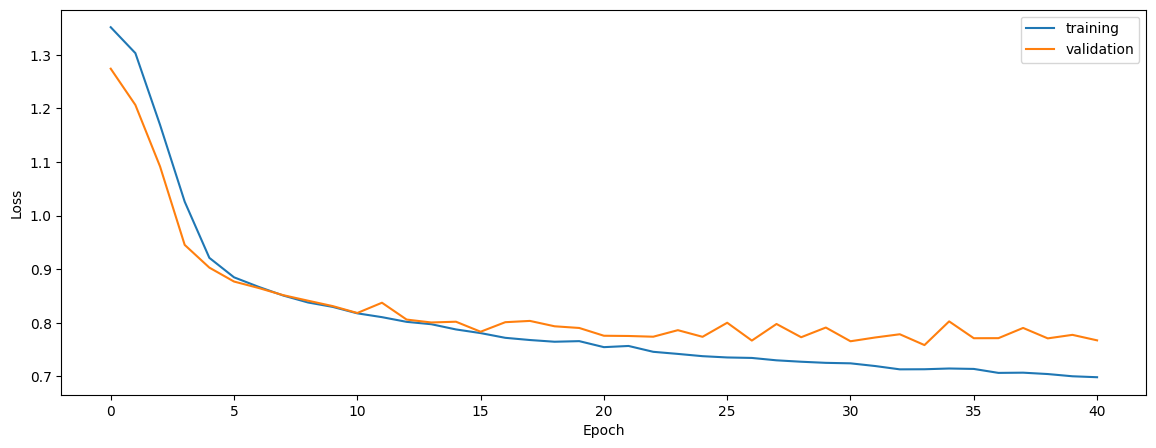

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.7151531315056292
0.704823798988622
0.7155367688698325


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

normalized
0.7151531315056292
0.704823798988622
0.7155367688698325


In [9]:
print('native')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.7126820752654736
0.7153960731211916
0.7186098778827098


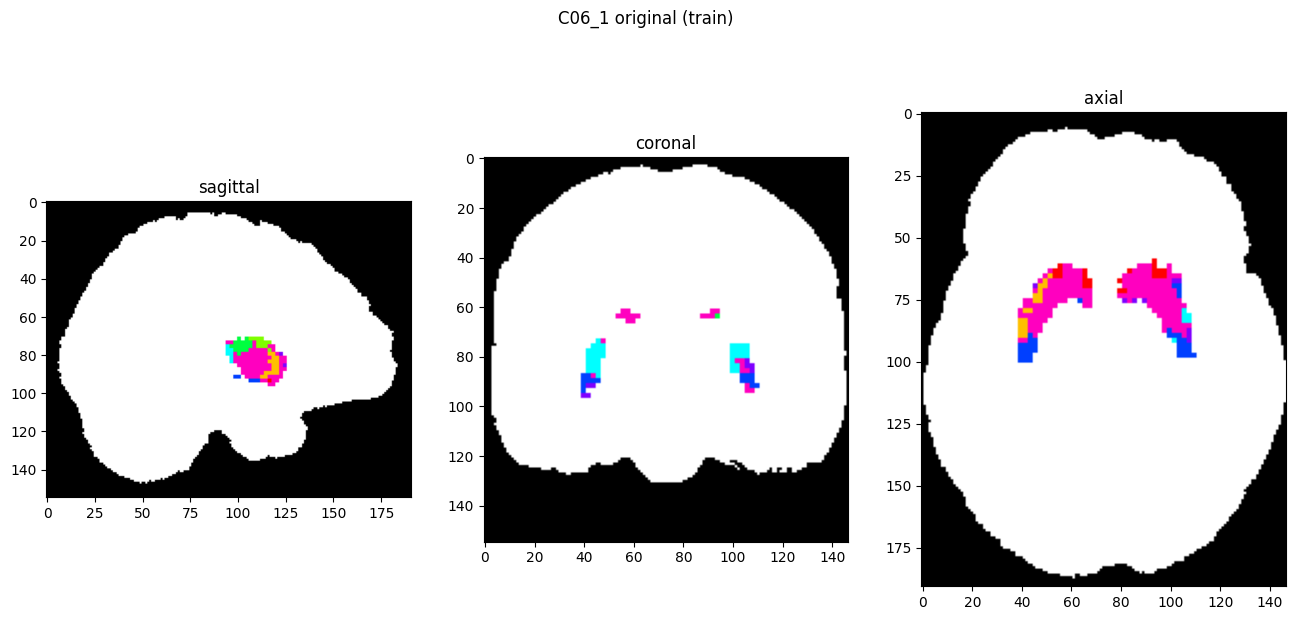

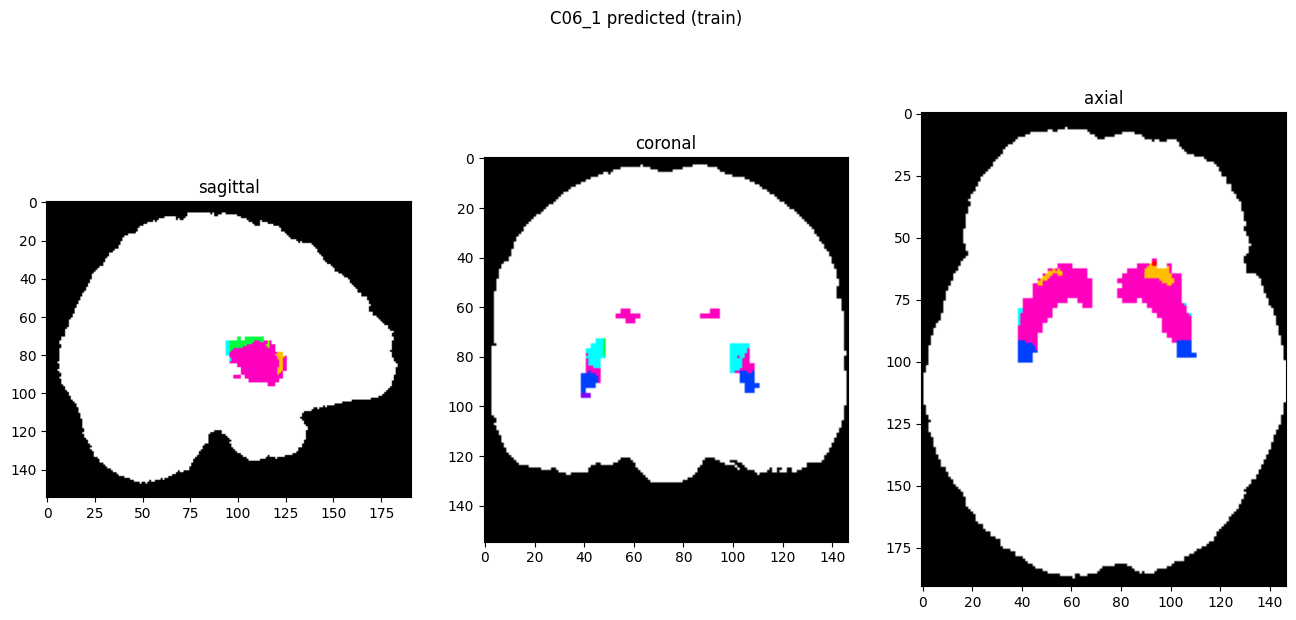

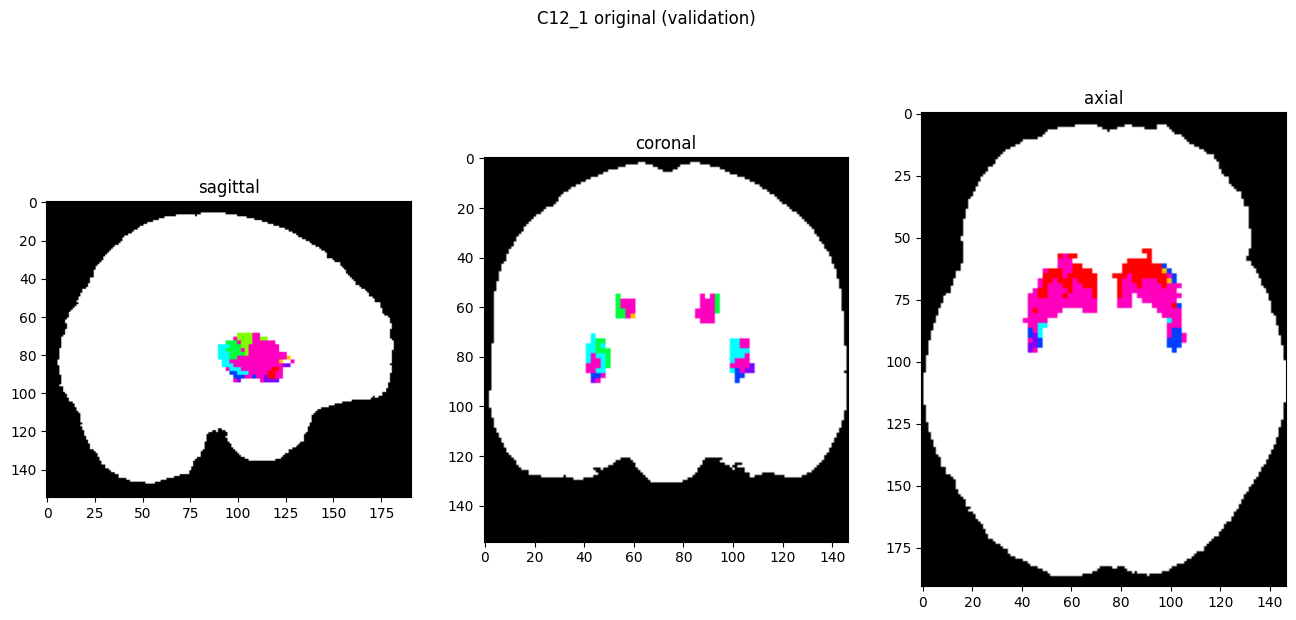

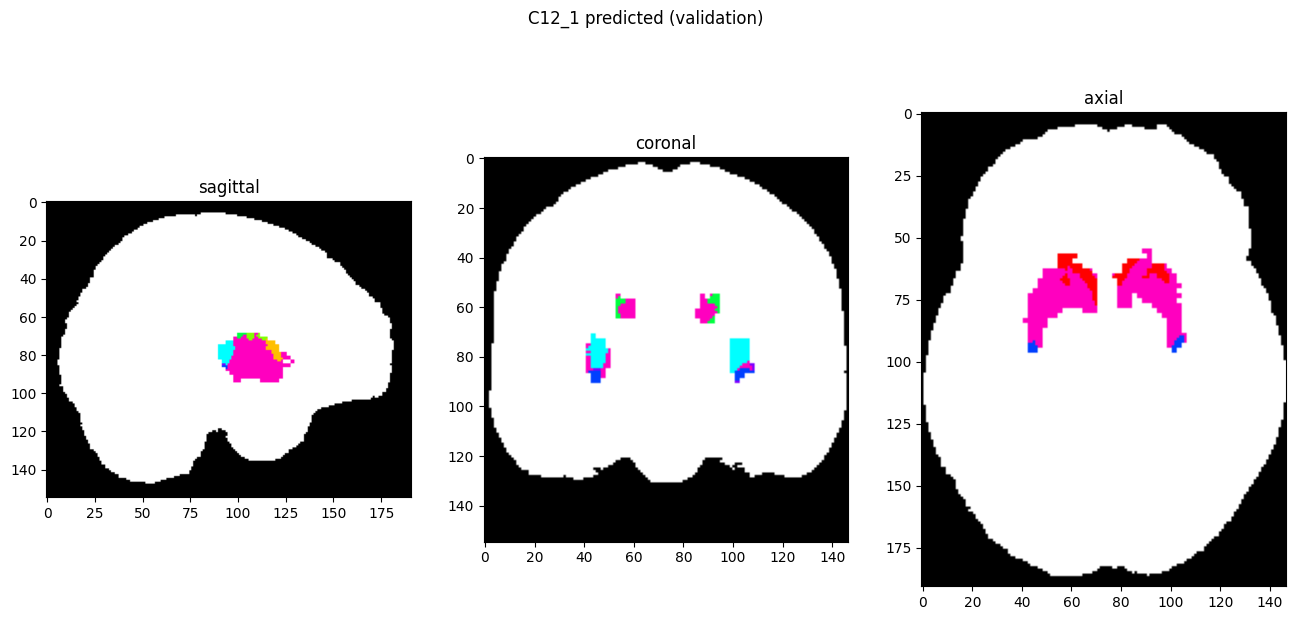

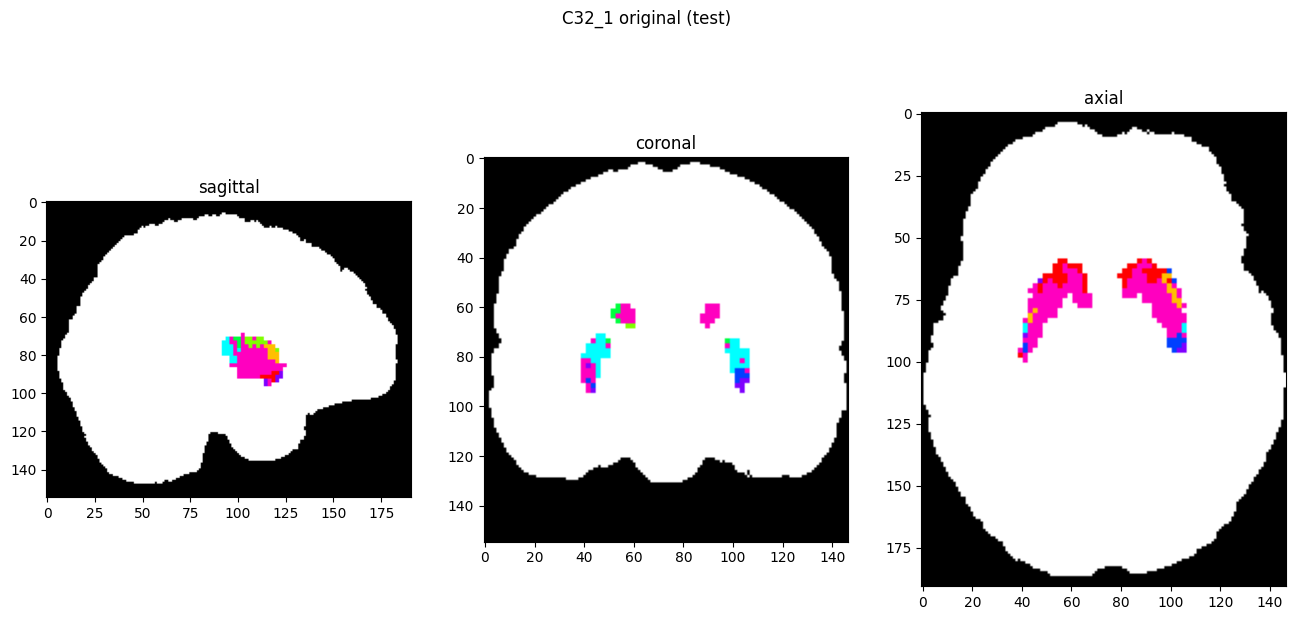

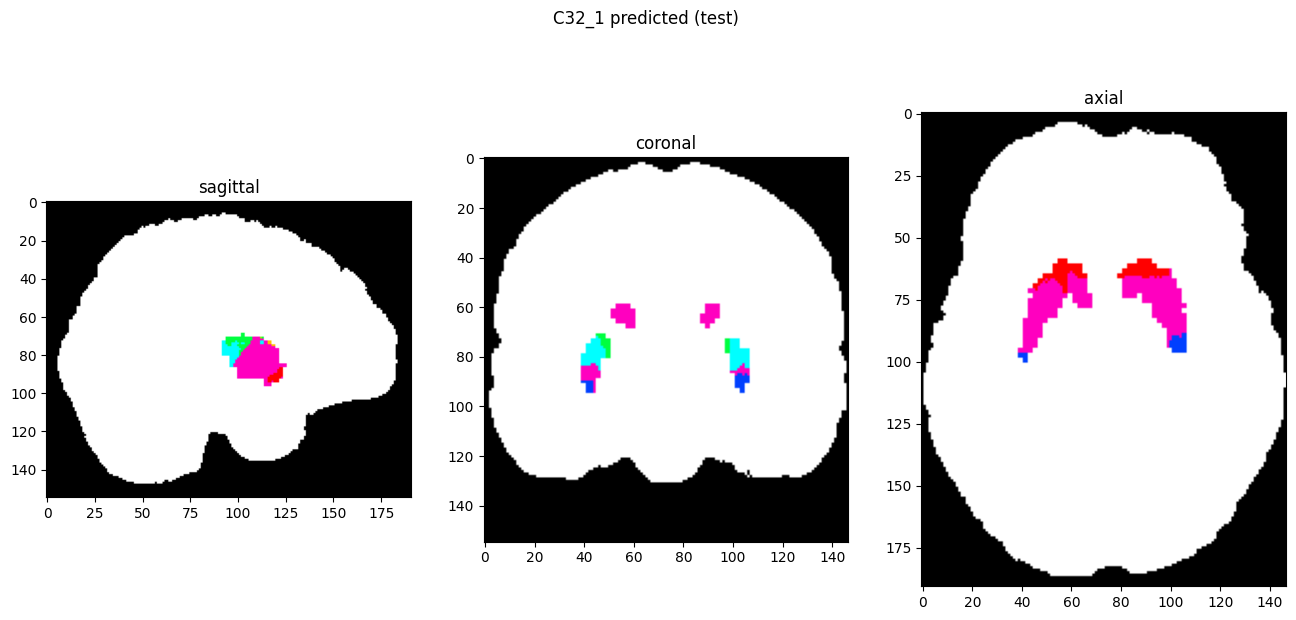

In [10]:
showResults(model, gen, threshold=0)